

#################################
#### P4P_DenPre+IonEleTmp.py ####
#################################

file_number : 1
impact_velocity: 17.800001 [km/s]
solid_ball_radius: 2.50e-08 [m]
ts: 2.81e-12 [s]
xleft: -320.0 [nm],  xright: 250.0 [nm], y_max: 260.0 [nm]
extract_xleft: -200 [nm], extract_xright: 200 [nm], extract_y_max: 200 [nm]
If the extract region reaches the extended zone, this estimate of the extract resion is not precise.

----- start loading -----
step: 0
file: ./Rat1_3BIN1/u0000.bin
step_time: 0.0 [s]
-------------------------


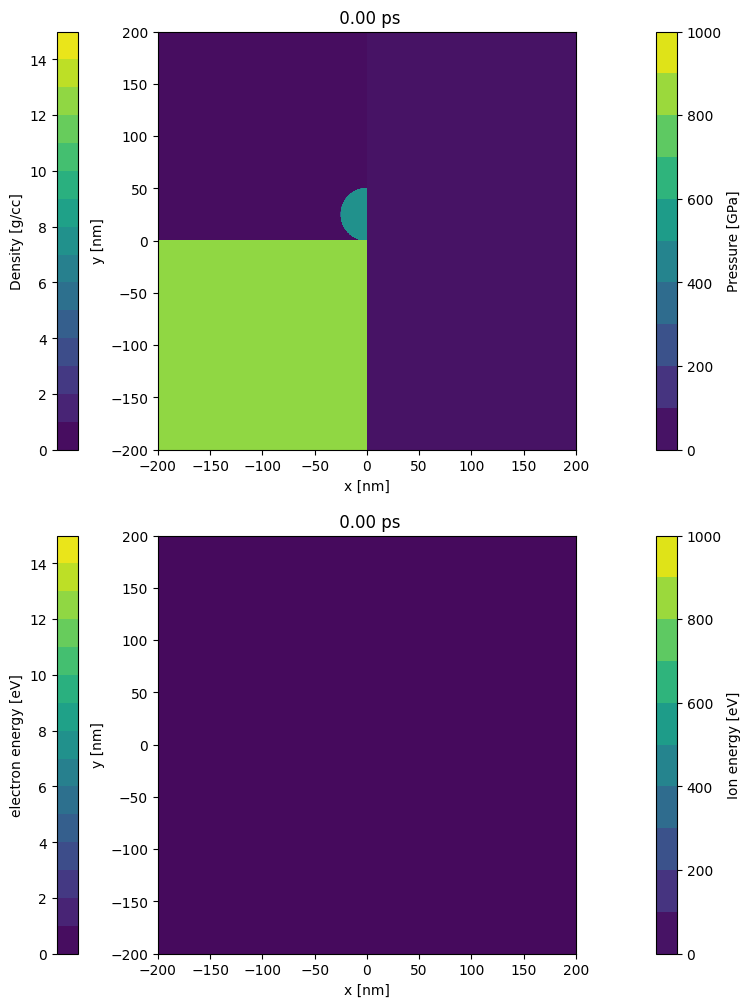

In [1]:
import matplotlib as mpl
#mpl.use('Cairo') #for png, ps, pdf, svg, ...
import matplotlib.pyplot as plt
import numpy as np
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
import glob
from scipy.interpolate import griddata
import imageio.v2 as imageio


print("\n\n#################################")
print("#### P4P_DenPre+IonEleTmp.py ####")
print("#################################\n")

fig=plt.figure(figsize=(8,12))
ax1=fig.add_subplot(211,aspect='equal')
ax2=fig.add_subplot(212,aspect='equal')

# path= os.getcwd()
# d_name   = os.path.basename(path)
d_name = "B20"
os.makedirs('./Python/P4P_DenPre+IonEleTmp/P4P_DenPre+IonEleTmp_{}'.format(d_name), exist_ok=True)

#テスト/本番設定
# operation = "test_1"
# operation = "test_2"
operation = "actual"
if operation == "test_1":
  l = 1
  file_path = "./{}/u0000.bin".format(d_name)
if operation == "test_2":
  l = 1
  file_path = "./{}/u0000.bin".format(d_name)
if operation == "actual":
  # l = 100
  l = len(glob.glob(f"{'./{}'.format(d_name)}/*"))
  file_path = "./{}/u0000.bin".format(d_name)

print("file_number :",l)


#パラメータ(cell)
nxr1=100
nxr2=200
nxr3=700
nxr4=1200
nxr5=1250
ny=451
jj2=301

#パラメータ(cm to m)
rthick = 100e-7*1e-2
xleft = 200e-7*1e-2
xright = 150e-7*1e-2
finemesh = 60e-7*1e-2
y_out = 200e-7*1e-2

#grid(m)
grid_x = rthick/(nxr3-nxr2)
grid_y = finemesh/(jj2-1)

#速度と半径、計算領域の抽出
with open(file_path, "rb") as f:
  ttime = np.fromfile(f, dtype=np.float32, count=2)[1]
  nx, ny = np.fromfile(f, dtype=np.int32, count=2)
  # print("nx",nx,"ny",ny)
  x4 = np.fromfile(f, dtype=np.float32, count=nx+1)*1e-2-rthick
  y4 = np.fromfile(f, dtype=np.float32, count=ny+1)[1:]*1e-2
  u4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2

v_impact = -np.min(u4)
print("impact_velocity:",v_impact*1e-3,"[km/s]")
solid_ball_radius = (len(np.where(u4[:,0] < 0)[0])-1)*grid_x/2
print("solid_ball_radius: {:.2e} [m]".format(solid_ball_radius))
ts = 2*solid_ball_radius/(v_impact)
print("ts: {:.2e} [s]".format(ts))

python_xleft = min(x4)*1e9
python_xright = max(x4)*1e9
python_y_out = max(y4)*1e9
# python_xleft = (-rthick -xleft -(nxr2-nxr1)*grid_x)*1e9
# python_xright = ((nxr4-nxr3)*grid_x +xright)*1e9
# python_y_out = (finemesh +y_out)*1e9
print("xleft:",round(python_xleft,1),"[nm],  xright:",round(python_xright,1),"[nm], y_max:",round(python_y_out,1),"[nm]")


## 抽出したい範囲(cell number)
x_min = 0
x_max = nx
y_max = ny
x_nm_min = -200
x_nm_max = 200
y_nm_max = 200
# x_min = round(nxr3-1*solid_ball_radius/grid_x)
# x_max = round(nxr3+2*solid_ball_radius/grid_x)
# y_max = round(2*solid_ball_radius/grid_y)
## 抽出したい範囲(nm)
# x_nm_min = round(((x_min-nxr2)*grid_x-100e-9)*1e9,1)
# x_nm_max = round(((x_max-nxr2)*grid_x-100e-9)*1e9,1)
# y_nm_min = 0
# y_nm_max = round((y_max*grid_y)*1e9,1)

x_range = (x_min, x_max)
y_range = (0, y_max)

print("extract_xleft:",x_nm_min,"[nm], extract_xright:",x_nm_max,"[nm], extract_y_max:",y_nm_max,"[nm]")
print("If the extract region reaches the extended zone, this estimate of the extract resion is not precise.")


def read_binary_with_structure(file_path, x_range, y_range):

    with open(file_path, "rb") as f:
        # === 1. 時間を読み取る ===
        ttime = np.fromfile(f, dtype=np.float32, count=2)[1]

        # === 2. nx, ny を読み取る ===
        nx, ny = np.fromfile(f, dtype=np.int32, count=2)
        print("step_time:",ttime,"[s]")
        # print("nx",nx,"ny",ny)

        # 範囲インデックス
        x_min, x_max = x_range
        y_min, y_max = y_range
        # print("x_min",x_min,"x_max",x_max,"y_min",y_min,"y_max",y_max)
        # print("x_range",range(x_min, x_max))
        # === 3. x4, y4 の読み取り ===
        x4 = np.fromfile(f, dtype=np.float32, count=nx+1)*1e-2-rthick
        y4 = np.fromfile(f, dtype=np.float32, count=ny+1)[1:]*1e-2
        u4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2
        v4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2

        # print("x4_len",len(x4))
        # print("y4_len",len(y4))
        # print("x4",x4[0:3])
        # print("y4",y4[0:3])

        # === 4. 2次元配列 (rh4, p4, te4, ti4, zi4) の読み取り ===
        def read_2d_array():
            return np.fromfile(f, dtype=np.float32, count=(nx) * (ny)).reshape((nx,ny), order='F')[:,1:]
        rh4 = read_2d_array()
        p4 = read_2d_array()*1e-1
        te4 = read_2d_array()
        ti4 = read_2d_array()        
        zi4 = read_2d_array()
        # print("p4_shape",p4.shape)


        # === 5. mtldb (整数型2次元配列) の読み取り ===
        mtldb = np.fromfile(f, dtype=np.int32, count=(nx) * (ny)).reshape((nx,ny), order='F')[:,1:]

        # === 6. その他 (aaomtl, wlaserwrite, flsr) の読み取り ===
        aaomtl = np.fromfile(f, dtype=np.float32, count=3)
        wlaserwrite = np.fromfile(f, dtype=np.float32, count=1)[0]
        flsr = np.fromfile(f, dtype=np.float32, count=1)[0]
        # print("aaomtl",aaomtl)
        # print("wlaserwrite",wlaserwrite)
        # print("flsr",flsr)

        xc = np.zeros((nx, ny-1), dtype=np.float32)
        yc = np.zeros((nx, ny-1), dtype=np.float32)
        uc = np.zeros((nx, ny-1), dtype=np.float32)
        vc = np.zeros((nx, ny-1), dtype=np.float32)
        ent = np.zeros((nx, ny-1), dtype=np.float32)
        for j in range(0, ny-1):
          for i in range(0, nx):
            xc[i,j]=(x4[i]+x4[i+1])*0.5
            yc[i,j]=(y4[j]+y4[j+1])*0.5
            uc[i,j]=(u4[i,j]+u4[i+1,j]+u4[i,j+1]+u4[i+1,j+1])*0.25
            vc[i,j]=(v4[i,j]+v4[i+1,j]+v4[i,j+1]+v4[i+1,j+1])*0.25
            if mtldb[i,j] == 1 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[0]
            if mtldb[i,j] == 2 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[1]
            if mtldb[i,j] == 3 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[2]
        # print("xc_shape",xc.shape)
        # print("yc_shape",yc.shape)
        # print("xc",xc[0:3,0:3])
        # print("yc",yc[0:3,0:3])

        # 指定範囲を抽出
        xc = xc[x_min:x_max+1,y_min:y_max+1]
        yc = yc[x_min:x_max+1,y_min:y_max+1]
        ent = ent[x_min:x_max+1,y_min:y_max+1]
        rh4 = rh4[x_min:x_max+1, y_min:y_max+1]
        p4 = p4[x_min:x_max+1, y_min:y_max+1]
        te4 = te4[x_min:x_max+1, y_min:y_max+1]
        ti4 = ti4[x_min:x_max+1, y_min:y_max+1]
        zi4 = zi4[x_min:x_max+1, y_min:y_max+1]
        mtldb = mtldb[x_min:x_max+1, y_min:y_max+1]

        # print("xc_shape",xc.shape)
        # print("yc_shape",yc.shape)

    # データを辞書形式で返す
    return {
        "time": ttime,
        "x": xc,
        "y": yc,
        "u": u4,
        "v": v4,
        "rho": rh4,
        "en": ent,
        "P": p4,
        "te": te4,
        "ti": ti4,
        "zi": zi4,
        "mtl": mtldb,
        "Target_mol":aaomtl[1],
        "Projectile_mol":aaomtl[2],
        "ambience_mol": aaomtl[0],
        "wlaserwrite": wlaserwrite,
        "flsr": flsr,
    }
#Output units
# x, y : 座標(m)
# u, v : 流速 (m/s)
# rho : 密度 (g/cc)
# en : 電子数密度(個/cc)
# P : 圧力 (Pa)
# te : 電子温度 (eV)
# ti : イオン温度(eV)
# zi : 電離度
# mtl : 物質追跡

print("\n----- start loading -----")
for i in np.arange(0,l,1):

  print('step:',i)
  print("file:",file_path)

  if operation == "test_1":
    file_path = "./{}/u0005.{}/bin".format(d_name)
  if operation == "test_2":
    file_path = "./{}/u{:04d}.bin".format(d_name, i)
  if operation == "actual":
    file_path = "./{}/u{:04d}.bin".format(d_name, i)

  # データを読み取る(m to nm)
  data = read_binary_with_structure(file_path, x_range, y_range)
  # print(data)
  print('-------------------------')
  #衝突速度の抽出

  # # 解像度を増やす
  # grid_x = np.linspace(x_nm_min, x_nm_max, 500)  
  # grid_y = np.linspace(-y_nm_min, y_nm_max, 500)
  # grid_x, grid_y = np.meshgrid(grid_x, grid_y)
  # # PressureとDensityを補間 (griddataを使う)
  # grid_P = griddata((data["x"].flatten(), data["y"].flatten()), data["P"].flatten(), 
  #     (grid_x, grid_y), method='cubic')
  # grid_rho = griddata((data["x"].flatten(), data["y"].flatten()), data["rho"].flatten(), 
  #     (grid_x, grid_y), method='cubic')

  # Set up a pylab figure
  # set axis labels
  ax1.set_xlabel('x [nm]')
  ax1.set_ylabel('y [nm]')
  # set axis limits
  ax1.set_ylim([x_nm_min,x_nm_max])
  ax1.set_xlim([-y_nm_max,y_nm_max])
  # ax1.set_xlim([python_xleft,python_xright])
  # ax1.set_ylim([-python_y_out,python_y_out])

  # Plot field
  # p1=ax1.pcolormesh(data["y"]*1e9,data["x"]*1e9,data["P"]*1e-9,vmin=10,vmax=100)
  # p2=ax1.pcolormesh(-data["y"]*1e9,data["x"]*1e9,data["rho"],vmin=0,vmax=13)
  p1=ax1.tricontourf(data["y"].flatten()*1e9,data["x"].flatten()*1e9,data["P"].flatten()*1e-9,levels=np.linspace(0,1000,11))
  p2=ax1.tricontourf(-data["y"].flatten()*1e9,data["x"].flatten()*1e9,data["rho"].flatten(),levels=np.linspace(0,15,16))

  # add color bar
  if i == 0:
    # create colorbars to either side of the plot
    divider = make_axes_locatable(ax1)
    cx1=divider.append_axes("right", size="5%", pad=0.8)
    cx2=divider.append_axes("left", size="5%", pad=0.8)
    cb3=fig.colorbar(p1,cax=cx1)
    cb3.set_label('Pressure [GPa]')
    cb4=fig.colorbar(p2,cax=cx2)
    cb4.set_label('Density [g/cc]')

    # set labels on left for left side colorbar
    cx2.yaxis.tick_left()
    cx2.yaxis.set_label_position('left')

    # set title
  ax1.set_title('{: 5.2f} ps'.format(data["time"]*1e12))


  # set axis labels
  ax2.set_xlabel('x [nm]')
  ax2.set_ylabel('y [nm]')
  # set axis limits
  ax2.set_ylim([x_nm_min,x_nm_max])
  ax2.set_xlim([-y_nm_max,y_nm_max])
  # ax.set_xlim([python_xleft,python_xright])
  # ax.set_ylim([-python_y_out,python_y_out])

  # Plot field
  # p1=ax.pcolormesh(data["y"]*1e9,data["x"]*1e9,data["P"]*1e-9,vmin=10,vmax=100)
  # p2=ax.pcolormesh(-data["y"]*1e9,-data["x"]*1e9,data["rho"],vmin=0,vmax=13)
  p5=ax2.tricontourf(data["y"].flatten()*1e9,data["x"].flatten()*1e9,data["ti"].flatten(),levels=np.linspace(0,10,21))
  p6=ax2.tricontourf(-data["y"].flatten()*1e9,data["x"].flatten()*1e9,data["te"].flatten(),levels=np.linspace(0,10,21))

  # add color bar
  if i == 0:
    # create colorbars to either side of the plot
    divider = make_axes_locatable(ax2)
    cx5=divider.append_axes("right", size="5%", pad=0.8)
    cx6=divider.append_axes("left", size="5%", pad=0.8)
    cb7=fig.colorbar(p1,cax=cx5)
    cb7.set_label('Ion energy [eV]')
    cb8=fig.colorbar(p2,cax=cx6)
    cb8.set_label('electron energy [eV]')

    # set labels on left for left side colorbar
    cx6.yaxis.tick_left()
    cx6.yaxis.set_label_position('left')

    # set title
  ax2.set_title('{: 5.2f} ps'.format(data["time"]*1e12))

    
  # save the figure
  if operation == "actual":
    fig.savefig('./Python/P4P_DenPre+IonEleTmp/P4P_DenPre+IonEleTmp_{}/P4P_DenPre+IonEleTmp{:05d}.png'.format(d_name,i))
    # clear axis for next step
    ax1.cla()
    ax2.cla()

if operation == "actual":
    # Directory to save images
    output_dir = './Python/P4P_DenPre+IonEleTmp/P4P_DenPre+IonEleTmp_{}/'.format(d_name)
    output_gif = './Python/P4P_DenPre+IonEleTmp/P4P_DenPre+IonEleTmp_{}.gif'.format(d_name)  # Output GIF path
    frame_duration = 0.1  # Duration per frame in seconds
    
    
    # Generate GIF after saving PNG
    image_files = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.png')])
    
    if len(image_files) > 0:
        print(f"Found {len(image_files)} images. Creating/updating GIF...")
    
        # Read and write images to GIF
        images = [imageio.imread(img) for img in image_files]
        imageio.mimsave(output_gif, images, duration=frame_duration)
    
        print("GIF created/updated successfully:", output_gif)
    else:
        print("No images found to create GIF.")


In [ ]:
import matplotlib as mpl
#mpl.use('Cairo') #for png, ps, pdf, svg, ...
import matplotlib.pyplot as plt
import numpy as np
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
import glob
from scipy.interpolate import griddata

print("\n\n###########################")
print("#### P4P_Ion-EleTmp.py ####")
print("###########################\n")


fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111,aspect='equal')

# path= os.getcwd()
# d_name   = os.path.basename(path)
d_name = "Rat5_2BIN1"
os.makedirs('./Python/P4P_Ion-EleTmp/P4P_Ion-EleTmp_{}'.format(d_name), exist_ok=True)

#テスト/本番設定
# operation = "test_1"
# operation = "test_2"
operation = "actual"
if operation == "test_1":
  l = 1
  file_path = "./{}/u0000.bin".format(d_name)
if operation == "test_2":
  l = 100
  file_path = "./{}/u0000.bin".format(d_name)
if operation == "actual":
  # l = 100
  l = len(glob.glob(f"{'./{}'.format(d_name)}/*"))
  file_path = "./{}/u0000.bin".format(d_name)

print("file_number :",l)


#パラメータ(cell)
nxr1=100
nxr2=200
nxr3=700
nxr4=1200
nxr5=1250
ny=451
jj2=301

#パラメータ(cm to m)
rthick = 100e-7*1e-2
xleft = 200e-7*1e-2
xright = 150e-7*1e-2
finemesh = 60e-7*1e-2
y_out = 200e-7*1e-2

#grid(m)
grid_x = rthick/(nxr3-nxr2)
grid_y = finemesh/(jj2-1)

#速度と半径、計算領域の抽出
with open(file_path, "rb") as f:
  ttime = np.fromfile(f, dtype=np.float32, count=2)[1]
  nx, ny = np.fromfile(f, dtype=np.int32, count=2)
  # print("nx",nx,"ny",ny)
  x4 = np.fromfile(f, dtype=np.float32, count=nx+1)*1e-2-rthick
  y4 = np.fromfile(f, dtype=np.float32, count=ny+1)[1:]*1e-2
  u4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2

v_impact = -np.min(u4)
print("impact_velocity:",v_impact*1e-3,"[km/s]")
solid_ball_radius = (len(np.where(u4[:,0] < 0)[0])-1)*grid_x/2
print("solid_ball_radius: {:.2e} [m]".format(solid_ball_radius))
ts = 2*solid_ball_radius/(v_impact)
print("ts: {:.2e} [s]".format(ts))

python_xleft = min(x4)*1e9
python_xright = max(x4)*1e9
python_y_out = max(y4)*1e9
# python_xleft = (-rthick -xleft -(nxr2-nxr1)*grid_x)*1e9
# python_xright = ((nxr4-nxr3)*grid_x +xright)*1e9
# python_y_out = (finemesh +y_out)*1e9
print("xleft:",round(python_xleft,1),"[nm],  xright:",round(python_xright,1),"[nm], y_max:",round(python_y_out,1),"[nm]")


## 抽出したい範囲(cell number)
x_min = 0
x_max = nx
y_max = ny
x_nm_min = -200
x_nm_max = 200
y_nm_max = 200
# x_min = round(nxr3-1*solid_ball_radius/grid_x)
# x_max = round(nxr3+2*solid_ball_radius/grid_x)
# y_max = round(2*solid_ball_radius/grid_y)
## 抽出したい範囲(nm)
# x_nm_min = round(((x_min-nxr2)*grid_x-100e-9)*1e9,1)
# x_nm_max = round(((x_max-nxr2)*grid_x-100e-9)*1e9,1)
# y_nm_min = 0
# y_nm_max = round((y_max*grid_y)*1e9,1)

x_range = (x_min, x_max)
y_range = (0, y_max)

print("extract_xleft:",x_nm_min,"[nm], extract_xright:",x_nm_max,"[nm], extract_y_max:",y_nm_max,"[nm]")
print("If the extract region reaches the extended zone, this estimate of the extract resion is not precise.")


def read_binary_with_structure(file_path, x_range, y_range):

    with open(file_path, "rb") as f:
        # === 1. 時間を読み取る ===
        ttime = np.fromfile(f, dtype=np.float32, count=2)[1]

        # === 2. nx, ny を読み取る ===
        nx, ny = np.fromfile(f, dtype=np.int32, count=2)
        print("step_time:",ttime,"[s]")
        # print("nx",nx,"ny",ny)

        # 範囲インデックス
        x_min, x_max = x_range
        y_min, y_max = y_range
        # print("x_min",x_min,"x_max",x_max,"y_min",y_min,"y_max",y_max)
        # print("x_range",range(x_min, x_max))
        # === 3. x4, y4 の読み取り ===
        x4 = np.fromfile(f, dtype=np.float32, count=nx+1)*1e-2-rthick
        y4 = np.fromfile(f, dtype=np.float32, count=ny+1)[1:]*1e-2
        u4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2
        v4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2

        # print("x4_len",len(x4))
        # print("y4_len",len(y4))
        # print("x4",x4[0:3])
        # print("y4",y4[0:3])

        # === 4. 2次元配列 (rh4, p4, te4, ti4, zi4) の読み取り ===
        def read_2d_array():
            return np.fromfile(f, dtype=np.float32, count=(nx) * (ny)).reshape((nx,ny), order='F')[:,1:]
        rh4 = read_2d_array()
        p4 = read_2d_array()*1e-1
        te4 = read_2d_array()
        ti4 = read_2d_array()        
        zi4 = read_2d_array()
        # print("p4_shape",p4.shape)


        # === 5. mtldb (整数型2次元配列) の読み取り ===
        mtldb = np.fromfile(f, dtype=np.int32, count=(nx) * (ny)).reshape((nx,ny), order='F')[:,1:]

        # === 6. その他 (aaomtl, wlaserwrite, flsr) の読み取り ===
        aaomtl = np.fromfile(f, dtype=np.float32, count=3)
        wlaserwrite = np.fromfile(f, dtype=np.float32, count=1)[0]
        flsr = np.fromfile(f, dtype=np.float32, count=1)[0]
        # print("aaomtl",aaomtl)
        # print("wlaserwrite",wlaserwrite)
        # print("flsr",flsr)

        xc = np.zeros((nx, ny-1), dtype=np.float32)
        yc = np.zeros((nx, ny-1), dtype=np.float32)
        uc = np.zeros((nx, ny-1), dtype=np.float32)
        vc = np.zeros((nx, ny-1), dtype=np.float32)
        ent = np.zeros((nx, ny-1), dtype=np.float32)
        for j in range(0, ny-1):
          for i in range(0, nx):
            xc[i,j]=(x4[i]+x4[i+1])*0.5
            yc[i,j]=(y4[j]+y4[j+1])*0.5
            uc[i,j]=(u4[i,j]+u4[i+1,j]+u4[i,j+1]+u4[i+1,j+1])*0.25
            vc[i,j]=(v4[i,j]+v4[i+1,j]+v4[i,j+1]+v4[i+1,j+1])*0.25
            if mtldb[i,j] == 1 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[0]
            if mtldb[i,j] == 2 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[1]
            if mtldb[i,j] == 3 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[2]
        # print("xc_shape",xc.shape)
        # print("yc_shape",yc.shape)
        # print("xc",xc[0:3,0:3])
        # print("yc",yc[0:3,0:3])

        # 指定範囲を抽出
        xc = xc[x_min:x_max+1,y_min:y_max+1]
        yc = yc[x_min:x_max+1,y_min:y_max+1]
        ent = ent[x_min:x_max+1,y_min:y_max+1]
        rh4 = rh4[x_min:x_max+1, y_min:y_max+1]
        p4 = p4[x_min:x_max+1, y_min:y_max+1]
        te4 = te4[x_min:x_max+1, y_min:y_max+1]
        ti4 = ti4[x_min:x_max+1, y_min:y_max+1]
        zi4 = zi4[x_min:x_max+1, y_min:y_max+1]
        mtldb = mtldb[x_min:x_max+1, y_min:y_max+1]

        # print("xc_shape",xc.shape)
        # print("yc_shape",yc.shape)

    # データを辞書形式で返す
    return {
        "time": ttime,
        "x": xc,
        "y": yc,
        "u": u4,
        "v": v4,
        "rho": rh4,
        "en": ent,
        "P": p4,
        "te": te4,
        "ti": ti4,
        "zi": zi4,
        "mtl": mtldb,
        "Target_mol":aaomtl[1],
        "Projectile_mol":aaomtl[2],
        "ambience_mol": aaomtl[0],
        "wlaserwrite": wlaserwrite,
        "flsr": flsr,
    }
#Output units
# x, y : 座標(m)
# u, v : 流速 (m/s)
# rho : 密度 (g/cc)
# en : 電子数密度(個/cc)
# P : 圧力 (Pa)
# te : 電子温度 (eV)
# ti : イオン温度(eV)
# zi : 電離度
# mtl : 物質追跡

print("\n----- start loading -----")
for i in np.arange(0,l,1):

  print('step:',i)
  print("file:",file_path)

  if operation == "test_1":
    file_path = "./{}/u0005.{}/bin".format(d_name)
  if operation == "test_2":
    file_path = "./{}/u{:04d}.bin".format(d_name, i)
  if operation == "actual":
    file_path = "./{}/u{:04d}.bin".format(d_name, i)

  # データを読み取る(m to nm)
  data = read_binary_with_structure(file_path, x_range, y_range)
  # print(data)
  print('-------------------------')
  #衝突速度の抽出

  # # 解像度を増やす
  # grid_x = np.linspace(x_nm_min, x_nm_max, 500)  
  # grid_y = np.linspace(-y_nm_min, y_nm_max, 500)
  # grid_x, grid_y = np.meshgrid(grid_x, grid_y)
  # # PressureとDensityを補間 (griddataを使う)
  # grid_P = griddata((data["x"].flatten(), data["y"].flatten()), data["P"].flatten(), 
  #     (grid_x, grid_y), method='cubic')
  # grid_rho = griddata((data["x"].flatten(), data["y"].flatten()), data["rho"].flatten(), 
  #     (grid_x, grid_y), method='cubic')

  # Set up a pylab figure
  # set axis labels
  ax.set_xlabel('x [nm]')
  ax.set_ylabel('y [nm]')
  # set axis limits
  ax.set_ylim([x_nm_min,x_nm_max])
  ax.set_xlim([-y_nm_max,y_nm_max])
  # ax.set_xlim([python_xleft,python_xright])
  # ax.set_ylim([-python_y_out,python_y_out])

  # Plot field
  # p1=ax.pcolormesh(data["y"]*1e9,data["x"]*1e9,data["P"]*1e-9,vmin=10,vmax=100)
  # p2=ax.pcolormesh(-data["y"]*1e9,-data["x"]*1e9,data["rho"],vmin=0,vmax=13)
  p1=ax.tricontourf(data["y"].flatten()*1e9,data["x"].flatten()*1e9,data["ti"].flatten(),levels=np.linspace(0,10,21))
  p2=ax.tricontourf(-data["y"].flatten()*1e9,data["x"].flatten()*1e9,data["te"].flatten(),levels=np.linspace(0,10,21))

  # add color bar
  if i == 0:
    # create colorbars to either side of the plot
    divider = make_axes_locatable(ax)
    cx1=divider.append_axes("right", size="5%", pad=0.8)
    cx2=divider.append_axes("left", size="5%", pad=0.8)
    cb3=fig.colorbar(p1,cax=cx1)
    cb3.set_label('Ion energy [eV]')
    cb4=fig.colorbar(p2,cax=cx2)
    cb4.set_label('electron energy [eV]')

    # set labels on left for left side colorbar
    cx2.yaxis.tick_left()
    cx2.yaxis.set_label_position('left')

    # set title
  ax.set_title('{: 5.2f} ps'.format(data["time"]*1e12))

  # save the figure
  if operation == "actual":
    fig.savefig('./Python/P4P_Ion-EleTmp/P4P_Ion-EleTmp_{}/P4P_Ion-EleTmp{:05d}.png'.format(d_name,i))
    # clear axis for next step
    ax.cla()



#######################
#### P4P_MatEnt.py ####
#######################

file_number : 100
impact_velocity: 44.000004 [km/s]
solid_ball_radius: 2.65e-08 [m]
ts: 1.20e-12 [s]
xleft: -320.0 [nm],  xright: 250.0 [nm], y_max: 260.0 [nm]
extract_xleft: -200 [nm], extract_xright: 200 [nm], extract_y_max: 200 [nm]
If the extract region reaches the extended zone, this estimate of the extract resion is not precise.

----- start loading -----
step: 0
file: ./Rat5_2BIN1/u0000.bin
step_time: 0.0 [s]
-------------------------
step: 1
file: ./Rat5_2BIN1/u0000.bin
step_time: 1.0047877e-13 [s]
-------------------------
step: 2
file: ./Rat5_2BIN1/u0001.bin
step_time: 2.0018229e-13 [s]
-------------------------
step: 3
file: ./Rat5_2BIN1/u0002.bin
step_time: 3.0000858e-13 [s]
-------------------------
step: 4
file: ./Rat5_2BIN1/u0003.bin
step_time: 4.0031807e-13 [s]
-------------------------
step: 5
file: ./Rat5_2BIN1/u0004.bin
step_time: 5.004966e-13 [s]
-------------------------
step: 6
file: ./Rat5

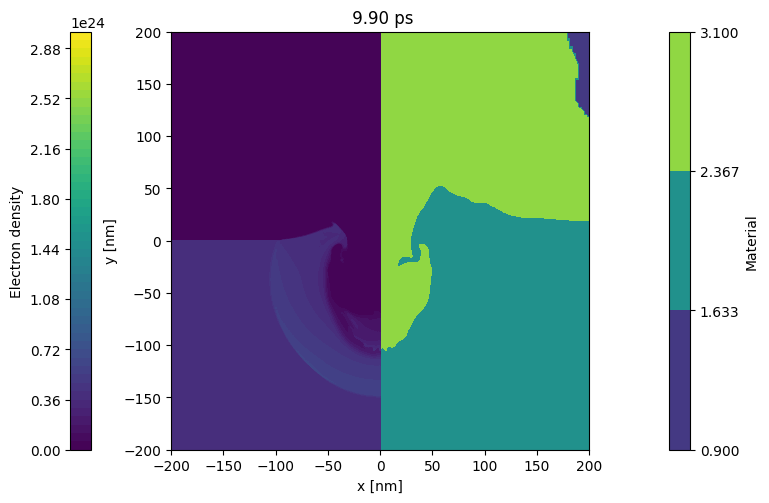

In [11]:
import matplotlib as mpl
#mpl.use('Cairo') #for png, ps, pdf, svg, ...
import matplotlib.pyplot as plt
import numpy as np
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
import glob
from scipy.interpolate import griddata

print("\n\n#######################")
print("#### P4P_MatEnt.py ####")
print("#######################\n")


fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111,aspect='equal')

# path= os.getcwd()
# d_name   = os.path.basename(path)
d_name = "Rat5_2BIN1"
os.makedirs('./Python/P4P_MatEnt/P4P_MatEnt_{}'.format(d_name), exist_ok=True)

#テスト/本番設定
# operation = "test_1"
operation = "test_2"
# operation = "actual"
if operation == "test_1":
  l = 1
  file_path = "./{}/u0000.bin".format(d_name)
if operation == "test_2":
  l = 100
  file_path = "./{}/u0000.bin".format(d_name)
if operation == "actual":
  # l = 100
  l = len(glob.glob(f"{'./{}'.format(d_name)}/*"))
  file_path = "./{}/u0000.bin".format(d_name)

print("file_number :",l)


#パラメータ(cell)
nxr1=100
nxr2=200
nxr3=700
nxr4=1200
nxr5=1250
ny=451
jj2=301

#パラメータ(cm to m)
rthick = 100e-7*1e-2
xleft = 200e-7*1e-2
xright = 150e-7*1e-2
finemesh = 60e-7*1e-2
y_out = 200e-7*1e-2

#grid(m)
grid_x = rthick/(nxr3-nxr2)
grid_y = finemesh/(jj2-1)

#速度と半径、計算領域の抽出
with open(file_path, "rb") as f:
  ttime = np.fromfile(f, dtype=np.float32, count=2)[1]
  nx, ny = np.fromfile(f, dtype=np.int32, count=2)
  # print("nx",nx,"ny",ny)
  x4 = np.fromfile(f, dtype=np.float32, count=nx+1)*1e-2-rthick
  y4 = np.fromfile(f, dtype=np.float32, count=ny+1)[1:]*1e-2
  u4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2

v_impact = -np.min(u4)
print("impact_velocity:",v_impact*1e-3,"[km/s]")
solid_ball_radius = (len(np.where(u4[:,0] < 0)[0])-1)*grid_x/2
print("solid_ball_radius: {:.2e} [m]".format(solid_ball_radius))
ts = 2*solid_ball_radius/(v_impact)
print("ts: {:.2e} [s]".format(ts))

python_xleft = min(x4)*1e9
python_xright = max(x4)*1e9
python_y_out = max(y4)*1e9
# python_xleft = (-rthick -xleft -(nxr2-nxr1)*grid_x)*1e9
# python_xright = ((nxr4-nxr3)*grid_x +xright)*1e9
# python_y_out = (finemesh +y_out)*1e9
print("xleft:",round(python_xleft,1),"[nm],  xright:",round(python_xright,1),"[nm], y_max:",round(python_y_out,1),"[nm]")


## 抽出したい範囲(cell number)
x_min = 0
x_max = nx
y_max = ny
x_nm_min = -200
x_nm_max = 200
y_nm_max = 200
# x_min = round(nxr3-1*solid_ball_radius/grid_x)
# x_max = round(nxr3+2*solid_ball_radius/grid_x)
# y_max = round(2*solid_ball_radius/grid_y)
## 抽出したい範囲(nm)
# x_nm_min = round(((x_min-nxr2)*grid_x-100e-9)*1e9,1)
# x_nm_max = round(((x_max-nxr2)*grid_x-100e-9)*1e9,1)
# y_nm_min = 0
# y_nm_max = round((y_max*grid_y)*1e9,1)

x_range = (x_min, x_max)
y_range = (0, y_max)

print("extract_xleft:",x_nm_min,"[nm], extract_xright:",x_nm_max,"[nm], extract_y_max:",y_nm_max,"[nm]")
print("If the extract region reaches the extended zone, this estimate of the extract resion is not precise.")


def read_binary_with_structure(file_path, x_range, y_range):

    with open(file_path, "rb") as f:
        # === 1. 時間を読み取る ===
        ttime = np.fromfile(f, dtype=np.float32, count=2)[1]

        # === 2. nx, ny を読み取る ===
        nx, ny = np.fromfile(f, dtype=np.int32, count=2)
        print("step_time:",ttime,"[s]")
        # print("nx",nx,"ny",ny)

        # 範囲インデックス
        x_min, x_max = x_range
        y_min, y_max = y_range
        # print("x_min",x_min,"x_max",x_max,"y_min",y_min,"y_max",y_max)
        # print("x_range",range(x_min, x_max))
        # === 3. x4, y4 の読み取り ===
        x4 = np.fromfile(f, dtype=np.float32, count=nx+1)*1e-2-rthick
        y4 = np.fromfile(f, dtype=np.float32, count=ny+1)[1:]*1e-2
        u4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2
        v4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2

        # print("x4_len",len(x4))
        # print("y4_len",len(y4))
        # print("x4",x4[0:3])
        # print("y4",y4[0:3])

        # === 4. 2次元配列 (rh4, p4, te4, ti4, zi4) の読み取り ===
        def read_2d_array():
            return np.fromfile(f, dtype=np.float32, count=(nx) * (ny)).reshape((nx,ny), order='F')[:,1:]
        rh4 = read_2d_array()
        p4 = read_2d_array()*1e-1
        te4 = read_2d_array()
        ti4 = read_2d_array()        
        zi4 = read_2d_array()
        # print("p4_shape",p4.shape)


        # === 5. mtldb (整数型2次元配列) の読み取り ===
        mtldb = np.fromfile(f, dtype=np.int32, count=(nx) * (ny)).reshape((nx,ny), order='F')[:,1:]

        # === 6. その他 (aaomtl, wlaserwrite, flsr) の読み取り ===
        aaomtl = np.fromfile(f, dtype=np.float32, count=3)
        wlaserwrite = np.fromfile(f, dtype=np.float32, count=1)[0]
        flsr = np.fromfile(f, dtype=np.float32, count=1)[0]
        # print("aaomtl",aaomtl)
        # print("wlaserwrite",wlaserwrite)
        # print("flsr",flsr)

        xc = np.zeros((nx, ny-1), dtype=np.float32)
        yc = np.zeros((nx, ny-1), dtype=np.float32)
        uc = np.zeros((nx, ny-1), dtype=np.float32)
        vc = np.zeros((nx, ny-1), dtype=np.float32)
        ent = np.zeros((nx, ny-1), dtype=np.float32)
        for j in range(0, ny-1):
          for i in range(0, nx):
            xc[i,j]=(x4[i]+x4[i+1])*0.5
            yc[i,j]=(y4[j]+y4[j+1])*0.5
            uc[i,j]=(u4[i,j]+u4[i+1,j]+u4[i,j+1]+u4[i+1,j+1])*0.25
            vc[i,j]=(v4[i,j]+v4[i+1,j]+v4[i,j+1]+v4[i+1,j+1])*0.25
            if mtldb[i,j] == 1 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[0]
            if mtldb[i,j] == 2 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[1]
            if mtldb[i,j] == 3 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[2]
        # print("xc_shape",xc.shape)
        # print("yc_shape",yc.shape)
        # print("xc",xc[0:3,0:3])
        # print("yc",yc[0:3,0:3])

        # 指定範囲を抽出
        xc = xc[x_min:x_max+1,y_min:y_max+1]
        yc = yc[x_min:x_max+1,y_min:y_max+1]
        ent = ent[x_min:x_max+1,y_min:y_max+1]
        rh4 = rh4[x_min:x_max+1, y_min:y_max+1]
        p4 = p4[x_min:x_max+1, y_min:y_max+1]
        te4 = te4[x_min:x_max+1, y_min:y_max+1]
        ti4 = ti4[x_min:x_max+1, y_min:y_max+1]
        zi4 = zi4[x_min:x_max+1, y_min:y_max+1]
        mtldb = mtldb[x_min:x_max+1, y_min:y_max+1]

        # print("xc_shape",xc.shape)
        # print("yc_shape",yc.shape)

    # データを辞書形式で返す
    return {
        "time": ttime,
        "x": xc,
        "y": yc,
        "u": u4,
        "v": v4,
        "rho": rh4,
        "en": ent,
        "P": p4,
        "te": te4,
        "ti": ti4,
        "zi": zi4,
        "mtl": mtldb,
        "Target_mol":aaomtl[1],
        "Projectile_mol":aaomtl[2],
        "ambience_mol": aaomtl[0],
        "wlaserwrite": wlaserwrite,
        "flsr": flsr,
    }
#Output units
# x, y : 座標(m)
# u, v : 流速 (m/s)
# rho : 密度 (g/cc)
# en : 電子数密度(個/cc)
# P : 圧力 (Pa)
# te : 電子温度 (eV)
# ti : イオン温度(eV)
# zi : 電離度
# mtl : 物質追跡

print("\n----- start loading -----")
for i in np.arange(0,l,1):

  print('step:',i)
  print("file:",file_path)

  if operation == "test_1":
    file_path = "./{}/u0005.{}/bin".format(d_name)
  if operation == "test_2":
    file_path = "./{}/u{:04d}.bin".format(d_name, i)
  if operation == "actual":
    file_path = "./{}/u{:04d}.bin".format(d_name, i)


  # データを読み取る(m to nm)
  data = read_binary_with_structure(file_path, x_range, y_range)
  # print(data)
  print('-------------------------')
  #衝突速度の抽出

  # # 解像度を増やす
  # grid_x = np.linspace(x_nm_min, x_nm_max, 500)  
  # grid_y = np.linspace(-y_nm_min, y_nm_max, 500)
  # grid_x, grid_y = np.meshgrid(grid_x, grid_y)
  # # PressureとDensityを補間 (griddataを使う)
  # grid_P = griddata((data["x"].flatten(), data["y"].flatten()), data["P"].flatten(), 
  #     (grid_x, grid_y), method='cubic')
  # grid_rho = griddata((data["x"].flatten(), data["y"].flatten()), data["rho"].flatten(), 
  #     (grid_x, grid_y), method='cubic')

  # Set up a pylab figure
  # set axis labels
  ax.set_xlabel('x [nm]')
  ax.set_ylabel('y [nm]')
  # set axis limits
  ax.set_ylim([x_nm_min,x_nm_max])
  ax.set_xlim([-y_nm_max,y_nm_max])
  # ax.set_xlim([python_xleft,python_xright])
  # ax.set_ylim([-python_y_out,python_y_out])

  # Plot field
  # p1=ax.pcolormesh(data["y"]*1e9,data["x"]*1e9,data["P"]*1e-9,vmin=10,vmax=100)
  # p2=ax.pcolormesh(-data["y"]*1e9,-data["x"]*1e9,data["rho"],vmin=0,vmax=13)
  p1=ax.tricontourf(data["y"].flatten()*1e9,data["x"].flatten()*1e9,data["mtl"].flatten(),levels=np.linspace(0.9,3.1,4))
  p2=ax.tricontourf(-data["y"].flatten()*1e9,data["x"].flatten()*1e9,data["en"].flatten(),levels=np.linspace(1e15,30*1e23,51))

  # add color bar
  if i == 0:
    # create colorbars to either side of the plot
    divider = make_axes_locatable(ax)
    cx1=divider.append_axes("right", size="5%", pad=0.8)
    cx2=divider.append_axes("left", size="5%", pad=0.8)
    cb3=fig.colorbar(p1,cax=cx1)
    cb3.set_label('Material')
    cb4=fig.colorbar(p2,cax=cx2)
    cb4.set_label('Electron density')

    # set labels on left for left side colorbar
    cx2.yaxis.tick_left()
    cx2.yaxis.set_label_position('left')

    # set title
  ax.set_title('{: 5.2f} ps'.format(data["time"]*1e12))

  # save the figure
  if operation == "actual":
    fig.savefig('./Python/P4P_MatEnt/P4P_MatEnt_{}/P4P_MatEnt{:05d}.png'.format(d_name,i))
    # clear axis for next step
    ax.cla()



#######################
#### P4P_charge.py ####
#######################

file_number : 5
impact_velocity: 23.000002 [km/s]
solid_ball_radius: 4.83e-08 [m]
ts: 4.20e-12 [s]
target_density : 1.24e+01 [g/cc]
projectile_density : 7.86e+00 [g/cc]
xleft: -320.0 [nm],  xright: 250.0 [nm], y_max: 260.0 [nm]
extract_xleft: -200 [nm], extract_xright: 200 [nm], extract_y_max: 200 [nm]
If the extract region reaches the extended zone, this estimate of the extract resion is not precise.

----- start loading -----
step: 0
file: ./Rat2_1BIN1/u0000.bin
step_time: 0.0 [s]
-------------------------
step: 1
file: ./Rat2_1BIN1/u0000.bin
step_time: 1.00717686e-13 [s]


C:\Users\terra\AppData\Local\Temp\ipykernel_19152\904481760.py:330: RuntimeWarning: invalid value encountered in scalar divide
  Target_q_all.append(sum_Target_q/Total_rho_sum)
C:\Users\terra\AppData\Local\Temp\ipykernel_19152\904481760.py:331: RuntimeWarning: invalid value encountered in scalar divide
  Projectile_q_all.append(sum_Projectile_q/Total_rho_sum)
C:\Users\terra\AppData\Local\Temp\ipykernel_19152\904481760.py:332: RuntimeWarning: invalid value encountered in scalar divide
  tot_q_all.append(sum_tot_q/Total_rho_sum)
C:\Users\terra\AppData\Local\Temp\ipykernel_19152\904481760.py:368: RuntimeWarning: invalid value encountered in scalar divide
  Num_Ion_Target = Num_Ion_Target/total_ions*100
C:\Users\terra\AppData\Local\Temp\ipykernel_19152\904481760.py:369: RuntimeWarning: invalid value encountered in scalar divide
  Num_Ion_Projectile = Num_Ion_Projectile/total_ions*100


-------------------------
step: 2
file: ./Rat2_1BIN1/u0001.bin
step_time: 2.0045256e-13 [s]
-------------------------
step: 3
file: ./Rat2_1BIN1/u0002.bin
step_time: 3.0084708e-13 [s]
-------------------------
step: 4
file: ./Rat2_1BIN1/u0003.bin
step_time: 4.0005743e-13 [s]
-------------------------
target_mol: 102.9055 [g/mol]
projectile_mol: 55.847 [g/mol]
Ion_target_time_average: 3.5042994 [eV]
Ion_projectile_time_average: 2.021317 [eV]
Ion_R_target_time_average: 1.174467e+22 [/cc]
Ion_R_projectile_time_average: 2.7300425e+22 [/cc]
Ele_target_time_average: 0.6317731 [eV]
Ele_projectile_time_average: 0.72276205 [eV]
electron_density_time_average: 2.3530816e+23 [/cc]


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


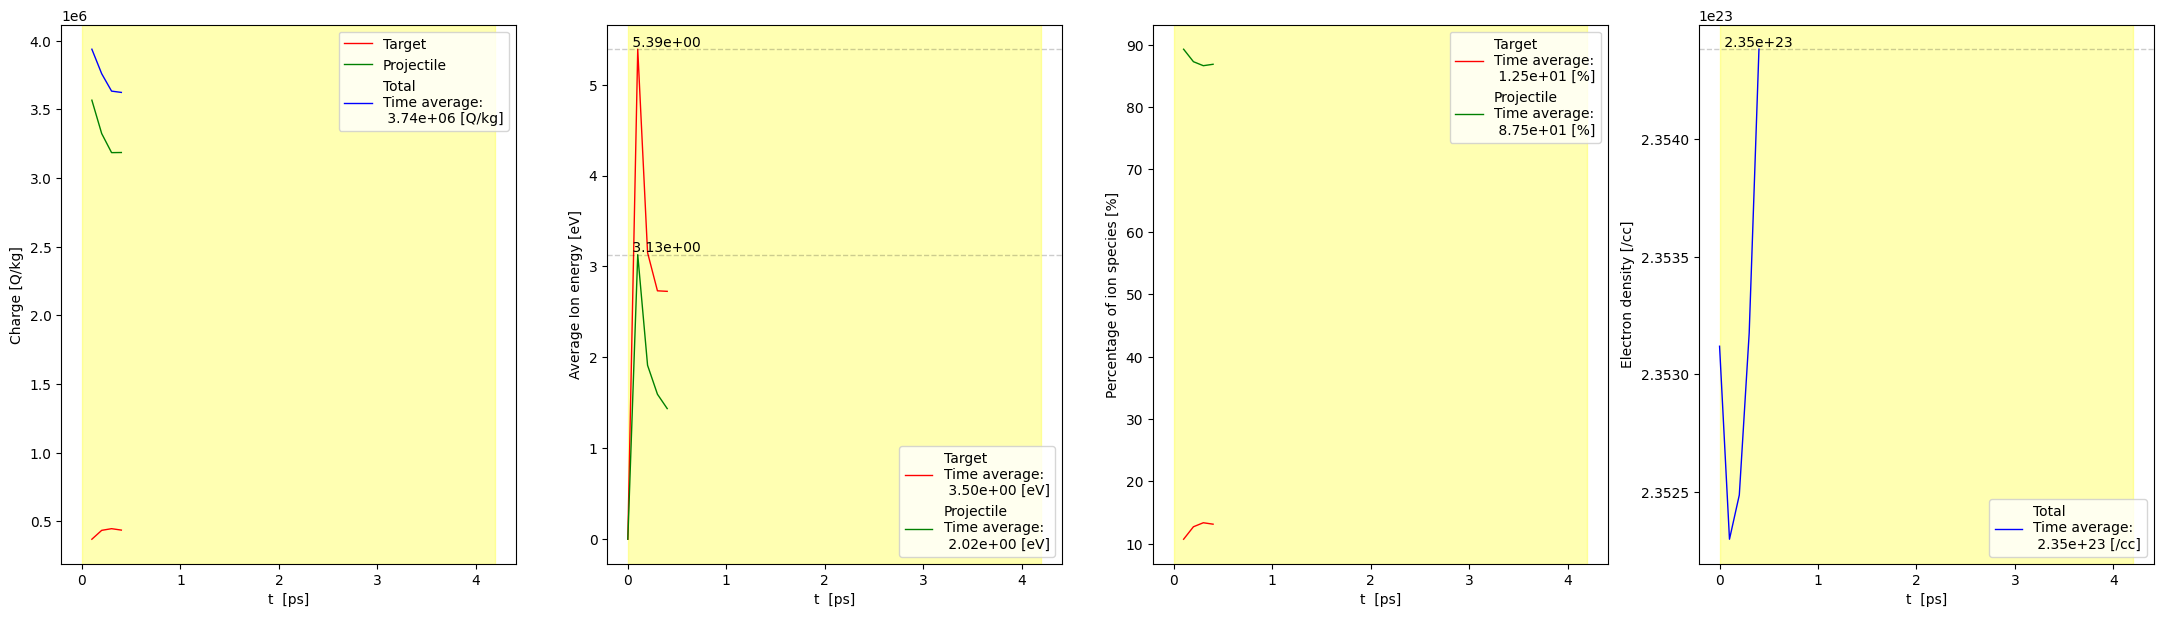

In [162]:
import matplotlib as mpl
#mpl.use('Cairo') #for png, ps, pdf, svg, ...
import matplotlib.pyplot as plt
import numpy as np
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
import glob
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec


print("\n\n#######################")
print("#### P4P_charge.py ####")
print("#######################\n")


# path= os.getcwd()
# d_name   = os.path.basename(path)
d_name = "Rat2_1BIN1"
os.makedirs('./Python/P4P_charge/'.format(d_name), exist_ok=True)

#テスト/本番設定
# operation = "test_1"
operation = "test_2"
# operation = "actual"
if operation == "test_1":
  l = 1
  file_path = "./{}/u0000.bin".format(d_name, i)
if operation == "test_2":
  l = 5
  file_path = "./{}/u0000.bin".format(d_name, i)
if operation == "actual":
  # l = 100
  l = len(glob.glob(f"{'./BIN1'}/*"))
  file_path = "./{}/u0000.bin".format(d_name, i)

print("file_number :",l)


#パラメータ(cell)
nxr1=100
nxr2=200
nxr3=700
nxr4=1200
nxr5=1250
ny=451
jj2=301

#パラメータ(cm to m)
rthick = 100e-7*1e-2
xleft = 200e-7*1e-2
xright = 150e-7*1e-2
finemesh = 60e-7*1e-2
y_out = 200e-7*1e-2

#grid(m)
grid_x = rthick/(nxr3-nxr2)
grid_y = finemesh/(jj2-1)

#速度と半径、計算領域の抽出
with open(file_path, "rb") as f:
  ttime = np.fromfile(f, dtype=np.float32, count=2)[1]
  nx, ny = np.fromfile(f, dtype=np.int32, count=2)
  # print("nx",nx,"ny",ny)
  x4 = np.fromfile(f, dtype=np.float32, count=nx+1)*1e-2-rthick
  y4 = np.fromfile(f, dtype=np.float32, count=ny+1)[1:]*1e-2
  u4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2
  v4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2
  rho = np.fromfile(f, dtype=np.float32, count=(nx) * (ny)).reshape((nx,ny), order='F')[:,1:]
v_impact = -np.min(u4)
print("impact_velocity:",v_impact*1e-3,"[km/s]")
projectile = np.where(u4[:,0] < 0)[0]
solid_ball_radius = (len(projectile)-1)*grid_x/2
print("solid_ball_radius: {:.2e} [m]".format(solid_ball_radius))
ts = 2*solid_ball_radius/(v_impact)
print("ts: {:.2e} [s]".format(ts))
target_density = rho[0,0]
projectile_density = rho[projectile[1],0]
print("target_density : {:.2e} [g/cc]".format(target_density))
print("projectile_density : {:.2e} [g/cc]".format(projectile_density))

python_xleft = min(x4)*1e9
python_xright = max(x4)*1e9
python_y_out = max(y4)*1e9
# python_xleft = (-rthick -xleft -(nxr2-nxr1)*grid_x)*1e9
# python_xright = ((nxr4-nxr3)*grid_x +xright)*1e9
# python_y_out = (finemesh +y_out)*1e9
print("xleft:",round(python_xleft,1),"[nm],  xright:",round(python_xright,1),"[nm], y_max:",round(python_y_out,1),"[nm]")


## 抽出したい範囲(cell number)
x_min = 0
x_max = nx
y_max = ny
x_nm_min = -200
x_nm_max = 200
y_nm_max = 200
# x_min = round(nxr3-1*solid_ball_radius/grid_x)
# x_max = round(nxr3+2*solid_ball_radius/grid_x)
# y_max = round(2*solid_ball_radius/grid_y)
## 抽出したい範囲(nm)
# x_nm_min = round(((x_min-nxr2)*grid_x-100e-9)*1e9,1)
# x_nm_max = round(((x_max-nxr2)*grid_x-100e-9)*1e9,1)
# y_nm_min = 0
# y_nm_max = round((y_max*grid_y)*1e9,1)

x_range = (x_min, x_max)
y_range = (0, y_max)

print("extract_xleft:",x_nm_min,"[nm], extract_xright:",x_nm_max,"[nm], extract_y_max:",y_nm_max,"[nm]")
print("If the extract region reaches the extended zone, this estimate of the extract resion is not precise.")


def read_binary_with_structure(file_path, x_range, y_range):

    with open(file_path, "rb") as f:
        # === 1. 時間を読み取る ===
        ttime = np.fromfile(f, dtype=np.float32, count=2)[1]

        # === 2. nx, ny を読み取る ===
        nx, ny = np.fromfile(f, dtype=np.int32, count=2)
        print("step_time:",ttime,"[s]")
        # print("nx",nx,"ny",ny)

        # 範囲インデックス
        x_min, x_max = x_range
        y_min, y_max = y_range
        # print("x_min",x_min,"x_max",x_max,"y_min",y_min,"y_max",y_max)
        # print("x_range",range(x_min, x_max))
        # === 3. x4, y4 の読み取り ===
        x4 = np.fromfile(f, dtype=np.float32, count=nx+1)*1e-2-rthick
        y4 = np.fromfile(f, dtype=np.float32, count=ny+1)[1:]*1e-2
        u4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2
        v4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2

        # print("x4_len",len(x4))
        # print("y4_len",len(y4))
        # print("x4",x4[0:3])
        # print("y4",y4[0:3])

        # === 4. 2次元配列 (rh4, p4, te4, ti4, zi4) の読み取り ===
        def read_2d_array():
            return np.fromfile(f, dtype=np.float32, count=(nx) * (ny)).reshape((nx,ny), order='F')[:,1:]
        rh4 = read_2d_array()
        p4 = read_2d_array()*1e-1
        te4 = read_2d_array()
        ti4 = read_2d_array()        
        zi4 = read_2d_array()
        # print("p4_shape",p4.shape)


        # === 5. mtldb (整数型2次元配列) の読み取り ===
        mtldb = np.fromfile(f, dtype=np.int32, count=(nx) * (ny)).reshape((nx,ny), order='F')[:,1:]

        # === 6. その他 (aaomtl, wlaserwrite, flsr) の読み取り ===
        aaomtl = np.fromfile(f, dtype=np.float32, count=3)
        wlaserwrite = np.fromfile(f, dtype=np.float32, count=1)[0]
        flsr = np.fromfile(f, dtype=np.float32, count=1)[0]
        # print("aaomtl",aaomtl)
        # print("wlaserwrite",wlaserwrite)
        # print("flsr",flsr)

        xc = np.zeros((nx, ny-1), dtype=np.float32)
        yc = np.zeros((nx, ny-1), dtype=np.float32)
        uc = np.zeros((nx, ny-1), dtype=np.float32)
        vc = np.zeros((nx, ny-1), dtype=np.float32)
        ent = np.zeros((nx, ny-1), dtype=np.float32)
        one = np.ones((nx, ny-1), dtype=np.float32)
        for j in range(0, ny-1):
          for i in range(0, nx):
            xc[i,j]=(x4[i]+x4[i+1])*0.5
            yc[i,j]=(y4[j]+y4[j+1])*0.5
            uc[i,j]=(u4[i,j]+u4[i+1,j]+u4[i,j+1]+u4[i+1,j+1])*0.25
            vc[i,j]=(v4[i,j]+v4[i+1,j]+v4[i,j+1]+v4[i+1,j+1])*0.25
            if mtldb[i,j] == 1 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[0]
            if mtldb[i,j] == 2 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[1]
            if mtldb[i,j] == 3 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[2]
        # print("xc_shape",xc.shape)
        # print("yc_shape",yc.shape)
        # print("xc",xc[0:3,0:3])
        # print("yc",yc[0:3,0:3])

        # 指定範囲を抽出
        xc = xc[x_min:x_max+1,y_min:y_max+1]
        yc = yc[x_min:x_max+1,y_min:y_max+1]
        ent = ent[x_min:x_max+1,y_min:y_max+1]
        rh4 = rh4[x_min:x_max+1, y_min:y_max+1]
        p4 = p4[x_min:x_max+1, y_min:y_max+1]
        te4 = te4[x_min:x_max+1, y_min:y_max+1]
        ti4 = ti4[x_min:x_max+1, y_min:y_max+1]
        zi4 = zi4[x_min:x_max+1, y_min:y_max+1]
        mtldb = mtldb[x_min:x_max+1, y_min:y_max+1]
        one = one[x_min:x_max+1, y_min:y_max+1]

        # print("xc_shape",xc.shape)
        # print("yc_shape",yc.shape)

    # データを辞書形式で返す
    return {
        "time": ttime,
        "x": xc,
        "y": yc,
        "u": u4,
        "v": v4,
        "rho": rh4,
        "en": ent,
        "P": p4,
        "te": te4,
        "ti": ti4,
        "zi": zi4,
        "mtl": mtldb,
        "Target_mol":aaomtl[1],
        "Projectile_mol":aaomtl[2],
        "ambience_mol": aaomtl[0],
        "wlaserwrite": wlaserwrite,
        "flsr": flsr,
        "one": one,
    }

#Output units
# x, y : 座標(m)
# u, v : 流速 (m/s)
# rho : 密度 (g/cc)
# en : 電子数密度(個/cc)
# P : 圧力 (Pa)
# te : 電子温度 (eV)
# ti : イオン温度(eV)
# zi : 電離度
# mtl : 物質追跡

#phisical const.
k = 1.38e-23
eV = 1.602e-19
F = 96485.3321

time = []
Target_q_all = []
Projectile_q_all = []
tot_q_all = []
Ion_T_Target_ave_all = []
Ion_T_Projectile_ave_all = []
Ion_R_Target_ave_all = []
Ion_R_Projectile_ave_all = []
Ion_e_Target_ave_all = []
Ion_e_Projectile_ave_all = []
electron_density_ave = []
Num_Ion_Target_all = []
Num_Ion_Projectile_all = []


print("\n----- start loading -----")
for i in np.arange(0,l,1):

  print('step:',i)
  print("file:",file_path)

  if operation == "test_1":
    file_path = "./{}/u0005.bin".format(d_name)
  if operation == "test_2":
    file_path = "./{}/u{:04d}.bin".format(d_name,i)
  if operation == "actual":
    file_path = "./{}/u{:04d}.bin".format(d_name,i)
  # データを読み取る(m to nm)
  data = read_binary_with_structure(file_path, x_range, y_range)
  # print(data)
  print('-------------------------')
  if data["time"] > 8*ts:
      print("The time is over ts")
      break
    
  time.append(data['time']*1e12)
  all_x = data['x']
  all_y = data['y']
  all_rho = data['rho']
  all_p = data['P']
  all_ed = data['en']
  all_e = data['te']
  all_T = data['ti']
  all_z = data['zi']
  mtl = data['mtl']
  Target_mol = data['Target_mol']
  Projectile_mol = data['Projectile_mol']

  ion = (all_rho < 5)
  solid = (all_rho >= 5)
  all_z[solid] = 0
    
  Target = (mtl == 2)
  Projectile = (mtl == 3)
    
  ##amount of Q
  #Extract para.
  Target_z = np.where(Target,all_z,np.nan)
  Projectile_z = np.where(Projectile,all_z,np.nan)
  Target_rho = np.where(Target,all_rho,np.nan)
  Projectile_rho = np.where(Projectile,all_rho,np.nan)
  Target_y = np.where(Target,all_y,np.nan)
  Projectile_y = np.where(Projectile,all_y,np.nan)

  Ion_Target = (all_z>0) & (mtl==2)
  Ion_Projectile = (all_z>0) & (mtl == 3)
   
  Ion_rho_Target = np.where(Ion_Target,all_rho,np.nan)
  Ion_rho_Projectile = np.where(Ion_Projectile,all_rho,np.nan)
  Target_T = np.where(Ion_Target,all_T,np.nan)
  Projectile_T = np.where(Ion_Projectile,all_T,np.nan)
  Ion_z_Target = np.where(Ion_Target,all_z,np.nan)
  Ion_z_Projectile = np.where(Ion_Projectile,all_z,np.nan)
  Target_e = np.where(Ion_Target,all_e,np.nan)
  Projectile_e = np.where(Ion_Projectile,all_e,np.nan)
  Target_ed = np.where(Ion_Target,all_ed,np.nan)
  Projectile_ed = np.where(Ion_Projectile,all_ed,np.nan)
  Ion_y_Target = np.where(Ion_Target,all_y,np.nan)
  Ion_y_Projectile = np.where(Ion_Projectile,all_y,np.nan)
  
  #sum up
  sum_Target_q =  np.nansum(2*np.pi*Ion_y_Target*1e2*(grid_x*1e2)*(grid_y*1e2)*Ion_rho_Target/Target_mol*Ion_z_Target*F)
  sum_Projectile_q = np.nansum(2*np.pi*Ion_y_Projectile*1e2*(grid_x*1e2)*(grid_y*1e2)*Ion_rho_Projectile/Projectile_mol*Ion_z_Projectile*F)
  sum_tot_q = sum_Target_q+sum_Projectile_q
      
  #append
  Target_q_all.append(sum_Target_q)
  Projectile_q_all.append(sum_Projectile_q)
  tot_q_all.append(sum_tot_q)

  #electlon density average
  electron_density_ave.append(np.nansum(2*np.pi*(all_y/grid_y)*all_ed)/np.sum(2*np.pi*(all_y/grid_y)*data["one"]))

  ##energy
  #Extract para.

  #Total mol for culc. ave.
  Target_mol_sum = np.nansum(2*np.pi*Ion_y_Target*1e2*(grid_x*1e2)*(grid_y*1e2)*Ion_rho_Target/Target_mol) #mol/cc
  Projectile_mol_sum = np.nansum(2*np.pi*Ion_y_Projectile*1e2*(grid_x*1e2)*(grid_y*1e2)*Ion_rho_Projectile/Projectile_mol)
  Target_ed_sum = np.nansum(2*np.pi*Ion_y_Target*1e2*(grid_x*1e2)*(grid_y*1e2)*Target_ed) #
  Projectile_ed_sum = np.nansum(2*np.pi*Ion_y_Projectile*1e2*(grid_x*1e2)*(grid_y*1e2)*Projectile_ed)

  #Culc. ave.T
  Ion_T_Target_ave = np.nansum(Target_T*(Ion_rho_Target*2*np.pi*Ion_y_Target*1e2*(grid_x*1e2)*(grid_y*1e2)/Target_mol)/Target_mol_sum) #integral(eV*(mol/cc) / (mol/cc))
  Ion_T_Projectile_ave = np.nansum(Projectile_T*(Ion_rho_Projectile*2*np.pi*Ion_y_Projectile*1e2*(grid_x*1e2)*(grid_y*1e2)/Projectile_mol)/Projectile_mol_sum)
  Ion_R_Target_ave = np.nansum((Ion_rho_Target/Target_mol*6.022e23)*(Ion_rho_Target*2*np.pi*Ion_y_Target*1e2*(grid_x*1e2)*(grid_y*1e2)/Target_mol)/Target_mol_sum) #integral(/cc)*(mol/cc) / (mol/cc))
  Ion_R_Projectile_ave = np.nansum((Ion_rho_Projectile/Projectile_mol*6.022e23)*(Ion_rho_Projectile*2*np.pi*Ion_y_Projectile*1e2*(grid_x*1e2)*(grid_y*1e2)/Projectile_mol)/Projectile_mol_sum)
  Ion_e_Target_ave = np.nansum(Target_e*(Target_ed*2*np.pi*Ion_y_Target*1e2*(grid_x*1e2)*(grid_y*1e2))/Target_ed_sum) #integral(eV*(/cc) / (/cc))
  Ion_e_Projectile_ave = np.nansum(Projectile_e*(Projectile_ed*2*np.pi*Ion_y_Projectile*1e2*(grid_x*1e2)*(grid_y*1e2))/Projectile_ed_sum)


  #append
  Ion_T_Target_ave_all.append(Ion_T_Target_ave)
  Ion_T_Projectile_ave_all.append(Ion_T_Projectile_ave)
  Ion_R_Target_ave_all.append(Ion_R_Target_ave)
  Ion_R_Projectile_ave_all.append(Ion_R_Projectile_ave)
  Ion_e_Target_ave_all.append(Ion_e_Target_ave)
  Ion_e_Projectile_ave_all.append(Ion_e_Projectile_ave)

  #Relative yield
  #Number of ions
  Num_Ion_Target = np.nansum(2*np.pi*Ion_y_Target*1e2*Ion_rho_Target/Target_mol*6.022e23)*grid_y*1e2*grid_x*1e2
  Num_Ion_Projectile = np.nansum(2*np.pi*Ion_y_Projectile*1e2*Ion_rho_Projectile/Projectile_mol*6.022e23)*grid_y*1e2*grid_x*1e2
  total_ions = Num_Ion_Target + Num_Ion_Projectile 
  if i ==0:
      total_ions=1

  Num_Ion_Target = Num_Ion_Target/total_ions*100
  Num_Ion_Projectile = Num_Ion_Projectile/total_ions*100

  
  #append
  Num_Ion_Target_all.append(Num_Ion_Target)
  Num_Ion_Projectile_all.append(Num_Ion_Projectile)


max_tot_q = max(tot_q_all)
max_Ion_T_Target_ave_all = max(Ion_T_Target_ave_all)
max_Ion_T_Projectile_ave_all = max(Ion_T_Projectile_ave_all)
max_electron_density_ave = max(electron_density_ave)
max_Num_Ion_Target_all = max(Num_Ion_Target_all)
max_Num_Ion_Projectile_all = max(Num_Ion_Projectile_all)

#time average
dt = np.zeros((len(time)), dtype=np.float32)
for i in np.arange(1,len(time),1):
  dt[i] = time[i] - time[i-1]
if dt[i] ==0:
    dt[i] =1
Ion_T_target_time_average = np.nansum(Ion_T_Target_ave_all * dt) / np.sum(dt)
Ion_T_projectile_time_average = np.nansum(Ion_T_Projectile_ave_all * dt) / np.sum(dt)
Ion_R_target_time_average = np.nansum(Ion_R_Target_ave_all * dt) / np.sum(dt)
Ion_R_projectile_time_average = np.nansum(Ion_R_Projectile_ave_all * dt) / np.sum(dt)
Ele_T_target_time_average = np.nansum(Ion_e_Target_ave_all * dt) / np.sum(dt)
Ele_T_projectile_time_average = np.nansum(Ion_e_Projectile_ave_all * dt) / np.sum(dt)
electron_density_time_average = np.nansum(electron_density_ave * dt) / np.sum(dt)
charge_time_average = np.nansum(tot_q_all * dt) / np.sum(dt)
Num_Ion_Target_time_average = np.nansum(Num_Ion_Target_all * dt) / np.sum(dt)
Num_Ion_Projectile_time_average = np.nansum(Num_Ion_Projectile_all * dt) / np.sum(dt)

print("target_mol:",Target_mol,"[g/mol]")
print("projectile_mol:",Projectile_mol,"[g/mol]")
print("Ion_target_time_average:",Ion_T_target_time_average,"[eV]")
print("Ion_projectile_time_average:",Ion_T_projectile_time_average,"[eV]")
print("Ion_R_target_time_average:",Ion_R_target_time_average,"[/cc]")
print("Ion_R_projectile_time_average:",Ion_R_projectile_time_average,"[/cc]")
print("Ele_target_time_average:",Ele_T_target_time_average,"[eV]")
print("Ele_projectile_time_average:",Ele_T_projectile_time_average,"[eV]")
print("electron_density_time_average:",electron_density_time_average,"[/cc]")

#plots
fig = plt.figure(figsize=(27,7))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

#ax1 time vs Q
ax1.axvspan(0, ts*1e12, color='yellow', alpha=0.3)
ax1.plot(time,Target_q_all, linewidth = 1.0,c="red",zorder=1,label="Target")
ax1.plot(time,Projectile_q_all, linewidth = 1.0,c="green",zorder=1,label="Projectile")
ax1.plot(time,tot_q_all, linewidth = 1.0,c="blue",zorder=1,label="Total\nTime average:\n {:.2e} [Q/kg]".format(charge_time_average))
ax1.axhline(max_tot_q, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax1.text(0,max_tot_q,"{: 5.2e}".format(max_tot_q),ha='left', va='bottom')
ax1.set_xlabel('t  [ps]')
ax1.set_ylabel('Ion yield [Q]')
ax1.legend(fontsize=10)

#ax2 time vs Erg
ax2.axvspan(0, ts*1e12, color='yellow', alpha=0.3)
ax2.plot(time,Ion_T_Target_ave_all, linewidth = 1.0,c="red",zorder=1,label="Target\nTime average:\n {:.2e} [eV]".format(Ion_T_target_time_average))
ax2.axhline(max_Ion_T_Target_ave_all, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax2.text(0,max_Ion_T_Target_ave_all,"{: 5.2e}".format(max_Ion_T_Target_ave_all),ha='left', va='bottom')
ax2.plot(time,Ion_T_Projectile_ave_all, linewidth = 1.0,c="green",zorder=1,label="Projectile\nTime average:\n {:.2e} [eV]".format(Ion_T_projectile_time_average))
ax2.axhline(max_Ion_T_Projectile_ave_all, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax2.text(0,max_Ion_T_Projectile_ave_all,"{: 5.2e}".format(max_Ion_T_Projectile_ave_all),ha='left', va='bottom')
ax2.set_xlabel('t  [ps]')
ax2.set_ylabel('Average Ion energy [eV]')
ax2.legend(fontsize=10)

#ax3 time vs %
ax3.axvspan(0, ts*1e12, color='yellow', alpha=0.3)
ax3.plot(time,Num_Ion_Target_all, linewidth = 1.0,c="red",zorder=1,label="Target\nTime average:\n {:.2e} [%]".format(Num_Ion_Target_time_average))
ax3.axhline(max_Num_Ion_Target_all, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax3.text(0,max_Num_Ion_Target_all,"{: 5.2e}".format(max_Num_Ion_Target_all),ha='left', va='bottom')
ax3.plot(time,Num_Ion_Projectile_all, linewidth = 1.0,c="green",zorder=1,label="Projectile\nTime average:\n {:.2e} [%]".format(Num_Ion_Projectile_time_average))
ax3.axhline(max_Num_Ion_Projectile_all, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax3.text(0,max_Num_Ion_Projectile_all,"{: 5.2e}".format(max_Num_Ion_Projectile_all),ha='left', va='bottom')
ax3.set_xlabel('t  [ps]')
ax3.set_ylabel('Percentage of ion species [%]')
ax3.legend(fontsize=10)


ax4.axvspan(0, ts*1e12, color='yellow', alpha=0.3)
ax4.plot(time,electron_density_ave, linewidth = 1.0,c="blue",zorder=1,label="Total\nTime average:\n {:.2e} [/cc]".format(electron_density_time_average))
ax4.axhline(max_electron_density_ave, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax4.text(0,max_electron_density_ave,"{: 5.2e}".format(max_electron_density_ave),ha='left', va='bottom')
ax4.set_xlabel('t  [ps]')
ax4.set_ylabel('Electron density [/cc]')
ax4.legend(fontsize=10)

if operation == "actual":
  #Savefig
  fig.savefig('./Python/P4P_charge/charge_{}.png'.format(d_name))



In [163]:
Target_q_all

[np.float32(nan),
 np.float32(370948.94),
 np.float32(435594.47),
 np.float32(447694.34),
 np.float32(437386.84)]



############################
#### P4P_charge+plot.py ####
############################

d_name :  Rat1_1BIN1      file_number : 302
impact_velocity: 17.800001 [km/s]
solid_ball_radius: 5.35e-08 [m]
ts: 6.01e-12 [s]
target_density : 1.24e+01 [g/cc]
projectile_density : 7.86e+00 [g/cc]
xleft: -320.0 [nm],  xright: 250.0 [nm], y_max: 260.0 [nm]
extract_xleft: -200 [nm], extract_xright: 200 [nm], extract_y_max: 200 [nm]
If the extract region reaches the extended zone, this estimate of the extract resion is not precise.

----- start loading -----
step: 0      file: ./Rat1_1BIN1/u0000.bin      time: 0.0 [s]
-------------------------
step: 1      file: ./Rat1_1BIN1/u0001.bin      time: 1.0038474e-13 [s]
-------------------------
step: 2      file: ./Rat1_1BIN1/u0002.bin      time: 2.0037987e-13 [s]
-------------------------
step: 3      file: ./Rat1_1BIN1/u0003.bin      time: 3.0044362e-13 [s]
-------------------------
step: 4      file: ./Rat1_1BIN1/u0004.bin      time: 4.0064276e-13 [s]
-

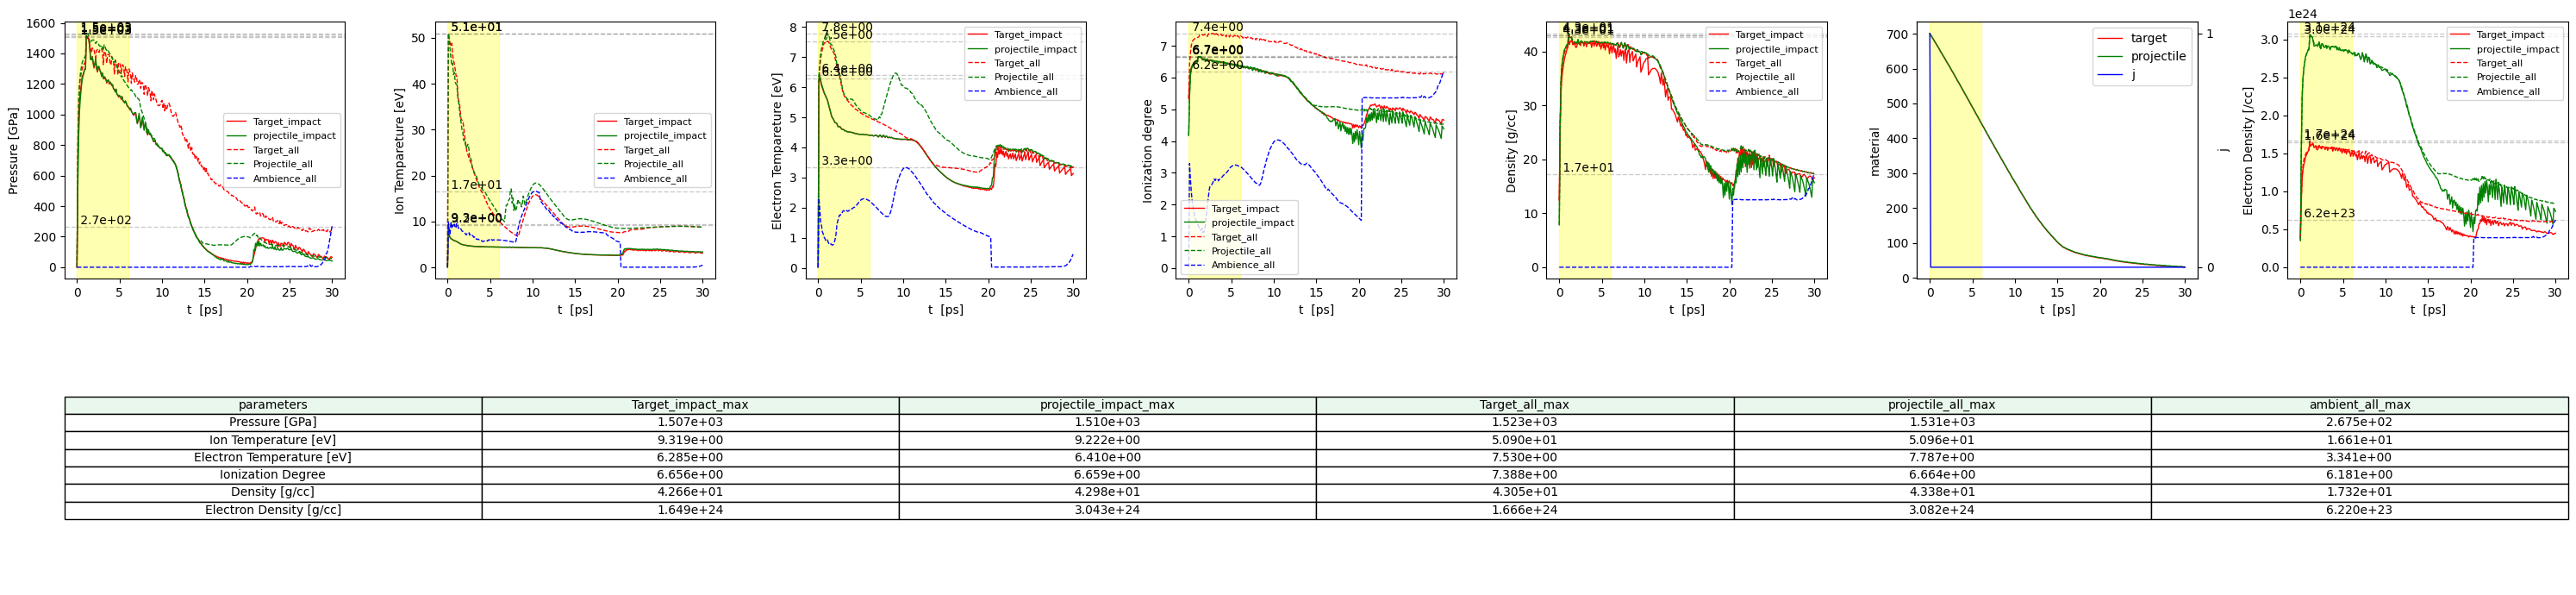

target_mol: 102.9055 [g/mol]
projectile_mol: 55.847 [g/mol]
Ion_target_time_average: 1.6324158 [eV]
Ion_projectile_time_average: 1.4646466 [eV]
Ion_R_target_time_average: 1.2164271e+22 [/cc]
Ion_R_projectile_time_average: 2.5308737e+22 [/cc]
Ele_target_time_average: 1.0700797 [eV]
Ele_projectile_time_average: 1.6404397 [eV]
electron_density_time_average: 2.0465776e+23 [/cc]


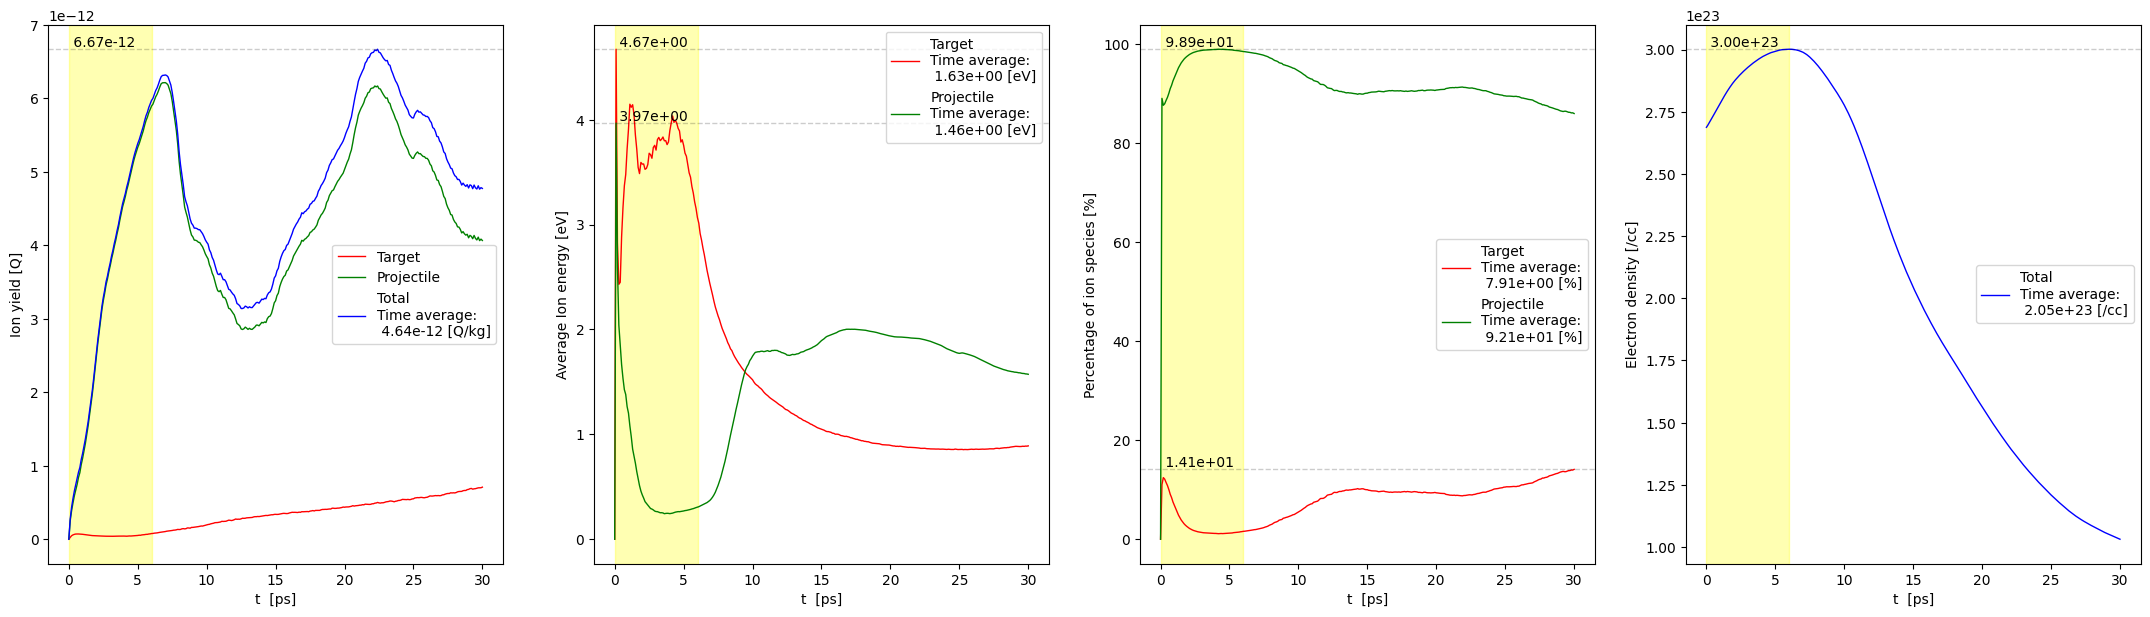

d_name :  Rat2_1BIN1      file_number : 302
impact_velocity: 23.000002 [km/s]
solid_ball_radius: 4.83e-08 [m]
ts: 4.20e-12 [s]
target_density : 1.24e+01 [g/cc]
projectile_density : 7.86e+00 [g/cc]
xleft: -320.0 [nm],  xright: 250.0 [nm], y_max: 260.0 [nm]
extract_xleft: -200 [nm], extract_xright: 200 [nm], extract_y_max: 200 [nm]
If the extract region reaches the extended zone, this estimate of the extract resion is not precise.

----- start loading -----
step: 0      file: ./Rat2_1BIN1/u0000.bin      time: 0.0 [s]
-------------------------
step: 1      file: ./Rat2_1BIN1/u0001.bin      time: 1.00717686e-13 [s]
-------------------------
step: 2      file: ./Rat2_1BIN1/u0002.bin      time: 2.0045256e-13 [s]
-------------------------
step: 3      file: ./Rat2_1BIN1/u0003.bin      time: 3.0084708e-13 [s]
-------------------------
step: 4      file: ./Rat2_1BIN1/u0004.bin      time: 4.0005743e-13 [s]
-------------------------
step: 5      file: ./Rat2_1BIN1/u0005.bin      time: 5.0007486e-

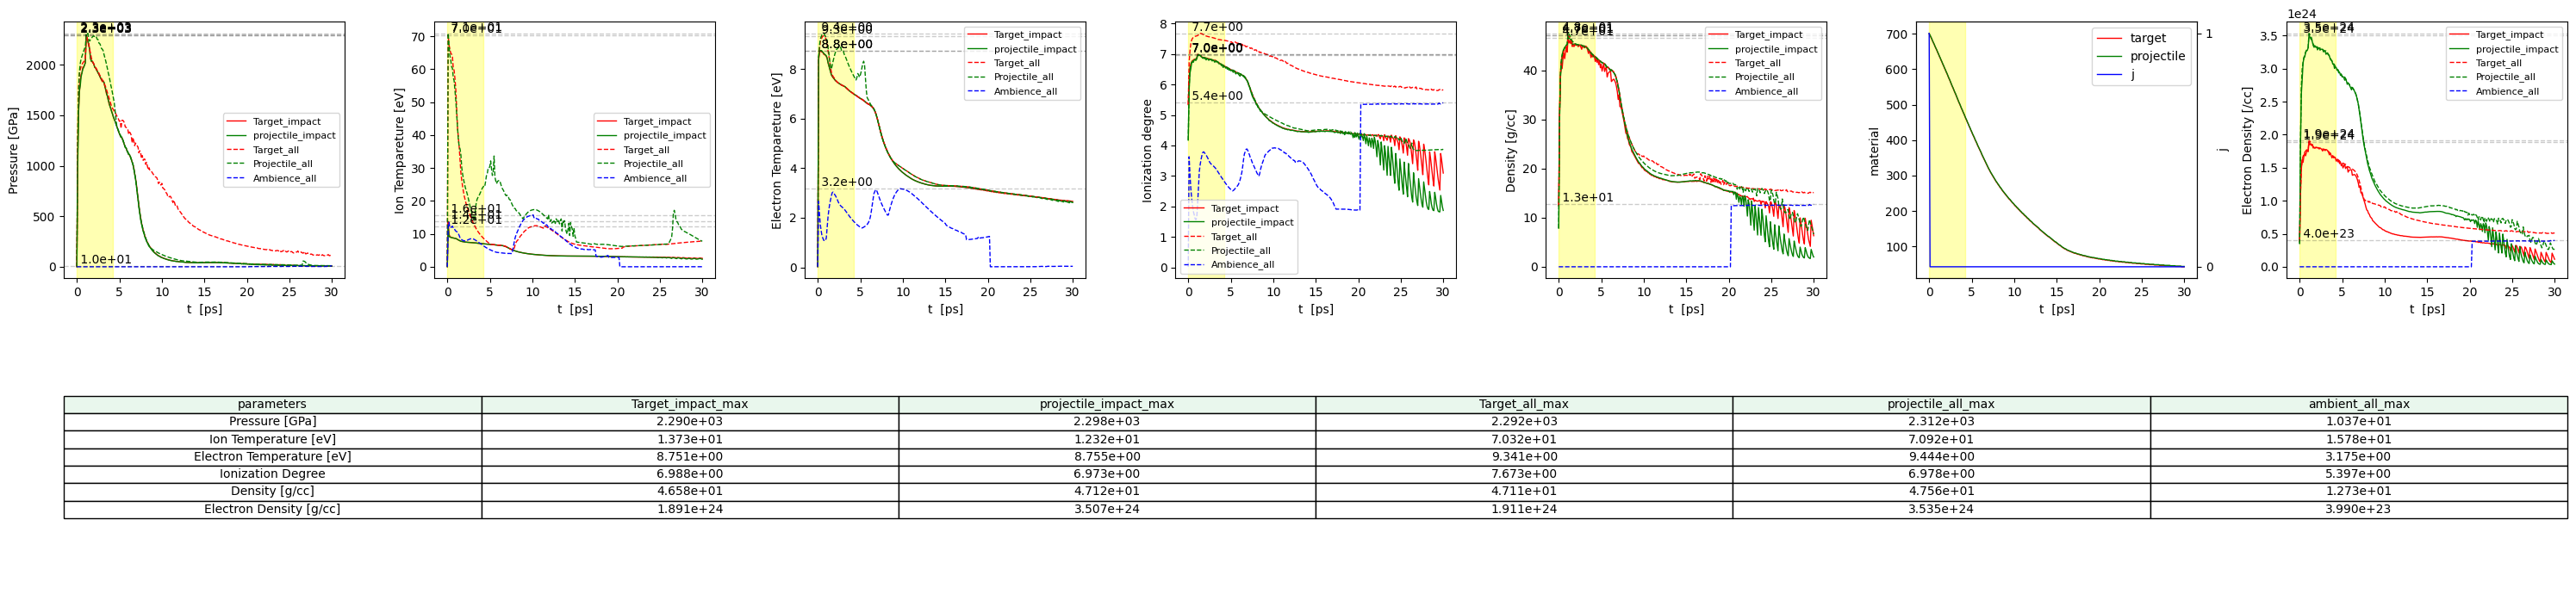

target_mol: 102.9055 [g/mol]
projectile_mol: 55.847 [g/mol]
Ion_target_time_average: 1.5176057 [eV]
Ion_projectile_time_average: 2.2431087 [eV]
Ion_R_target_time_average: 1.1530128e+22 [/cc]
Ion_R_projectile_time_average: 2.083407e+22 [/cc]
Ele_target_time_average: 1.3384554 [eV]
Ele_projectile_time_average: 2.1433418 [eV]
electron_density_time_average: 1.7359932e+23 [/cc]


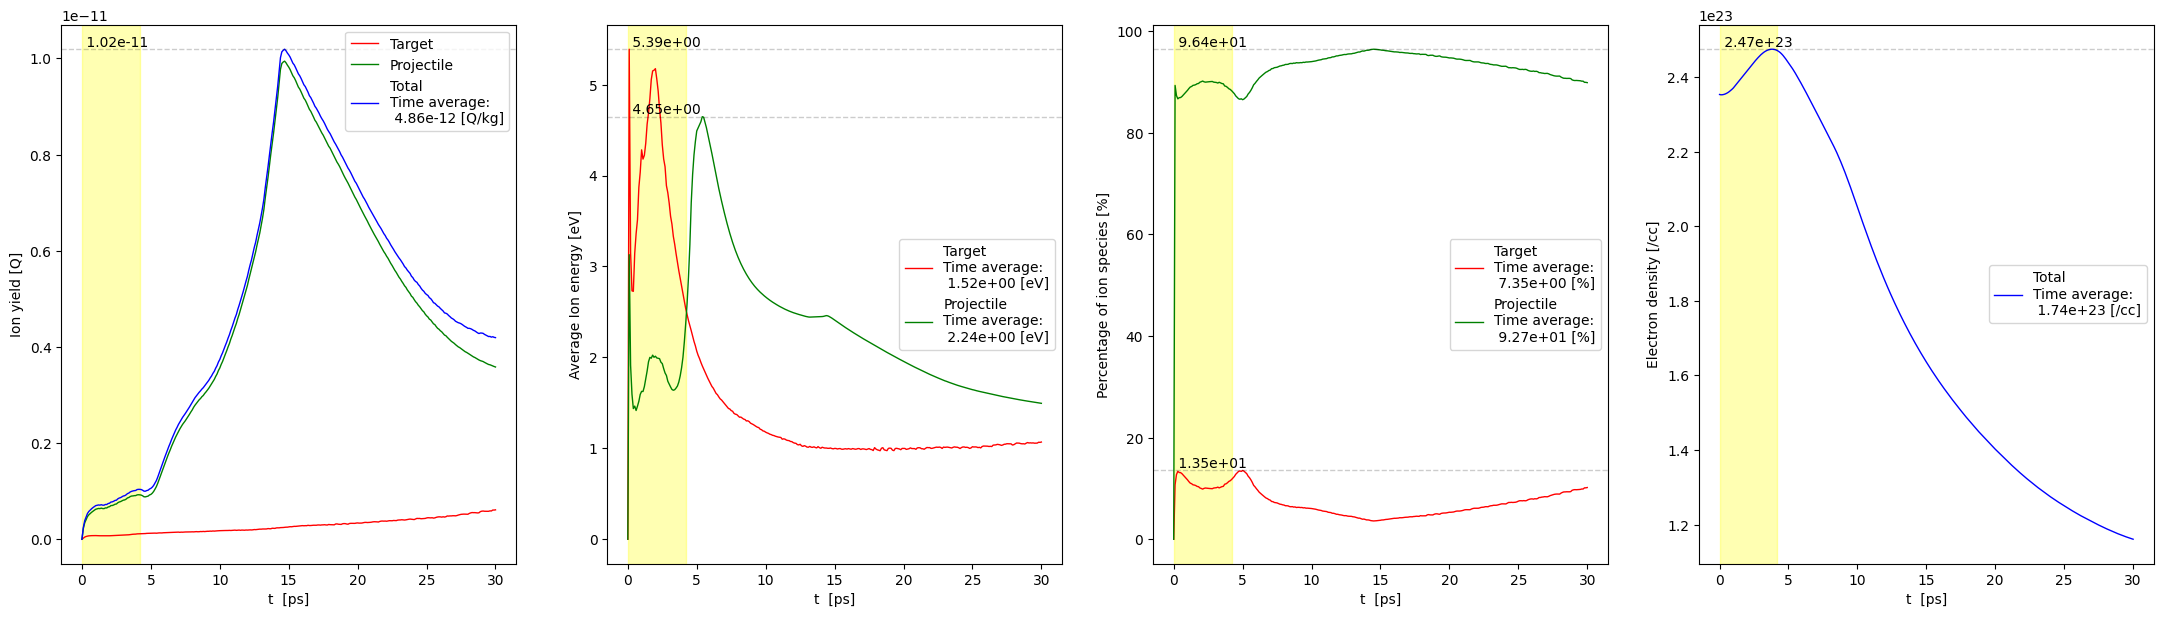

d_name :  Rat3_1BIN1      file_number : 302
impact_velocity: 27.300001 [km/s]
solid_ball_radius: 4.18e-08 [m]
ts: 3.06e-12 [s]
target_density : 1.24e+01 [g/cc]
projectile_density : 7.86e+00 [g/cc]
xleft: -320.0 [nm],  xright: 250.0 [nm], y_max: 260.0 [nm]
extract_xleft: -200 [nm], extract_xright: 200 [nm], extract_y_max: 200 [nm]
If the extract region reaches the extended zone, this estimate of the extract resion is not precise.

----- start loading -----
step: 0      file: ./Rat3_1BIN1/u0000.bin      time: 0.0 [s]
-------------------------
step: 1      file: ./Rat3_1BIN1/u0001.bin      time: 1.0032873e-13 [s]
-------------------------
step: 2      file: ./Rat3_1BIN1/u0002.bin      time: 2.0024425e-13 [s]
-------------------------
step: 3      file: ./Rat3_1BIN1/u0003.bin      time: 3.005594e-13 [s]
-------------------------
step: 4      file: ./Rat3_1BIN1/u0004.bin      time: 4.00184e-13 [s]
-------------------------
step: 5      file: ./Rat3_1BIN1/u0005.bin      time: 5.000479e-13 [s

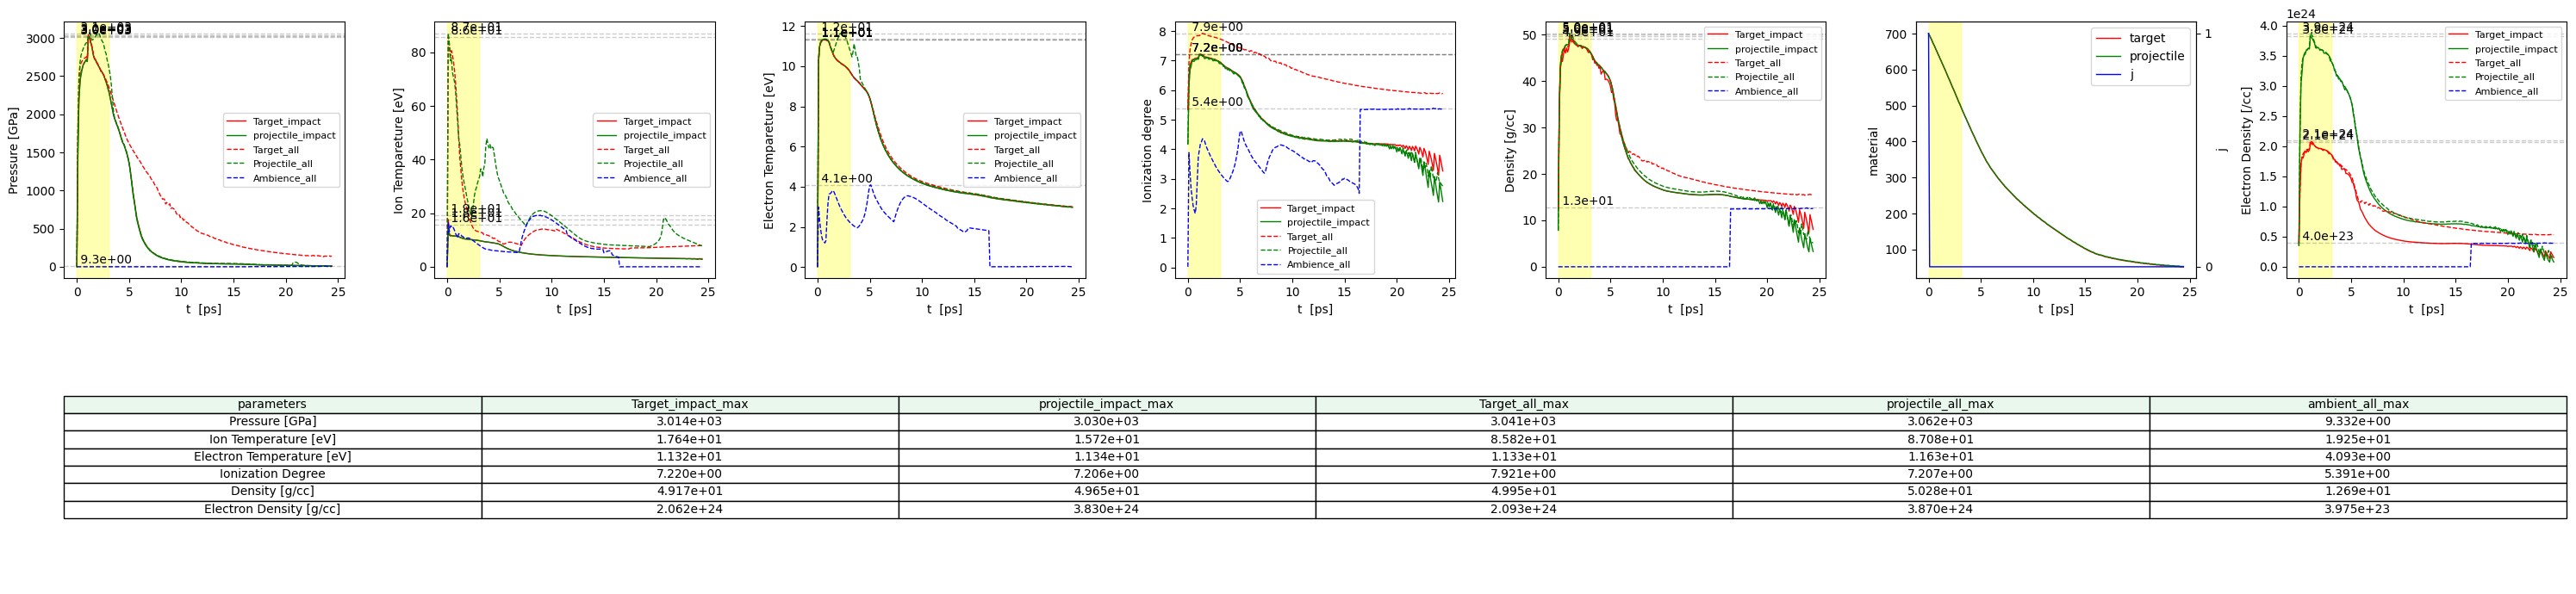

target_mol: 102.9055 [g/mol]
projectile_mol: 55.847 [g/mol]
Ion_target_time_average: 1.8387386 [eV]
Ion_projectile_time_average: 2.990943 [eV]
Ion_R_target_time_average: 9.610406e+21 [/cc]
Ion_R_projectile_time_average: 1.9304513e+22 [/cc]
Ele_target_time_average: 1.7740988 [eV]
Ele_projectile_time_average: 2.7818925 [eV]
electron_density_time_average: 1.8213441e+23 [/cc]


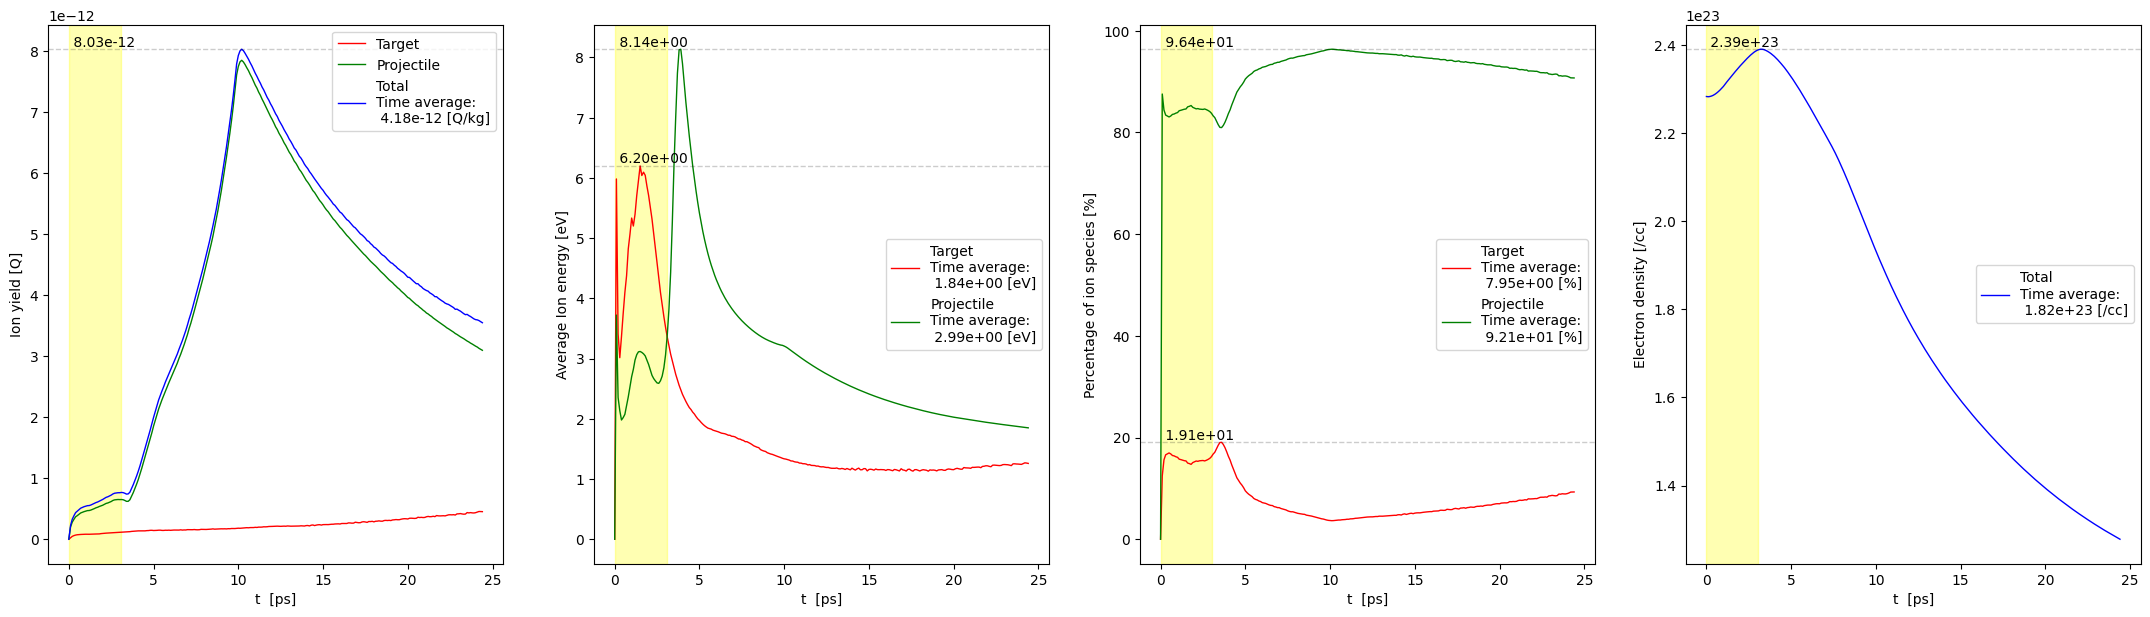

d_name :  Rat4_1BIN1      file_number : 302
impact_velocity: 33.600002 [km/s]
solid_ball_radius: 3.45e-08 [m]
ts: 2.05e-12 [s]
target_density : 1.24e+01 [g/cc]
projectile_density : 7.86e+00 [g/cc]
xleft: -320.0 [nm],  xright: 250.0 [nm], y_max: 260.0 [nm]
extract_xleft: -200 [nm], extract_xright: 200 [nm], extract_y_max: 200 [nm]
If the extract region reaches the extended zone, this estimate of the extract resion is not precise.

----- start loading -----
step: 0      file: ./Rat4_1BIN1/u0000.bin      time: 0.0 [s]
-------------------------
step: 1      file: ./Rat4_1BIN1/u0001.bin      time: 1.00398165e-13 [s]
-------------------------
step: 2      file: ./Rat4_1BIN1/u0002.bin      time: 2.0025142e-13 [s]
-------------------------
step: 3      file: ./Rat4_1BIN1/u0003.bin      time: 3.0067919e-13 [s]
-------------------------
step: 4      file: ./Rat4_1BIN1/u0004.bin      time: 4.0056183e-13 [s]
-------------------------
step: 5      file: ./Rat4_1BIN1/u0005.bin      time: 5.0058406e-

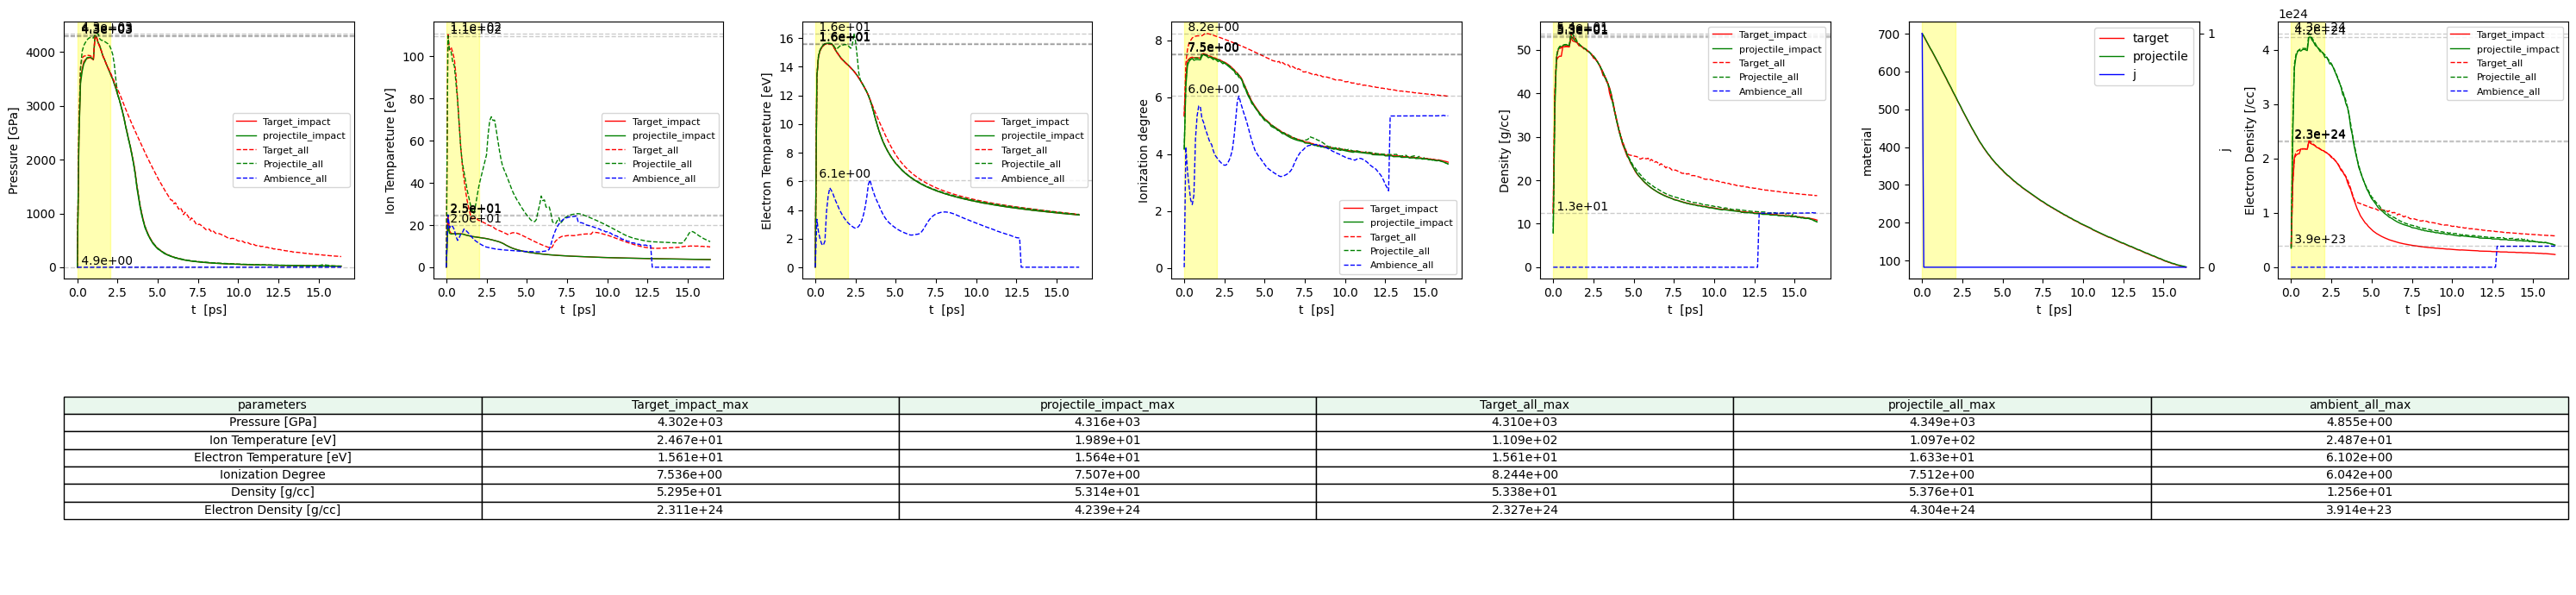

target_mol: 102.9055 [g/mol]
projectile_mol: 55.847 [g/mol]
Ion_target_time_average: 2.4252803 [eV]
Ion_projectile_time_average: 4.296482 [eV]
Ion_R_target_time_average: 8.0808094e+21 [/cc]
Ion_R_projectile_time_average: 1.98234e+22 [/cc]
Ele_target_time_average: 2.4813294 [eV]
Ele_projectile_time_average: 3.8983243 [eV]
electron_density_time_average: 1.9820248e+23 [/cc]


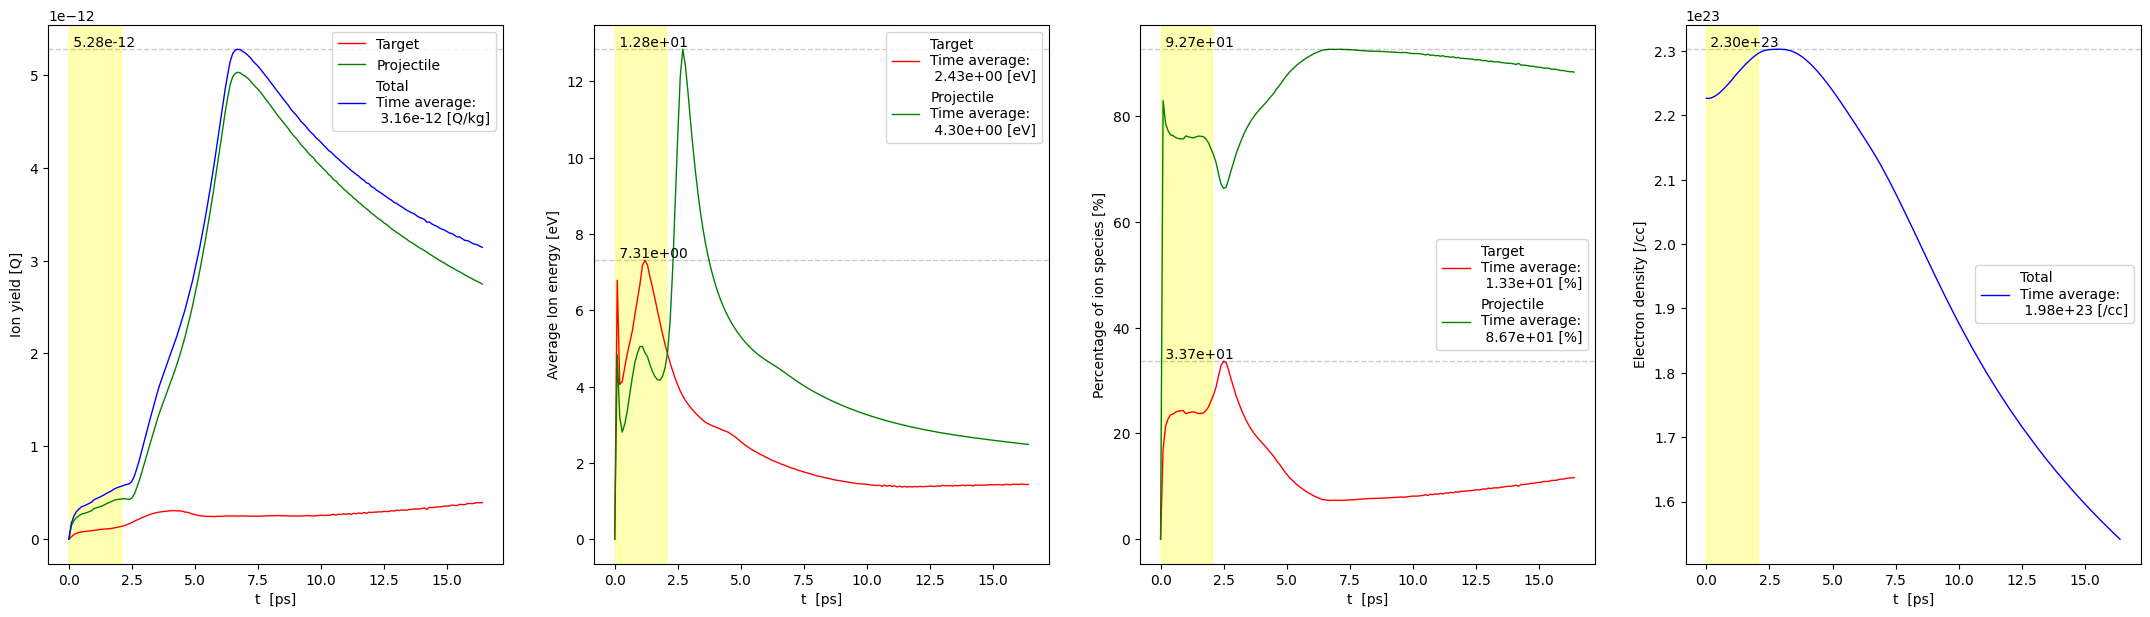

d_name :  Rat5_1BIN1      file_number : 303
impact_velocity: 44.000004 [km/s]
solid_ball_radius: 2.50e-08 [m]
ts: 1.14e-12 [s]
target_density : 1.24e+01 [g/cc]
projectile_density : 7.86e+00 [g/cc]
xleft: -320.0 [nm],  xright: 250.0 [nm], y_max: 260.0 [nm]
extract_xleft: -200 [nm], extract_xright: 200 [nm], extract_y_max: 200 [nm]
If the extract region reaches the extended zone, this estimate of the extract resion is not precise.

----- start loading -----
step: 0      file: ./Rat5_1BIN1/u0000.bin      time: 0.0 [s]
-------------------------
step: 1      file: ./Rat5_1BIN1/u0001.bin      time: 1.003216e-13 [s]
-------------------------
step: 2      file: ./Rat5_1BIN1/u0002.bin      time: 2.003014e-13 [s]
-------------------------
step: 3      file: ./Rat5_1BIN1/u0003.bin      time: 3.005491e-13 [s]
-------------------------
step: 4      file: ./Rat5_1BIN1/u0004.bin      time: 4.0046433e-13 [s]
-------------------------
step: 5      file: ./Rat5_1BIN1/u0005.bin      time: 5.00102e-13 [s]

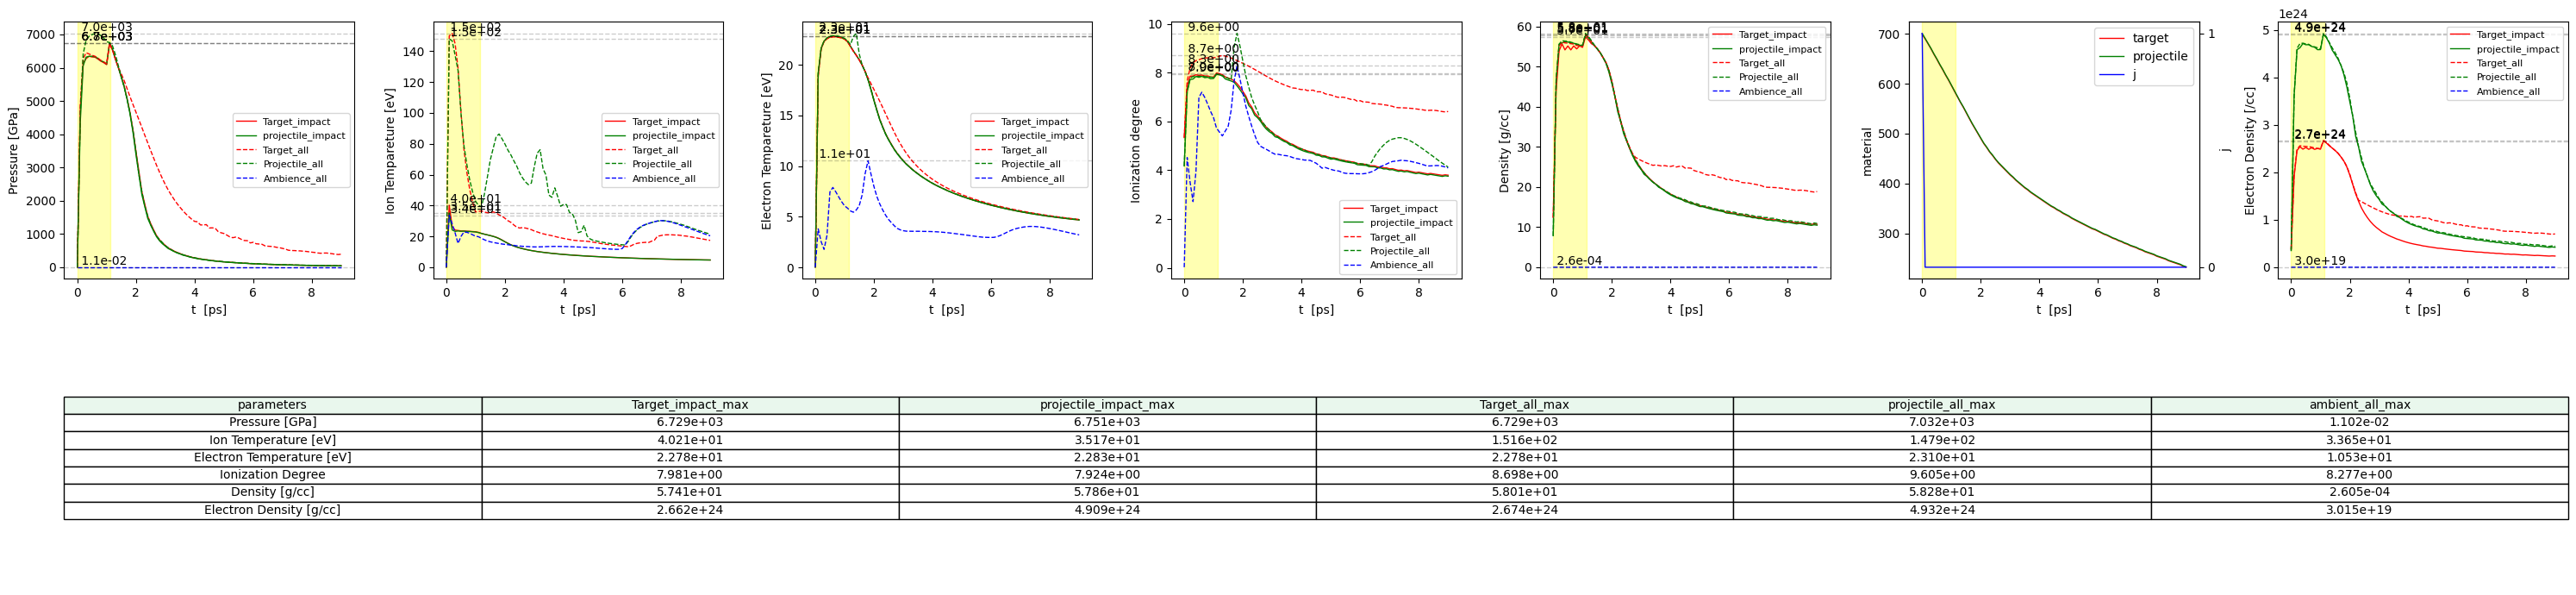

target_mol: 102.9055 [g/mol]
projectile_mol: 55.847 [g/mol]
Ion_target_time_average: 3.4493432 [eV]
Ion_projectile_time_average: 6.8763766 [eV]
Ion_R_target_time_average: 1.1027133e+22 [/cc]
Ion_R_projectile_time_average: 2.1904216e+22 [/cc]
Ele_target_time_average: 3.4324734 [eV]
Ele_projectile_time_average: 6.03899 [eV]
electron_density_time_average: 2.1536837e+23 [/cc]


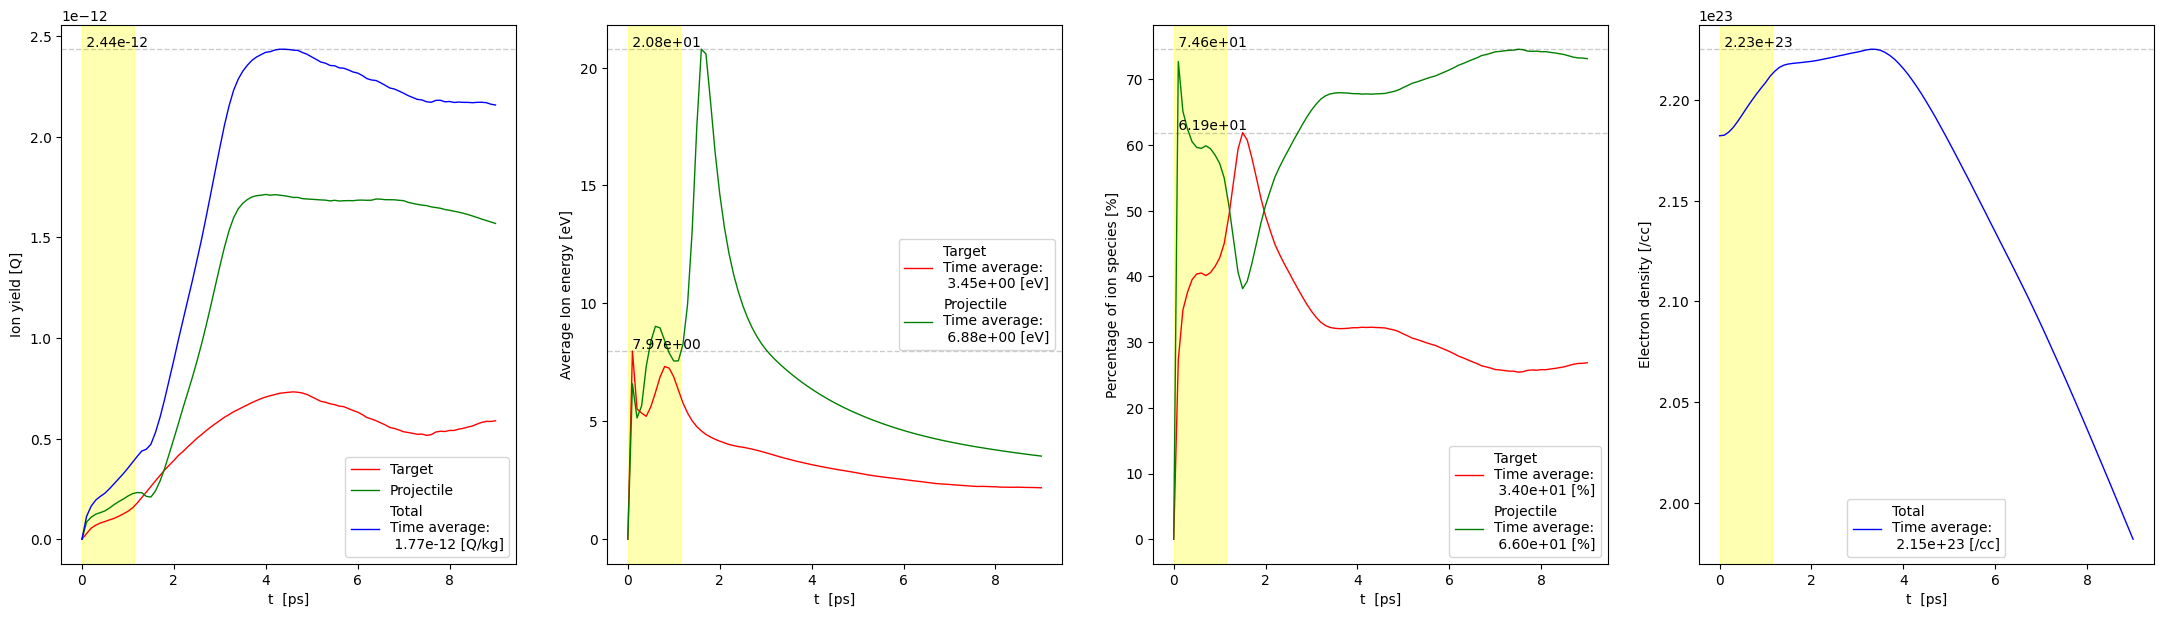

In [196]:
import matplotlib as mpl
#mpl.use('Cairo') #for png, ps, pdf, svg, ...
import matplotlib.pyplot as plt
import numpy as np
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
import glob
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec


print("\n\n############################")
print("#### P4P_charge+plot.py ####")
print("############################\n")


# path= os.getcwd()
# d_name   = os.path.basename(path)

for k in range(1,6,1):
    d_name = "Rat{}_1BIN1".format(k)
    # os.makedirs('./Python/P4P_charge/'.format(d_name), exist_ok=True)
    # os.makedirs('./Python/P4P_plots/'.format(d_name), exist_ok=True)

    #テスト/本番設定
    # operation = "test_1"
    # operation = "test_2"
    operation = "actual"
    if operation == "test_1":
      l = 1
      file_path = "./{}/u0000.bin".format(d_name)
    if operation == "test_2":
      l = 25
      file_path = "./{}/u0000.bin".format(d_name)
    if operation == "actual":
      # l = 100
      l = len(glob.glob(f"{'./{}'.format(d_name)}/*"))
      file_path = "./{}/u0000.bin".format(d_name, i)
    
    print("d_name : ",d_name,"     file_number :",l)
    
    
    #パラメータ(cell)
    nxr1=100
    nxr2=200
    nxr3=700
    nxr4=1200
    nxr5=1250
    ny=451
    jj2=301
    
    #パラメータ(cm to m)
    rthick = 100e-7*1e-2
    xleft = 200e-7*1e-2
    xright = 150e-7*1e-2
    finemesh = 60e-7*1e-2
    y_out = 200e-7*1e-2
    
    #grid(m)
    grid_x = rthick/(nxr3-nxr2)
    grid_y = finemesh/(jj2-1)
    
    #速度と半径、計算領域の抽出
    with open(file_path, "rb") as f:
      ttime = np.fromfile(f, dtype=np.float32, count=2)[1]
      nx, ny = np.fromfile(f, dtype=np.int32, count=2)
      # print("nx",nx,"ny",ny)
      x4 = np.fromfile(f, dtype=np.float32, count=nx+1)*1e-2-rthick
      y4 = np.fromfile(f, dtype=np.float32, count=ny+1)[1:]*1e-2
      u4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2
      v4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2
      rho = np.fromfile(f, dtype=np.float32, count=(nx) * (ny)).reshape((nx,ny), order='F')[:,1:]
    v_impact = -np.min(u4)
    print("impact_velocity:",v_impact*1e-3,"[km/s]")
    projectile = np.where(u4[:,0] < 0)[0]
    solid_ball_radius = (len(projectile)-1)*grid_x/2
    print("solid_ball_radius: {:.2e} [m]".format(solid_ball_radius))
    ts = 2*solid_ball_radius/(v_impact)
    print("ts: {:.2e} [s]".format(ts))
    target_density = rho[0,0]
    projectile_density = rho[projectile[1],0]
    print("target_density : {:.2e} [g/cc]".format(target_density))
    print("projectile_density : {:.2e} [g/cc]".format(projectile_density))
    
    python_xleft = min(x4)*1e9
    python_xright = max(x4)*1e9
    python_y_out = max(y4)*1e9
    # python_xleft = (-rthick -xleft -(nxr2-nxr1)*grid_x)*1e9
    # python_xright = ((nxr4-nxr3)*grid_x +xright)*1e9
    # python_y_out = (finemesh +y_out)*1e9
    print("xleft:",round(python_xleft,1),"[nm],  xright:",round(python_xright,1),"[nm], y_max:",round(python_y_out,1),"[nm]")
    
    
    ## 抽出したい範囲(cell number)
    x_min = 0
    x_max = nx
    y_max = ny
    x_nm_min = -200
    x_nm_max = 200
    y_nm_max = 200
    # x_min = round(nxr3-1*solid_ball_radius/grid_x)
    # x_max = round(nxr3+2*solid_ball_radius/grid_x)
    # y_max = round(2*solid_ball_radius/grid_y)
    ## 抽出したい範囲(nm)
    # x_nm_min = round(((x_min-nxr2)*grid_x-100e-9)*1e9,1)
    # x_nm_max = round(((x_max-nxr2)*grid_x-100e-9)*1e9,1)
    # y_nm_min = 0
    # y_nm_max = round((y_max*grid_y)*1e9,1)
    
    x_range = (x_min, x_max)
    y_range = (0, y_max)
    
    print("extract_xleft:",x_nm_min,"[nm], extract_xright:",x_nm_max,"[nm], extract_y_max:",y_nm_max,"[nm]")
    print("If the extract region reaches the extended zone, this estimate of the extract resion is not precise.")
    
    
    def read_binary_with_structure(file_path, x_range, y_range):
    
        with open(file_path, "rb") as f:
            # === 1. 時間を読み取る ===
            ttime = np.fromfile(f, dtype=np.float32, count=2)[1]
    
            # === 2. nx, ny を読み取る ===
            nx, ny = np.fromfile(f, dtype=np.int32, count=2)
            # print("nx",nx,"ny",ny)
    
            # 範囲インデックス
            x_min, x_max = x_range
            y_min, y_max = y_range
            # print("x_min",x_min,"x_max",x_max,"y_min",y_min,"y_max",y_max)
            # print("x_range",range(x_min, x_max))
            # === 3. x4, y4 の読み取り ===
            x4 = np.fromfile(f, dtype=np.float32, count=nx+1)*1e-2-rthick
            y4 = np.fromfile(f, dtype=np.float32, count=ny+1)[1:]*1e-2
            u4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2
            v4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2
    
            # print("x4_len",len(x4))
            # print("y4_len",len(y4))
            # print("x4",x4[0:3])
            # print("y4",y4[0:3])
    
            # === 4. 2次元配列 (rh4, p4, te4, ti4, zi4) の読み取り ===
            def read_2d_array():
                return np.fromfile(f, dtype=np.float32, count=(nx) * (ny)).reshape((nx,ny), order='F')[:,1:]
            rh4 = read_2d_array()
            p4 = read_2d_array()*1e-1
            te4 = read_2d_array()
            ti4 = read_2d_array()        
            zi4 = read_2d_array()
            # print("p4_shape",p4.shape)
    
    
            # === 5. mtldb (整数型2次元配列) の読み取り ===
            mtldb = np.fromfile(f, dtype=np.int32, count=(nx) * (ny)).reshape((nx,ny), order='F')[:,1:]
    
            # === 6. その他 (aaomtl, wlaserwrite, flsr) の読み取り ===
            aaomtl = np.fromfile(f, dtype=np.float32, count=3)
            wlaserwrite = np.fromfile(f, dtype=np.float32, count=1)[0]
            flsr = np.fromfile(f, dtype=np.float32, count=1)[0]
            # print("aaomtl",aaomtl)
            # print("wlaserwrite",wlaserwrite)
            # print("flsr",flsr)
    
            xc = np.zeros((nx, ny-1), dtype=np.float32)
            yc = np.zeros((nx, ny-1), dtype=np.float32)
            uc = np.zeros((nx, ny-1), dtype=np.float32)
            vc = np.zeros((nx, ny-1), dtype=np.float32)
            ent = np.zeros((nx, ny-1), dtype=np.float32)
            one = np.ones((nx, ny-1), dtype=np.float32)
            for j in range(0, ny-1):
              for i in range(0, nx):
                xc[i,j]=(x4[i]+x4[i+1])*0.5
                yc[i,j]=(y4[j]+y4[j+1])*0.5
                uc[i,j]=(u4[i,j]+u4[i+1,j]+u4[i,j+1]+u4[i+1,j+1])*0.25
                vc[i,j]=(v4[i,j]+v4[i+1,j]+v4[i,j+1]+v4[i+1,j+1])*0.25
                if mtldb[i,j] == 1 :
                  ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[0]
                if mtldb[i,j] == 2 :
                  ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[1]
                if mtldb[i,j] == 3 :
                  ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[2]
            # print("xc_shape",xc.shape)
            # print("yc_shape",yc.shape)
            # print("xc",xc[0:3,0:3])
            # print("yc",yc[0:3,0:3])
    
            # 指定範囲を抽出
            xc = xc[x_min:x_max+1,y_min:y_max+1]
            yc = yc[x_min:x_max+1,y_min:y_max+1]
            ent = ent[x_min:x_max+1,y_min:y_max+1]
            rh4 = rh4[x_min:x_max+1, y_min:y_max+1]
            p4 = p4[x_min:x_max+1, y_min:y_max+1]
            te4 = te4[x_min:x_max+1, y_min:y_max+1]
            ti4 = ti4[x_min:x_max+1, y_min:y_max+1]
            zi4 = zi4[x_min:x_max+1, y_min:y_max+1]
            mtldb = mtldb[x_min:x_max+1, y_min:y_max+1]
            one = one[x_min:x_max+1, y_min:y_max+1]
    
            # print("xc_shape",xc.shape)
            # print("yc_shape",yc.shape)
    
        # データを辞書形式で返す
        return {
            "time": ttime,
            "x": xc,
            "y": yc,
            "u": u4,
            "v": v4,
            "rho": rh4,
            "en": ent,
            "P": p4,
            "te": te4,
            "ti": ti4,
            "zi": zi4,
            "mtl": mtldb,
            "Target_mol":aaomtl[1],
            "Projectile_mol":aaomtl[2],
            "ambience_mol": aaomtl[0],
            "wlaserwrite": wlaserwrite,
            "flsr": flsr,
            "one": one,
        }
    
    #Output units
    # x, y : 座標(m)
    # u, v : 流速 (m/s)
    # rho : 密度 (g/cc)
    # en : 電子数密度(個/cc)
    # P : 圧力 (Pa)
    # te : 電子温度 (eV)
    # ti : イオン温度(eV)
    # zi : 電離度
    # mtl : 物質追跡
    
    #phisical const.
    k = 1.38e-23
    eV = 1.602e-19
    F = 96485.3321
    
    time = []
    Target_q_all = []
    Projectile_q_all = []
    tot_q_all = []
    Ion_T_Target_ave_all = []
    Ion_T_Projectile_ave_all = []
    Ion_R_Target_ave_all = []
    Ion_R_Projectile_ave_all = []
    Ion_e_Target_ave_all = []
    Ion_e_Projectile_ave_all = []
    electron_density_ave = []
    Num_Ion_Target_all = []
    Num_Ion_Projectile_all = []


    all_maxp = []
    Target_impact_maxp = []
    projectile_impact_maxp = []
    Target_all_maxp = []
    projectile_all_maxp = []
    ambience_all_maxp = []
    
    all_maxi = []
    Target_impact_maxi = []
    projectile_impact_maxi = []
    Target_all_maxi = []
    projectile_all_maxi = []
    ambience_all_maxi = []
    
    all_maxe = []
    Target_impact_maxe = []
    projectile_impact_maxe = []
    Target_all_maxe = []
    projectile_all_maxe = []
    ambience_all_maxe = []
    
    all_maxz = []
    Target_impact_maxz = []
    projectile_impact_maxz = []
    Target_all_maxz = []
    projectile_all_maxz = []
    ambience_all_maxz = []
    
    all_maxr = []
    Target_impact_maxr = []
    projectile_impact_maxr = []
    Target_all_maxr = []
    projectile_all_maxr = []
    ambience_all_maxr = []
    
    all_maxed = []
    Target_impact_maxed = []
    projectile_impact_maxed = []
    Target_all_maxed = []
    projectile_all_maxed = []
    ambience_all_maxed = []
    
    Target_1 =[]
    projectile_1 = []
    i_1 = []
    
    print("\n----- start loading -----")
    for i in np.arange(0,l,1):
      if operation == "test_1":
        file_path = "./{}/u0005.bin".format(d_name)
      if operation == "test_2":
        file_path = "./{}/u{:04d}.bin".format(d_name,i)
      if operation == "actual":
        file_path = "./{}/u{:04d}.bin".format(d_name,i)
      # データを読み取る(m to nm)
      data = read_binary_with_structure(file_path, x_range, y_range)
      # print(data)
      print('step:',i,"     file:",file_path,"     time:",data['time'],"[s]")
      print('-------------------------')
      if data["time"] > 8*ts:
          print("The time is over ts")
          break
        
      time.append(data['time']*1e12)
      all_x = data['x']
      all_y = data['y']
      all_rho = data['rho']
      all_p = data['P']
      all_ed = data['en']
      all_e = data['te']
      all_T = data['ti']
      all_z = data['zi']
      mtl = data['mtl']
      Target_mol = data['Target_mol']
      Projectile_mol = data['Projectile_mol']



      ##plot.py
      for x in np.arange(0,nx-2,1):
        if mtl[x,1] == 2  and mtl[x+1,1] == 3:
          Target_impact = x
          projectile_impact = x+1
          j = 0
        elif mtl[x,1] == 2  and mtl[x+1,1] == 1:
          Target_impact = x
          j = 1
        elif mtl[x,1] == 1  and mtl[x+1,1] == 3:
          projectile_impact = x+1
          j = 1
      Target_all = np.where(mtl == 2)
      projectile_all = np.where(mtl == 3)
      ambience_all = np.where(mtl == 1)
      # 空の場合
      if Target_all[0].size == 0:
        Target_all = np.array([0])
      if  projectile_all[0].size == 0:
         projectile_all = np.array([0])
      if ambience_all[0].size == 0:
        ambience_all = np.array([0])
    
      all_p = data['P']
      all_maxp.append(np.max(all_p)*1e-9)
      Target_impact_maxp.append(all_p[Target_impact,1]*1e-9)
      projectile_impact_maxp.append(all_p[projectile_impact,1]*1e-9)
      Target_all_maxp.append(np.max(all_p[Target_all])*1e-9)
      projectile_all_maxp.append(np.max(all_p[projectile_all])*1e-9)
      ambience_all_maxp.append(np.max(all_p[ambience_all])*1e-9)
    
      all_r = data['rho']
      all_maxr.append(np.max(all_r))
      Target_impact_maxr.append(all_r[Target_impact,1])
      projectile_impact_maxr.append(all_r[projectile_impact,1])
      Target_all_maxr.append(np.max(all_r[Target_all]))
      projectile_all_maxr.append(np.max(all_r[projectile_all]))
      ambience_all_maxr.append(np.max(all_r[ambience_all]))
    
      all_i = data['ti']
      all_maxi.append(np.max(all_i))
      Target_impact_maxi.append(all_i[Target_impact,1])
      projectile_impact_maxi.append(all_i[projectile_impact,1])
      Target_all_maxi.append(np.max(all_i[Target_all]))
      projectile_all_maxi.append(np.max(all_i[projectile_all]))
      ambience_all_maxi.append(np.max(all_i[ambience_all]))
    
      all_e = data['te']
      all_maxe.append(np.max(all_e))
      Target_impact_maxe.append(all_e[Target_impact,1])
      projectile_impact_maxe.append(all_e[projectile_impact,1])
      Target_all_maxe.append(np.max(all_e[Target_all]))
      projectile_all_maxe.append(np.max(all_e[projectile_all]))
      ambience_all_maxe.append(np.max(all_e[ambience_all]))
    
      all_z = data['zi']
      all_maxz.append(np.max(all_z))
      Target_impact_maxz.append(all_z[Target_impact,1])
      projectile_impact_maxz.append(all_z[projectile_impact,1])
      Target_all_maxz.append(np.max(all_z[Target_all]))
      projectile_all_maxz.append(np.max(all_z[projectile_all]))
      ambience_all_maxz.append(np.max(all_z[ambience_all]))
    
      all_ed = data['en']
      all_maxed.append(np.max(all_ed))
      Target_impact_maxed.append(all_ed[Target_impact,1])
      projectile_impact_maxed.append(all_ed[projectile_impact,1])
      Target_all_maxed.append(np.max(all_ed[Target_all]))
      projectile_all_maxed.append(np.max(all_ed[projectile_all]))
      ambience_all_maxed.append(np.max(all_ed[ambience_all]))
    
      projectile_1.append(projectile_impact)
      Target_1.append(Target_impact)
      i_1.append(j)


      ##charge.py
      ion = (all_rho < 5)
      solid = (all_rho >= 5)
      all_z[solid] = 0
        
      Target = (mtl == 2)
      Projectile = (mtl == 3)
        
      ##amount of Q
      #Extract para.
      Target_z = np.where(Target,all_z,np.nan)
      Projectile_z = np.where(Projectile,all_z,np.nan)
      Target_rho = np.where(Target,all_rho,np.nan)
      Projectile_rho = np.where(Projectile,all_rho,np.nan)
      Target_y = np.where(Target,all_y,np.nan)
      Projectile_y = np.where(Projectile,all_y,np.nan)
    
      Ion_Target = (all_z>0) & (mtl==2)
      Ion_Projectile = (all_z>0) & (mtl == 3)
       
      Ion_rho_Target = np.where(Ion_Target,all_rho,np.nan)
      Ion_rho_Projectile = np.where(Ion_Projectile,all_rho,np.nan)
      Target_T = np.where(Ion_Target,all_T,np.nan)
      Projectile_T = np.where(Ion_Projectile,all_T,np.nan)
      Ion_z_Target = np.where(Ion_Target,all_z,np.nan)
      Ion_z_Projectile = np.where(Ion_Projectile,all_z,np.nan)
      Target_e = np.where(Ion_Target,all_e,np.nan)
      Projectile_e = np.where(Ion_Projectile,all_e,np.nan)
      Target_ed = np.where(Ion_Target,all_ed,np.nan)
      Projectile_ed = np.where(Ion_Projectile,all_ed,np.nan)
      Ion_y_Target = np.where(Ion_Target,all_y,np.nan)
      Ion_y_Projectile = np.where(Ion_Projectile,all_y,np.nan)
      
      #sum up
      sum_Target_q =  np.nansum(2*np.pi*Ion_y_Target*1e2*(grid_x*1e2)*(grid_y*1e2)*Ion_rho_Target/Target_mol*Ion_z_Target*F)
      sum_Projectile_q = np.nansum(2*np.pi*Ion_y_Projectile*1e2*(grid_x*1e2)*(grid_y*1e2)*Ion_rho_Projectile/Projectile_mol*Ion_z_Projectile*F)
      sum_tot_q = sum_Target_q+sum_Projectile_q
          
      #append
      Target_q_all.append(sum_Target_q)
      Projectile_q_all.append(sum_Projectile_q)
      tot_q_all.append(sum_tot_q)
    
      #electlon density average
      electron_density_ave.append(np.nansum(2*np.pi*(all_y/grid_y)*all_ed)/np.sum(2*np.pi*(all_y/grid_y)*data["one"]))
    
      ##energy
      #Extract para.
    
      #Total mol for culc. ave.
      Target_mol_sum = np.nansum(2*np.pi*Ion_y_Target*1e2*(grid_x*1e2)*(grid_y*1e2)*Ion_rho_Target/Target_mol) #mol/cc
      Projectile_mol_sum = np.nansum(2*np.pi*Ion_y_Projectile*1e2*(grid_x*1e2)*(grid_y*1e2)*Ion_rho_Projectile/Projectile_mol)
      Target_ed_sum = np.nansum(2*np.pi*Ion_y_Target*1e2*(grid_x*1e2)*(grid_y*1e2)*Target_ed) #
      Projectile_ed_sum = np.nansum(2*np.pi*Ion_y_Projectile*1e2*(grid_x*1e2)*(grid_y*1e2)*Projectile_ed)
    
      #Culc. ave.T
      Ion_T_Target_ave = np.nansum(Target_T*(Ion_rho_Target*2*np.pi*Ion_y_Target*1e2*(grid_x*1e2)*(grid_y*1e2)/Target_mol)/Target_mol_sum) #integral(eV*(mol/cc) / (mol/cc))
      Ion_T_Projectile_ave = np.nansum(Projectile_T*(Ion_rho_Projectile*2*np.pi*Ion_y_Projectile*1e2*(grid_x*1e2)*(grid_y*1e2)/Projectile_mol)/Projectile_mol_sum)
      Ion_R_Target_ave = np.nansum((Ion_rho_Target/Target_mol*6.022e23)*(Ion_rho_Target*2*np.pi*Ion_y_Target*1e2*(grid_x*1e2)*(grid_y*1e2)/Target_mol)/Target_mol_sum) #integral(/cc)*(mol/cc) / (mol/cc))
      Ion_R_Projectile_ave = np.nansum((Ion_rho_Projectile/Projectile_mol*6.022e23)*(Ion_rho_Projectile*2*np.pi*Ion_y_Projectile*1e2*(grid_x*1e2)*(grid_y*1e2)/Projectile_mol)/Projectile_mol_sum)
      Ion_e_Target_ave = np.nansum(Target_e*(Target_ed*2*np.pi*Ion_y_Target*1e2*(grid_x*1e2)*(grid_y*1e2))/Target_ed_sum) #integral(eV*(/cc) / (/cc))
      Ion_e_Projectile_ave = np.nansum(Projectile_e*(Projectile_ed*2*np.pi*Ion_y_Projectile*1e2*(grid_x*1e2)*(grid_y*1e2))/Projectile_ed_sum)
    
    
      #append
      Ion_T_Target_ave_all.append(Ion_T_Target_ave)
      Ion_T_Projectile_ave_all.append(Ion_T_Projectile_ave)
      Ion_R_Target_ave_all.append(Ion_R_Target_ave)
      Ion_R_Projectile_ave_all.append(Ion_R_Projectile_ave)
      Ion_e_Target_ave_all.append(Ion_e_Target_ave)
      Ion_e_Projectile_ave_all.append(Ion_e_Projectile_ave)
    
      #Relative yield
      #Number of ions
      Num_Ion_Target = np.nansum(2*np.pi*Ion_y_Target*1e2*Ion_rho_Target/Target_mol*6.022e23)*grid_y*1e2*grid_x*1e2
      Num_Ion_Projectile = np.nansum(2*np.pi*Ion_y_Projectile*1e2*Ion_rho_Projectile/Projectile_mol*6.022e23)*grid_y*1e2*grid_x*1e2
      total_ions = Num_Ion_Target + Num_Ion_Projectile 
      if i ==0:
          total_ions=1
    
      Num_Ion_Target = Num_Ion_Target/total_ions*100
      Num_Ion_Projectile = Num_Ion_Projectile/total_ions*100
    
      #append
      Num_Ion_Target_all.append(Num_Ion_Target)
      Num_Ion_Projectile_all.append(Num_Ion_Projectile)
      
    
    max_all_maxp = max(all_maxp)
    max_Target_impact_maxp = max(Target_impact_maxp)
    max_projectile_impact_maxp = max(projectile_impact_maxp)
    max_Target_all_maxp = max(Target_all_maxp)
    max_projectile_all_maxp = max(projectile_all_maxp)
    max_ambience_all_maxp = max(ambience_all_maxp)
    
    max_all_maxi = max(all_maxi)
    max_Target_impact_maxi = max(Target_impact_maxi)
    max_projectile_impact_maxi = max(projectile_impact_maxi)
    max_Target_all_maxi = max(Target_all_maxi)
    max_projectile_all_maxi = max(projectile_all_maxi)
    max_ambience_all_maxi = max(ambience_all_maxi)
    
    max_all_maxe =  max(all_maxe)
    max_Target_impact_maxe = max(Target_impact_maxe)
    max_projectile_impact_maxe = max(projectile_impact_maxe)
    max_Target_all_maxe = max(Target_all_maxe)
    max_projectile_all_maxe = max(projectile_all_maxe)
    max_ambience_all_maxe = max(ambience_all_maxe)
    
    max_all_maxz = max(all_maxz)
    max_Target_impact_maxz = max(Target_impact_maxz)
    max_projectile_impact_maxz = max(projectile_impact_maxz)
    max_Target_all_maxz = max(Target_all_maxz)
    max_projectile_all_maxz = max(projectile_all_maxz)
    max_ambience_all_maxz = max(ambience_all_maxz)
    
    max_all_maxr = max(all_maxr)
    max_Target_impact_maxr = max(Target_impact_maxr)
    max_projectile_impact_maxr = max(projectile_impact_maxr)
    max_Target_all_maxr = max(Target_all_maxr)
    max_projectile_all_maxr = max(projectile_all_maxr)
    max_ambience_all_maxr = max(ambience_all_maxr)
    
    max_all_maxed = max(all_maxed)
    max_Target_impact_maxed = max(Target_impact_maxed)
    max_projectile_impact_maxed = max(projectile_impact_maxed)
    max_Target_all_maxed = max(Target_all_maxed)
    max_projectile_all_maxed = max(projectile_all_maxed)
    max_ambience_all_maxed = max(ambience_all_maxed)
    
    
    Target_impact = np.array([max_Target_impact_maxp,max_Target_impact_maxi, max_Target_impact_maxe, max_Target_impact_maxz, max_Target_impact_maxr, max_Target_impact_maxed])
    Projectile_impact = np.array([max_projectile_impact_maxp,max_projectile_impact_maxi, max_projectile_impact_maxe, max_projectile_impact_maxz, max_projectile_impact_maxr, max_projectile_impact_maxed])
    Target_all = np.array([max_Target_all_maxp,max_Target_all_maxi, max_Target_all_maxe, max_Target_all_maxz, max_Target_all_maxr, max_Target_all_maxed])
    Projectile_all = np.array([max_projectile_all_maxp,max_projectile_all_maxi, max_projectile_all_maxe, max_projectile_all_maxz, max_projectile_all_maxr, max_projectile_all_maxed])
    ambience_all = np.array([max_ambience_all_maxp,max_ambience_all_maxi, max_ambience_all_maxe, max_ambience_all_maxz, max_ambience_all_maxr, max_ambience_all_maxed])
    
    
    # 各配列の有効数字を変換
    def to_scientific_notation(arr):
        return [f"{x:.3e}" for x in arr]
    Target_impact = to_scientific_notation(Target_impact)
    Projectile_impact = to_scientific_notation(Projectile_impact)
    Target_all = to_scientific_notation(Target_all)
    Projectile_all = to_scientific_notation(Projectile_all)
    ambience_all = to_scientific_notation(ambience_all)
    
    label = ['Pressure [GPa]', 'Ion Temperature [eV]', 'Electron Temperature [eV]', 'Ionization Degree','Density [g/cc]','Electron Density [g/cc]' ]
    columns  = ['parameters', 'Target_impact_max', 'projectile_impact_max', 'Target_all_max', 'projectile_all_max', 'ambient_all_max']
    texts = [[] for i in range(len(label))]
    for i in range(len(label)):
      texts[i].append(label[i])
      texts[i].append(Target_impact[i])
      texts[i].append(Projectile_impact[i])
      texts[i].append(Target_all[i])
      texts[i].append(Projectile_all[i])
      texts[i].append(ambience_all[i])
    print(columns)
    print(texts)
    
    # Set up a pyplot figure
    fig = plt.figure(figsize=(30,7), tight_layout=True)
    gs = gridspec.GridSpec(2, 7)
    ax1=fig.add_subplot(gs[0,0])
    ax2=fig.add_subplot(gs[0,1])
    ax3=fig.add_subplot(gs[0,2])
    ax4=fig.add_subplot(gs[0,3])
    ax5=fig.add_subplot(gs[1,:])
    ax6=fig.add_subplot(gs[0,4])
    ax7=fig.add_subplot(gs[0,5])
    ax9=fig.add_subplot(gs[0,6])
    ax8 = ax7.twinx()
    
    ax5.axis('off')
    table = ax5.table(cellText=texts, colLabels=columns, cellLoc='center',loc='center',colColours=['#e9f7ed','#e9f7ed', '#e9f7ed', '#e9f7ed','#e9f7ed','#e9f7ed'])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    
    
    # set axis labels
    ax1.set_xlabel('t  [ps]')
    ax1.set_ylabel('Pressure [GPa]')
    ax1.axvspan(0, ts*1e12, color='yellow', alpha=0.3)
    
    ax1.plot(time,Target_impact_maxp, linewidth = 1.0,c="red",zorder=1,label="Target_impact")
    ax1.plot(time,projectile_impact_maxp, linewidth = 1.0,c="green",zorder=1,label="projectile_impact")
    ax1.plot(time,Target_all_maxp, linewidth = 1.0,c="red",zorder=1,label="Target_all",ls='--')
    ax1.plot(time,projectile_all_maxp, linewidth = 1.0,c="green",zorder=1,label="Projectile_all",ls='--')
    ax1.plot(time,ambience_all_maxp, linewidth = 1.0,c="blue",zorder=1,label="Ambience_all",ls='--')
    
    ax1.axhline(max_Target_impact_maxp, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax1.axhline(max_projectile_impact_maxp, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax1.axhline(max_Target_all_maxp, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax1.axhline(max_projectile_all_maxp, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax1.axhline(max_ambience_all_maxp, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    
    ax1.text(0,max_Target_impact_maxp,"{: 5.1e}".format(max_Target_impact_maxp),ha='left', va='bottom')
    ax1.text(0,max_projectile_impact_maxp,"{: 5.1e}".format(max_projectile_impact_maxp),ha='left', va='bottom')
    ax1.text(0,max_Target_all_maxp,"{: 5.1e}".format(max_Target_all_maxp),ha='left', va='bottom')
    ax1.text(0,max_projectile_all_maxp,"{: 5.1e}".format(max_projectile_all_maxp),ha='left', va='bottom')
    ax1.text(0,max_ambience_all_maxp,"{: 5.1e}".format(max_ambience_all_maxp),ha='left', va='bottom')
    
    ax1.legend(fontsize=8)
    #ax1.set_aspect ('equal')
    
    
    # set axis labels
    ax2.set_xlabel('t  [ps]')
    ax2.set_ylabel('Ion Tempareture [eV]')
    ax2.axvspan(0, ts*1e12, color='yellow', alpha=0.3)
    
    ax2.plot(time,Target_impact_maxi, linewidth = 1.0,c="red",zorder=1,label="Target_impact")
    ax2.plot(time,projectile_impact_maxi, linewidth = 1.0,c="green",zorder=1,label="projectile_impact")
    ax2.plot(time,Target_all_maxi, linewidth = 1.0,c="red",zorder=1,label="Target_all",ls='--')
    ax2.plot(time,projectile_all_maxi, linewidth = 1.0,c="green",zorder=1,label="Projectile_all",ls='--')
    ax2.plot(time,ambience_all_maxi, linewidth = 1.0,c="blue",zorder=1,label="Ambience_all",ls='--')
    
    ax2.axhline(max_Target_impact_maxi, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax2.axhline(max_projectile_impact_maxi, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax2.axhline(max_Target_all_maxi, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax2.axhline(max_projectile_all_maxi, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax2.axhline(max_ambience_all_maxi, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    
    ax2.text(0,max_Target_impact_maxi,"{: 5.1e}".format(max_Target_impact_maxi),ha='left', va='bottom')
    ax2.text(0,max_projectile_impact_maxi,"{: 5.1e}".format(max_projectile_impact_maxi),ha='left', va='bottom')
    ax2.text(0,max_Target_all_maxi,"{: 5.1e}".format(max_Target_all_maxi),ha='left', va='bottom')
    ax2.text(0,max_projectile_all_maxi,"{: 5.1e}".format(max_projectile_all_maxi),ha='left', va='bottom')
    ax2.text(0,max_ambience_all_maxi,"{: 5.1e}".format(max_ambience_all_maxi),ha='left', va='bottom')
    
    ax2.legend(fontsize=8)
    #ax2.set_aspect ('equal')
    
    
    # set axis labels
    ax3.set_xlabel('t  [ps]')
    ax3.set_ylabel('Electron Tempareture [eV]')
    ax3.axvspan(0, ts*1e12, color='yellow', alpha=0.3)
    
    
    ax3.plot(time,Target_impact_maxe, linewidth = 1.0,c="red",zorder=1,label="Target_impact")
    ax3.plot(time,projectile_impact_maxe, linewidth = 1.0,c="green",zorder=1,label="projectile_impact")
    ax3.plot(time,Target_all_maxe, linewidth = 1.0,c="red",zorder=1,label="Target_all",ls='--')
    ax3.plot(time,projectile_all_maxe, linewidth = 1.0,c="green",zorder=1,label="Projectile_all",ls='--')
    ax3.plot(time,ambience_all_maxe, linewidth = 1.0,c="blue",zorder=1,label="Ambience_all",ls='--')
    
    ax3.axhline(max_Target_impact_maxe, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax3.axhline(max_projectile_impact_maxe, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax3.axhline(max_Target_all_maxe, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax3.axhline(max_projectile_all_maxe, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax3.axhline(max_ambience_all_maxe, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    
    ax3.text(0,max_Target_impact_maxe,"{: 5.1e}".format(max_Target_impact_maxe),ha='left', va='bottom')
    ax3.text(0,max_projectile_impact_maxe,"{: 5.1e}".format(max_projectile_impact_maxe),ha='left', va='bottom')
    ax3.text(0,max_Target_all_maxe,"{: 5.1e}".format(max_Target_all_maxe),ha='left', va='bottom')
    ax3.text(0,max_projectile_all_maxe,"{: 5.1e}".format(max_projectile_all_maxe),ha='left', va='bottom')
    ax3.text(0,max_ambience_all_maxe,"{: 5.1e}".format(max_ambience_all_maxe),ha='left', va='bottom')
    
    ax3.legend(fontsize=8)
    #ax3.set_aspect ('equal')
    
    # set axis labels
    ax4.set_xlabel('t  [ps]')
    ax4.set_ylabel('Ionization degree')
    ax4.axvspan(0, ts*1e12, color='yellow', alpha=0.3)
    
    
    ax4.plot(time,Target_impact_maxz, linewidth = 1.0,c="red",zorder=1,label="Target_impact")
    ax4.plot(time,projectile_impact_maxz, linewidth = 1.0,c="green",zorder=1,label="projectile_impact")
    ax4.plot(time,Target_all_maxz, linewidth = 1.0,c="red",zorder=1,label="Target_all",ls='--')
    ax4.plot(time,projectile_all_maxz, linewidth = 1.0,c="green",zorder=1,label="Projectile_all",ls='--')
    ax4.plot(time,ambience_all_maxz, linewidth = 1.0,c="blue",zorder=1,label="Ambience_all",ls='--')
    
    ax4.axhline(max_Target_impact_maxz, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax4.axhline(max_projectile_impact_maxz, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax4.axhline(max_Target_all_maxz, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax4.axhline(max_projectile_all_maxz, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax4.axhline(max_ambience_all_maxz, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    
    ax4.text(0,max_Target_impact_maxz,"{: 5.1e}".format(max_Target_impact_maxz),ha='left', va='bottom')
    ax4.text(0,max_projectile_impact_maxz,"{: 5.1e}".format(max_projectile_impact_maxz),ha='left', va='bottom')
    ax4.text(0,max_Target_all_maxz,"{: 5.1e}".format(max_Target_all_maxz),ha='left', va='bottom')
    ax4.text(0,max_projectile_all_maxz,"{: 5.1e}".format(max_projectile_all_maxz),ha='left', va='bottom')
    ax4.text(0,max_ambience_all_maxz,"{: 5.1e}".format(max_ambience_all_maxz),ha='left', va='bottom')
    
    ax4.legend(fontsize=8)
    #ax4.set_aspect ('equal')
    
    
    # set axis labels
    ax6.set_xlabel('t  [ps]')
    ax6.set_ylabel('Density [g/cc]')
    ax6.axvspan(0, ts*1e12, color='yellow', alpha=0.3)
    
    
    ax6.plot(time,Target_impact_maxr, linewidth = 1.0,c="red",zorder=1,label="Target_impact")
    ax6.plot(time,projectile_impact_maxr, linewidth = 1.0,c="green",zorder=1,label="projectile_impact")
    ax6.plot(time,Target_all_maxr, linewidth = 1.0,c="red",zorder=1,label="Target_all",ls='--')
    ax6.plot(time,projectile_all_maxr, linewidth = 1.0,c="green",zorder=1,label="Projectile_all",ls='--')
    ax6.plot(time,ambience_all_maxr, linewidth = 1.0,c="blue",zorder=1,label="Ambience_all",ls='--')
    
    ax6.axhline(max_Target_impact_maxr, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax6.axhline(max_projectile_impact_maxr, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax6.axhline(max_Target_all_maxr, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax6.axhline(max_projectile_all_maxr, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax6.axhline(max_ambience_all_maxr, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    
    ax6.text(0,max_Target_impact_maxr,"{: 5.1e}".format(max_Target_impact_maxr),ha='left', va='bottom')
    ax6.text(0,max_projectile_impact_maxr,"{: 5.1e}".format(max_projectile_impact_maxr),ha='left', va='bottom')
    ax6.text(0,max_Target_all_maxr,"{: 5.1e}".format(max_Target_all_maxr),ha='left', va='bottom')
    ax6.text(0,max_projectile_all_maxr,"{: 5.1e}".format(max_projectile_all_maxr),ha='left', va='bottom')
    ax6.text(0,max_ambience_all_maxr,"{: 5.1e}".format(max_ambience_all_maxr),ha='left', va='bottom')
    
    ax6.legend(fontsize=8)
    #ax6.set_aspect ('equal')
    
    ax7.axvspan(0, ts*1e12, color='yellow', alpha=0.3)
    ax7.plot(time,Target_1, linewidth = 1.0,c="red",zorder=1,label="target")
    ax7.plot(time,projectile_1, linewidth = 1.0,c="green",zorder=1,label="projectile")
    # set axis labels
    ax7.set_xlabel('t  [ps]')
    ax7.set_ylabel('material')
    ax7.legend(fontsize=8)
    
    # set axis labels
    ax9.set_xlabel('t  [ps]')
    ax9.set_ylabel('Electron Density [/cc]')
    ax9.axvspan(0, ts*1e12, color='yellow', alpha=0.3)
    
    ax9.plot(time,Target_impact_maxed, linewidth = 1.0,c="red",zorder=1,label="Target_impact")
    ax9.plot(time,projectile_impact_maxed, linewidth = 1.0,c="green",zorder=1,label="projectile_impact")
    ax9.plot(time,Target_all_maxed, linewidth = 1.0,c="red",zorder=1,label="Target_all",ls='--')
    ax9.plot(time,projectile_all_maxed, linewidth = 1.0,c="green",zorder=1,label="Projectile_all",ls='--')
    ax9.plot(time,ambience_all_maxed, linewidth = 1.0,c="blue",zorder=1,label="Ambience_all",ls='--')
    
    ax9.axhline(max_Target_impact_maxed, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax9.axhline(max_projectile_impact_maxed, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax9.axhline(max_Target_all_maxed, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax9.axhline(max_projectile_all_maxed, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax9.axhline(max_ambience_all_maxed, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    
    ax9.text(0,max_Target_impact_maxed,"{: 5.1e}".format(max_Target_impact_maxed),ha='left', va='bottom')
    ax9.text(0,max_projectile_impact_maxed,"{: 5.1e}".format(max_projectile_impact_maxed),ha='left', va='bottom')
    ax9.text(0,max_Target_all_maxed,"{: 5.1e}".format(max_Target_all_maxed),ha='left', va='bottom')
    ax9.text(0,max_projectile_all_maxed,"{: 5.1e}".format(max_projectile_all_maxed),ha='left', va='bottom')
    ax9.text(0,max_ambience_all_maxed,"{: 5.1e}".format(max_ambience_all_maxed),ha='left', va='bottom')
    
    ax9.legend(fontsize=8)
    
    ax8.plot(time,i_1, linewidth = 1.0,c="blue",zorder=1,label="j")
    ax8.set_ylabel('j')
    ax8.set_yticks([0,1])
    ax8.set_yticklabels(['0','1'])
    
    
    h1, l1 = ax7.get_legend_handles_labels()
    h2, l2 = ax8.get_legend_handles_labels()
    ax7.legend(h1+h2, l1+l2, loc='upper right')
    
    if operation == "actual":
      fig.savefig('./Python/P4P_plots/plots_{}.png'.format(d_name))
    plt.show()
    plt.close(fig)
    
    
    max_tot_q = max(tot_q_all)
    max_Ion_T_Target_ave_all = max(Ion_T_Target_ave_all)
    max_Ion_T_Projectile_ave_all = max(Ion_T_Projectile_ave_all)
    max_electron_density_ave = max(electron_density_ave)
    max_Num_Ion_Target_all = max(Num_Ion_Target_all)
    max_Num_Ion_Projectile_all = max(Num_Ion_Projectile_all)
    
    #time average
    dt = np.zeros((len(time)), dtype=np.float32)
    for i in np.arange(1,len(time),1):
      dt[i] = time[i] - time[i-1]
    if dt[i] == 0:
        dt[i]=1
    Ion_T_target_time_average = np.nansum(Ion_T_Target_ave_all * dt) / np.sum(dt)
    Ion_T_projectile_time_average = np.nansum(Ion_T_Projectile_ave_all * dt) / np.sum(dt)
    Ion_R_target_time_average = np.nansum(Ion_R_Target_ave_all * dt) / np.sum(dt)
    Ion_R_projectile_time_average = np.nansum(Ion_R_Projectile_ave_all * dt) / np.sum(dt)
    Ele_T_target_time_average = np.nansum(Ion_e_Target_ave_all * dt) / np.sum(dt)
    Ele_T_projectile_time_average = np.nansum(Ion_e_Projectile_ave_all * dt) / np.sum(dt)
    electron_density_time_average = np.nansum(electron_density_ave * dt) / np.sum(dt)
    charge_time_average = np.nansum(tot_q_all * dt) / np.sum(dt)
    Num_Ion_Target_time_average = np.nansum(Num_Ion_Target_all * dt) / np.sum(dt)
    Num_Ion_Projectile_time_average = np.nansum(Num_Ion_Projectile_all * dt) / np.sum(dt)
    
    print("target_mol:",Target_mol,"[g/mol]")
    print("projectile_mol:",Projectile_mol,"[g/mol]")
    print("Ion_target_time_average:",Ion_T_target_time_average,"[eV]")
    print("Ion_projectile_time_average:",Ion_T_projectile_time_average,"[eV]")
    print("Ion_R_target_time_average:",Ion_R_target_time_average,"[/cc]")
    print("Ion_R_projectile_time_average:",Ion_R_projectile_time_average,"[/cc]")
    print("Ele_target_time_average:",Ele_T_target_time_average,"[eV]")
    print("Ele_projectile_time_average:",Ele_T_projectile_time_average,"[eV]")
    print("electron_density_time_average:",electron_density_time_average,"[/cc]")
    
    #plots
    fig = plt.figure(figsize=(27,7))
    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)
    
    #ax1 time vs Q
    ax1.axvspan(0, ts*1e12, color='yellow', alpha=0.3)
    ax1.plot(time,Target_q_all, linewidth = 1.0,c="red",zorder=1,label="Target")
    ax1.plot(time,Projectile_q_all, linewidth = 1.0,c="green",zorder=1,label="Projectile")
    ax1.plot(time,tot_q_all, linewidth = 1.0,c="blue",zorder=1,label="Total\nTime average:\n {:.2e} [Q/kg]".format(charge_time_average))
    ax1.axhline(max_tot_q, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax1.text(0,max_tot_q,"{: 5.2e}".format(max_tot_q),ha='left', va='bottom')
    ax1.set_xlabel('t  [ps]')
    ax1.set_ylabel('Ion yield [Q]')
    ax1.legend(fontsize=10)
    
    #ax2 time vs Erg
    ax2.axvspan(0, ts*1e12, color='yellow', alpha=0.3)
    ax2.plot(time,Ion_T_Target_ave_all, linewidth = 1.0,c="red",zorder=1,label="Target\nTime average:\n {:.2e} [eV]".format(Ion_T_target_time_average))
    ax2.axhline(max_Ion_T_Target_ave_all, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax2.text(0,max_Ion_T_Target_ave_all,"{: 5.2e}".format(max_Ion_T_Target_ave_all),ha='left', va='bottom')
    ax2.plot(time,Ion_T_Projectile_ave_all, linewidth = 1.0,c="green",zorder=1,label="Projectile\nTime average:\n {:.2e} [eV]".format(Ion_T_projectile_time_average))
    ax2.axhline(max_Ion_T_Projectile_ave_all, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax2.text(0,max_Ion_T_Projectile_ave_all,"{: 5.2e}".format(max_Ion_T_Projectile_ave_all),ha='left', va='bottom')
    ax2.set_xlabel('t  [ps]')
    ax2.set_ylabel('Average Ion energy [eV]')
    ax2.legend(fontsize=10)
    
    #ax3 time vs %
    ax3.axvspan(0, ts*1e12, color='yellow', alpha=0.3)
    ax3.plot(time,Num_Ion_Target_all, linewidth = 1.0,c="red",zorder=1,label="Target\nTime average:\n {:.2e} [%]".format(Num_Ion_Target_time_average))
    ax3.axhline(max_Num_Ion_Target_all, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax3.text(0,max_Num_Ion_Target_all,"{: 5.2e}".format(max_Num_Ion_Target_all),ha='left', va='bottom')
    ax3.plot(time,Num_Ion_Projectile_all, linewidth = 1.0,c="green",zorder=1,label="Projectile\nTime average:\n {:.2e} [%]".format(Num_Ion_Projectile_time_average))
    ax3.axhline(max_Num_Ion_Projectile_all, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax3.text(0,max_Num_Ion_Projectile_all,"{: 5.2e}".format(max_Num_Ion_Projectile_all),ha='left', va='bottom')
    ax3.set_xlabel('t  [ps]')
    ax3.set_ylabel('Percentage of ion species [%]')
    ax3.legend(fontsize=10)
    
    
    ax4.axvspan(0, ts*1e12, color='yellow', alpha=0.3)
    ax4.plot(time,electron_density_ave, linewidth = 1.0,c="blue",zorder=1,label="Total\nTime average:\n {:.2e} [/cc]".format(electron_density_time_average))
    ax4.axhline(max_electron_density_ave, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
    ax4.text(0,max_electron_density_ave,"{: 5.2e}".format(max_electron_density_ave),ha='left', va='bottom')
    ax4.set_xlabel('t  [ps]')
    ax4.set_ylabel('Electron density [/cc]')
    ax4.legend(fontsize=10)
    
    if operation == "actual":
      #Savefig
      fig.savefig('./Python/P4P_charge/charge_{}.png'.format(d_name))
    plt.show()
    plt.close(fig)


In [193]:
np.max(all_p)*1e-9

np.float32(3743.0427)

Fitted parameters: c = 2.79e+03, beta = 1.92


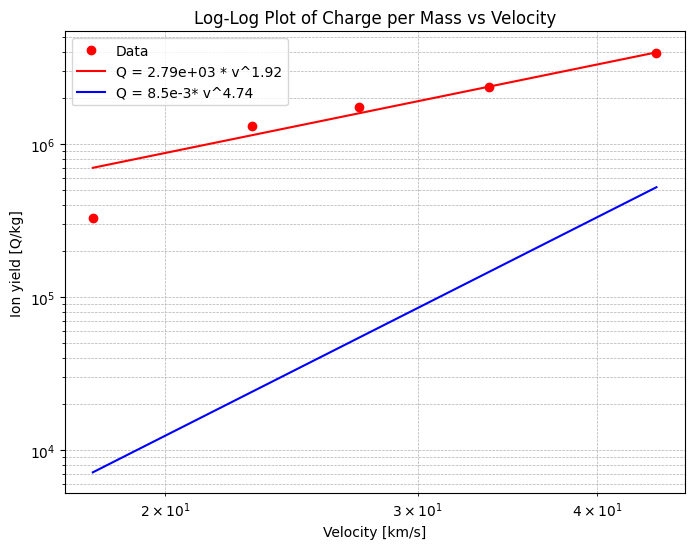

In [9]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Data
velocity = np.array([17.8, 23.0, 27.3, 33.6, 44.0])  # km/s
# q_per_kg = np.array([71121.35, 271019.16, 419758.98, 748169.50, 1644371.72])  # Q/kg
q_per_kg = np.array([3.30E+05,
1.32E+06,
1.75E+06,
2.36E+06,
3.95E+06])  # Q/kg





# Define the power-law function (Q = c * v^beta)
def power_law(v, c, beta):
    return c * v ** beta

# Fit the data
popt, pcov = curve_fit(power_law, velocity, q_per_kg)
c, beta = popt

# Print fitting results
print(f"Fitted parameters: c = {c:.2e}, beta = {beta:.2f}")

# Generate data for plotting the fit curve
v_fit = np.linspace(min(velocity), max(velocity), 100)
q_fit = power_law(v_fit, c, beta)
q_fit_2 = power_law(v_fit, 8.5e-3,4.74)

# Plot the data and the fit on a log-log scale
plt.figure(figsize=(8, 6))
plt.loglog(velocity, q_per_kg, 'o', label="Data", color="red")  # Log-log scatter plot
plt.loglog(v_fit, q_fit, label=f"Q = {c:.2e} * v^{beta:.2f}", color="red")  # Log-log fit curve
plt.loglog(v_fit, q_fit_2, label=f"Q = 8.5e-3* v^4.74", color="blue")  # Log-log fit curve
plt.xlabel("Velocity [km/s]")
plt.ylabel("Ion yield [Q/kg]")
plt.legend()
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.title("Log-Log Plot of Charge per Mass vs Velocity")
plt.show()


Fitted parameters: c = 3.59e+01, beta = -0.68


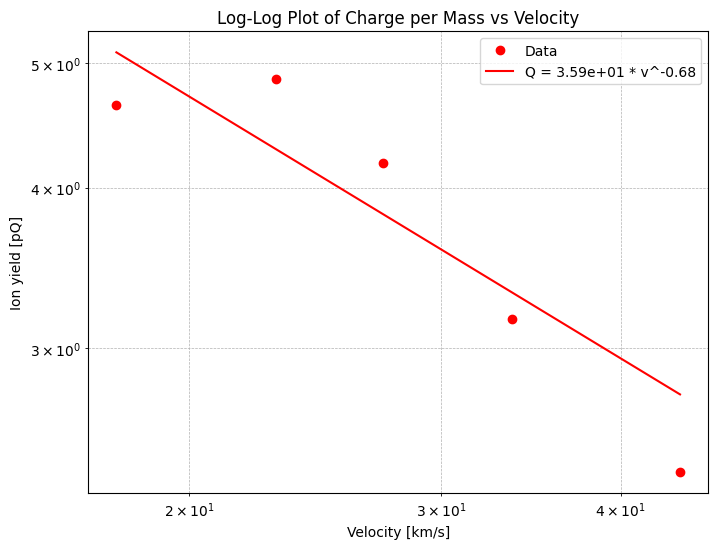

In [8]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Data
velocity = np.array([17.8, 23.0, 27.3, 33.6, 44.0])  # km/s
# q_per_kg = np.array([71121.35, 271019.16, 419758.98, 748169.50, 1644371.72])  # Q/kg
q = np.array([4.64,
4.86,
4.18,
3.16,
2.40])  # Q





# Define the power-law function (Q = c * v^beta)
def power_law(v, c, beta):
    return c * v ** beta

# Fit the data
popt, pcov = curve_fit(power_law, velocity, q)
c, beta = popt

# Print fitting results
print(f"Fitted parameters: c = {c:.2e}, beta = {beta:.2f}")

# Generate data for plotting the fit curve
v_fit = np.linspace(min(velocity), max(velocity), 100)
q_fit = power_law(v_fit, c, beta)
q_fit_2 = power_law(v_fit, 8.5e-3,4.74)

# Plot the data and the fit on a log-log scale
plt.figure(figsize=(8, 6))
plt.loglog(velocity, q, 'o', label="Data", color="red")  # Log-log scatter plot
plt.loglog(v_fit, q_fit, label=f"Q = {c:.2e} * v^{beta:.2f}", color="red")  # Log-log fit curve
# plt.loglog(v_fit, q_fit_2, label=f"Q = 8.5e-3* v^4.74", color="blue")  # Log-log fit curve
plt.xlabel("Velocity [km/s]")
plt.ylabel("Ion yield [pQ]")
plt.legend()
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.title("Log-Log Plot of Charge per Mass vs Velocity")
plt.show()


In [41]:
import matplotlib as mpl
#mpl.use('Cairo') #for png, ps, pdf, svg, ...
import matplotlib.pyplot as plt
import numpy as np
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
import glob
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec


print("\n\n######################")
print("#### P4P_plots.py ####")
print("######################\n")


path= os.getcwd()
# d_name   = os.path.basename(path)
d_name = "Rat1_1BIN1"
os.makedirs('./Python/P4P_plots/'.format(d_name), exist_ok=True)

#テスト/本番設定
# operation = "test_1"
operation = "test_2"
# operation = "actual"
if operation == "test_1":
  l = 1
  file_path = "/content/drive/MyDrive/ISAS/Meeting/isale/PINOCO/{}/u0000.bin".format(d_name)
if operation == "test_2":
  l = 20
  file_path = "/content/drive/MyDrive/ISAS/Meeting/isale/PINOCO/{}/u0000.bin".format(d_name)
if operation == "actual":
  l = len(glob.glob(f"{'./BIN1'}/*"))
  file_path = "./BIN1/u0000.bin"

print("file_number :",l)

#パラメータ(cell)
nxr1=100
nxr2=200
nxr3=700
nxr4=1200
nxr5=1250
ny=451
jj2=301

#パラメータ(cm to m)
rthick = 100e-7*1e-2
xleft = 200e-7*1e-2
xright = 150e-7*1e-2
finemesh = 60e-7*1e-2
y_out = 200e-7*1e-2

#grid(m)
grid_x = rthick/(nxr3-nxr2)
grid_y = finemesh/(jj2-1)

#速度と半径、計算領域の抽出
with open(file_path, "rb") as f:
  ttime = np.fromfile(f, dtype=np.float32, count=2)[1]
  nx, ny = np.fromfile(f, dtype=np.int32, count=2)
  # print("nx",nx,"ny",ny)
  x4 = np.fromfile(f, dtype=np.float32, count=nx+1)*1e-2-rthick
  y4 = np.fromfile(f, dtype=np.float32, count=ny+1)[1:]*1e-2
  u4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2

v_impact = -np.min(u4)
print("impact_velocity:",v_impact*1e-3,"[km/s]")
solid_ball_radius = (len(np.where(u4[:,0] < 0)[0])-1)*grid_x/2
print("solid_ball_radius: {:.2e} [m]".format(solid_ball_radius))
ts = 2*solid_ball_radius/(v_impact)
print("ts: {:.2e} [s]".format(ts))

python_xleft = min(x4)*1e9
python_xright = max(x4)*1e9
python_y_out = max(y4)*1e9
# python_xleft = (-rthick -xleft -(nxr2-nxr1)*grid_x)*1e9
# python_xright = ((nxr4-nxr3)*grid_x +xright)*1e9
# python_y_out = (finemesh +y_out)*1e9
print("xleft:",round(python_xleft,1),"[nm],  xright:",round(python_xright,1),"[nm], y_max:",round(python_y_out,1),"[nm]")

## 抽出したい範囲(cell number)
x_min = 0
x_max = nx
y_max = ny
# x_min = round(nxr3-1*solid_ball_radius/grid_x)
# x_max = round(nxr3+2*solid_ball_radius/grid_x)
# y_max = round(2*solid_ball_radius/grid_y)
## 抽出したい範囲(nm)
x_nm_min = round(((x_min-nxr2)*grid_x-100e-9)*1e9,1)
x_nm_max = round(((x_max-nxr2)*grid_x-100e-9)*1e9,1)
y_nm_min = 0
y_nm_max = round((y_max*grid_y)*1e9,1)

x_range = (x_min, x_max)
y_range = (0, y_max)

print("extract_xleft:",x_nm_min,"[nm], extract_xright:",x_nm_max,"[nm], extract_y_max:",y_nm_max,"[nm]")
print("If the extract region reaches the extended zone, this estimate of the extract resion is not precise.")

def read_binary_with_structure(file_path, x_range, y_range):

    with open(file_path, "rb") as f:
        # === 1. 時間を読み取る ===
        ttime = np.fromfile(f, dtype=np.float32, count=2)[1]

        # === 2. nx, ny を読み取る ===
        nx, ny = np.fromfile(f, dtype=np.int32, count=2)
        print("step_time:",ttime,"[s]")
        # print("nx",nx,"ny",ny)

        # 範囲インデックス
        x_min, x_max = x_range
        y_min, y_max = y_range
        # print("x_min",x_min,"x_max",x_max,"y_min",y_min,"y_max",y_max)
        # print("x_range",range(x_min, x_max))
        # === 3. x4, y4 の読み取り ===
        x4 = np.fromfile(f, dtype=np.float32, count=nx+1)*1e-2-rthick
        y4 = np.fromfile(f, dtype=np.float32, count=ny+1)[1:]*1e-2
        u4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2
        v4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2

        # print("x4_len",len(x4))
        # print("y4_len",len(y4))
        # print("x4",x4[0:3])
        # print("y4",y4[0:3])

        # === 4. 2次元配列 (rh4, p4, te4, ti4, zi4) の読み取り ===
        def read_2d_array():
            return np.fromfile(f, dtype=np.float32, count=(nx) * (ny)).reshape((nx,ny), order='F')[:,1:]
        rh4 = read_2d_array()
        p4 = read_2d_array()*1e-1
        te4 = read_2d_array()
        ti4 = read_2d_array()        
        zi4 = read_2d_array()
        # print("p4_shape",p4.shape)


        # === 5. mtldb (整数型2次元配列) の読み取り ===
        mtldb = np.fromfile(f, dtype=np.int32, count=(nx) * (ny)).reshape((nx,ny), order='F')[:,1:]

        # === 6. その他 (aaomtl, wlaserwrite, flsr) の読み取り ===
        aaomtl = np.fromfile(f, dtype=np.float32, count=3)
        wlaserwrite = np.fromfile(f, dtype=np.float32, count=1)[0]
        flsr = np.fromfile(f, dtype=np.float32, count=1)[0]
        # print("aaomtl",aaomtl)
        # print("wlaserwrite",wlaserwrite)
        # print("flsr",flsr)

        xc = np.zeros((nx, ny-1), dtype=np.float32)
        yc = np.zeros((nx, ny-1), dtype=np.float32)
        uc = np.zeros((nx, ny-1), dtype=np.float32)
        vc = np.zeros((nx, ny-1), dtype=np.float32)
        ent = np.zeros((nx, ny-1), dtype=np.float32)
        for j in range(0, ny-1):
          for i in range(0, nx):
            xc[i,j]=(x4[i]+x4[i+1])*0.5
            yc[i,j]=(y4[j]+y4[j+1])*0.5
            uc[i,j]=(u4[i,j]+u4[i+1,j]+u4[i,j+1]+u4[i+1,j+1])*0.25
            vc[i,j]=(v4[i,j]+v4[i+1,j]+v4[i,j+1]+v4[i+1,j+1])*0.25
            if mtldb[i,j] == 1 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[0]
            if mtldb[i,j] == 2 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[1]
            if mtldb[i,j] == 3 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[2]
        # print("xc_shape",xc.shape)
        # print("yc_shape",yc.shape)
        # print("xc",xc[0:3,0:3])
        # print("yc",yc[0:3,0:3])

        # 指定範囲を抽出
        xc = xc[x_min:x_max+1,y_min:y_max+1]
        yc = yc[x_min:x_max+1,y_min:y_max+1]
        ent = ent[x_min:x_max+1,y_min:y_max+1]
        rh4 = rh4[x_min:x_max+1, y_min:y_max+1]
        p4 = p4[x_min:x_max+1, y_min:y_max+1]
        te4 = te4[x_min:x_max+1, y_min:y_max+1]
        ti4 = ti4[x_min:x_max+1, y_min:y_max+1]
        zi4 = zi4[x_min:x_max+1, y_min:y_max+1]
        mtldb = mtldb[x_min:x_max+1, y_min:y_max+1]

        # print("xc_shape",xc.shape)
        # print("yc_shape",yc.shape)

    # データを辞書形式で返す
    return {
        "time": ttime,
        "x": xc,
        "y": yc,
        "u": u4,
        "v": v4,
        "rho": rh4,
        "en": ent,
        "P": p4,
        "te": te4,
        "ti": ti4,
        "zi": zi4,
        "mtl": mtldb,
        "Target_mol":aaomtl[1],
        "Projectile_mol":aaomtl[2],
        "ambience_mol": aaomtl[0],
        "wlaserwrite": wlaserwrite,
        "flsr": flsr,
    }
#Output units
# x, y : 座標(m)
# u, v : 流速 (m/s)
# rho : 密度 (g/cc)
# en : 電子数密度(個/cc)
# P : 圧力 (Pa)
# te : 電子温度 (eV)
# ti : イオン温度(eV)
# zi : 電離度
# mtl : 物質追跡

time = []

all_maxp = []
Target_impact_maxp = []
projectile_impact_maxp = []
Target_all_maxp = []
projectile_all_maxp = []
ambience_all_maxp = []

all_maxi = []
Target_impact_maxi = []
projectile_impact_maxi = []
Target_all_maxi = []
projectile_all_maxi = []
ambience_all_maxi = []

all_maxe = []
Target_impact_maxe = []
projectile_impact_maxe = []
Target_all_maxe = []
projectile_all_maxe = []
ambience_all_maxe = []

all_maxz = []
Target_impact_maxz = []
projectile_impact_maxz = []
Target_all_maxz = []
projectile_all_maxz = []
ambience_all_maxz = []

all_maxr = []
Target_impact_maxr = []
projectile_impact_maxr = []
Target_all_maxr = []
projectile_all_maxr = []
ambience_all_maxr = []

all_maxed = []
Target_impact_maxed = []
projectile_impact_maxed = []
Target_all_maxed = []
projectile_all_maxed = []
ambience_all_maxed = []

Target_1 =[]
projectile_1 = []
i_1 = []


print("\n----- start loading -----")
for i in np.arange(0,l,1):

  print('step:',i)
  print("file:",file_path)

  if operation == "test_1":
    file_path = "/content/drive/MyDrive/ISAS/Meeting/isale/PINOCO/{}/u0000.bin".format(d_name)
  if operation == "test_2":
    file_path = "/content/drive/MyDrive/ISAS/Meeting/isale/PINOCO/{}/u{:04d}.bin".format(d_name,i)  
  if operation == "actual":
    file_path = "./BIN1/u{0:04d}.bin".format(i)

  # データを読み取る(m to nm)
  data = read_binary_with_structure(file_path, x_range, y_range)
  # print(data)
  print('-------------------------')
  mtl = data['mtl']
  time.append(data['time']*1e12)
  for x in np.arange(0,nx-2,1):
    if mtl[x,1] == 2  and mtl[x+1,1] == 3:
      Target_impact = x
      projectile_impact = x+1
      j = 0
    elif mtl[x,1] == 2  and mtl[x+1,1] == 1:
      Target_impact = x
      j = 1
    elif mtl[x,1] == 1  and mtl[x+1,1] == 3:
      projectile_impact = x+1
      j = 1
  Target_all = np.where(mtl == 2)
  projectile_all = np.where(mtl == 3)
  ambience_all = np.where(mtl == 1)
  # 空の場合
  if Target_all[0].size == 0:
    Target_all = np.array([0])
  if  projectile_all[0].size == 0:
     projectile_all = np.array([0])
  if ambience_all[0].size == 0:
    ambience_all = np.array([0])

  all_p = data['P']
  all_maxp.append(np.max(all_p)*1e-9)
  Target_impact_maxp.append(all_p[Target_impact,1]*1e-9)
  projectile_impact_maxp.append(all_p[projectile_impact,1]*1e-9)
  Target_all_maxp.append(np.max(all_p[Target_all])*1e-9)
  projectile_all_maxp.append(np.max(all_p[projectile_all])*1e-9)
  ambience_all_maxp.append(np.max(all_p[ambience_all])*1e-9)

  all_r = data['rho']
  all_maxr.append(np.max(all_r))
  Target_impact_maxr.append(all_r[Target_impact,1])
  projectile_impact_maxr.append(all_r[projectile_impact,1])
  Target_all_maxr.append(np.max(all_r[Target_all]))
  projectile_all_maxr.append(np.max(all_r[projectile_all]))
  ambience_all_maxr.append(np.max(all_r[ambience_all]))

  all_i = data['ti']
  all_maxi.append(np.max(all_i))
  Target_impact_maxi.append(all_i[Target_impact,1])
  projectile_impact_maxi.append(all_i[projectile_impact,1])
  Target_all_maxi.append(np.max(all_i[Target_all]))
  projectile_all_maxi.append(np.max(all_i[projectile_all]))
  ambience_all_maxi.append(np.max(all_i[ambience_all]))

  all_e = data['te']
  all_maxe.append(np.max(all_e))
  Target_impact_maxe.append(all_e[Target_impact,1])
  projectile_impact_maxe.append(all_e[projectile_impact,1])
  Target_all_maxe.append(np.max(all_e[Target_all]))
  projectile_all_maxe.append(np.max(all_e[projectile_all]))
  ambience_all_maxe.append(np.max(all_e[ambience_all]))

  all_z = data['zi']
  all_maxz.append(np.max(all_z))
  Target_impact_maxz.append(all_z[Target_impact,1])
  projectile_impact_maxz.append(all_z[projectile_impact,1])
  Target_all_maxz.append(np.max(all_z[Target_all]))
  projectile_all_maxz.append(np.max(all_z[projectile_all]))
  ambience_all_maxz.append(np.max(all_z[ambience_all]))

  all_ed = data['en']
  all_maxed.append(np.max(all_ed))
  Target_impact_maxed.append(all_ed[Target_impact,1])
  projectile_impact_maxed.append(all_ed[projectile_impact,1])
  Target_all_maxed.append(np.max(all_ed[Target_all]))
  projectile_all_maxed.append(np.max(all_ed[projectile_all]))
  ambience_all_maxed.append(np.max(all_ed[ambience_all]))

  projectile_1.append(projectile_impact)
  Target_1.append(Target_impact)
  i_1.append(j)

max_all_maxp = max(all_maxp)
max_Target_impact_maxp = max(Target_impact_maxp)
max_projectile_impact_maxp = max(projectile_impact_maxp)
max_Target_all_maxp = max(Target_all_maxp)
max_projectile_all_maxp = max(projectile_all_maxp)
max_ambience_all_maxp = max(ambience_all_maxp)

max_all_maxi = max(all_maxi)
max_Target_impact_maxi = max(Target_impact_maxi)
max_projectile_impact_maxi = max(projectile_impact_maxi)
max_Target_all_maxi = max(Target_all_maxi)
max_projectile_all_maxi = max(projectile_all_maxi)
max_ambience_all_maxi = max(ambience_all_maxi)

max_all_maxe =  max(all_maxe)
max_Target_impact_maxe = max(Target_impact_maxe)
max_projectile_impact_maxe = max(projectile_impact_maxe)
max_Target_all_maxe = max(Target_all_maxe)
max_projectile_all_maxe = max(projectile_all_maxe)
max_ambience_all_maxe = max(ambience_all_maxe)

max_all_maxz = max(all_maxz)
max_Target_impact_maxz = max(Target_impact_maxz)
max_projectile_impact_maxz = max(projectile_impact_maxz)
max_Target_all_maxz = max(Target_all_maxz)
max_projectile_all_maxz = max(projectile_all_maxz)
max_ambience_all_maxz = max(ambience_all_maxz)

max_all_maxr = max(all_maxr)
max_Target_impact_maxr = max(Target_impact_maxr)
max_projectile_impact_maxr = max(projectile_impact_maxr)
max_Target_all_maxr = max(Target_all_maxr)
max_projectile_all_maxr = max(projectile_all_maxr)
max_ambience_all_maxr = max(ambience_all_maxr)

max_all_maxed = max(all_maxed)
max_Target_impact_maxed = max(Target_impact_maxed)
max_projectile_impact_maxed = max(projectile_impact_maxed)
max_Target_all_maxed = max(Target_all_maxed)
max_projectile_all_maxed = max(projectile_all_maxed)
max_ambience_all_maxed = max(ambience_all_maxed)


Target_impact = np.array([max_Target_impact_maxp,max_Target_impact_maxi, max_Target_impact_maxe, max_Target_impact_maxz, max_Target_impact_maxr, max_Target_impact_maxed])
Projectile_impact = np.array([max_projectile_impact_maxp,max_projectile_impact_maxi, max_projectile_impact_maxe, max_projectile_impact_maxz, max_projectile_impact_maxr, max_projectile_impact_maxed])
Target_all = np.array([max_Target_all_maxp,max_Target_all_maxi, max_Target_all_maxe, max_Target_all_maxz, max_Target_all_maxr, max_Target_all_maxed])
Projectile_all = np.array([max_projectile_all_maxp,max_projectile_all_maxi, max_projectile_all_maxe, max_projectile_all_maxz, max_projectile_all_maxr, max_projectile_all_maxed])
ambience_all = np.array([max_ambience_all_maxp,max_ambience_all_maxi, max_ambience_all_maxe, max_ambience_all_maxz, max_ambience_all_maxr, max_ambience_all_maxed])


# 各配列の有効数字を変換
def to_scientific_notation(arr):
    return [f"{x:.3e}" for x in arr]
Target_impact = to_scientific_notation(Target_impact)
Projectile_impact = to_scientific_notation(Projectile_impact)
Target_all = to_scientific_notation(Target_all)
Projectile_all = to_scientific_notation(Projectile_all)
ambience_all = to_scientific_notation(ambience_all)

label = ['Pressure [GPa]', 'Ion Temperature [eV]', 'Electron Temperature [eV]', 'Ionization Degree','Density [g/cc]','Electron Density [g/cc]' ]
columns  = ['parameters', 'Target_impact_max', 'projectile_impact_max', 'Target_all_max', 'projectile_all_max', 'ambient_all_max']
texts = [[] for i in range(len(label))]
for i in range(len(label)):
  texts[i].append(label[i])
  texts[i].append(Target_impact[i])
  texts[i].append(Projectile_impact[i])
  texts[i].append(Target_all[i])
  texts[i].append(Projectile_all[i])
  texts[i].append(ambience_all[i])
print(columns)
print(texts)

# Set up a pyplot figure
fig = plt.figure(figsize=(30,7), tight_layout=True)
gs = gridspec.GridSpec(2, 7)
ax1=fig.add_subplot(gs[0,0])
ax2=fig.add_subplot(gs[0,1])
ax3=fig.add_subplot(gs[0,2])
ax4=fig.add_subplot(gs[0,3])
ax5=fig.add_subplot(gs[1,:])
ax6=fig.add_subplot(gs[0,4])
ax7=fig.add_subplot(gs[0,5])
ax9=fig.add_subplot(gs[0,6])
ax8 = ax7.twinx()

ax5.axis('off')
table = ax5.table(cellText=texts, colLabels=columns, cellLoc='center',loc='center',colColours=['#e9f7ed','#e9f7ed', '#e9f7ed', '#e9f7ed','#e9f7ed','#e9f7ed'])
table.auto_set_font_size(False)
table.set_fontsize(10)


# set axis labels
ax1.set_xlabel('t  [ps]')
ax1.set_ylabel('Pressure [GPa]')
ax1.axvspan(0, ts*1e12, color='yellow', alpha=0.3)

ax1.plot(time,Target_impact_maxp, linewidth = 1.0,c="red",zorder=1,label="Target_impact")
ax1.plot(time,projectile_impact_maxp, linewidth = 1.0,c="green",zorder=1,label="projectile_impact")
ax1.plot(time,Target_all_maxp, linewidth = 1.0,c="red",zorder=1,label="Target_all",ls='--')
ax1.plot(time,projectile_all_maxp, linewidth = 1.0,c="green",zorder=1,label="Projectile_all",ls='--')
ax1.plot(time,ambience_all_maxp, linewidth = 1.0,c="blue",zorder=1,label="Ambience_all",ls='--')

ax1.axhline(max_Target_impact_maxp, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax1.axhline(max_projectile_impact_maxp, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax1.axhline(max_Target_all_maxp, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax1.axhline(max_projectile_all_maxp, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax1.axhline(max_ambience_all_maxp, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")

ax1.text(0,max_Target_impact_maxp,"{: 5.1e}".format(max_Target_impact_maxp),ha='left', va='bottom')
ax1.text(0,max_projectile_impact_maxp,"{: 5.1e}".format(max_projectile_impact_maxp),ha='left', va='bottom')
ax1.text(0,max_Target_all_maxp,"{: 5.1e}".format(max_Target_all_maxp),ha='left', va='bottom')
ax1.text(0,max_projectile_all_maxp,"{: 5.1e}".format(max_projectile_all_maxp),ha='left', va='bottom')
ax1.text(0,max_ambience_all_maxp,"{: 5.1e}".format(max_ambience_all_maxp),ha='left', va='bottom')

ax1.legend(fontsize=8)
#ax1.set_aspect ('equal')


# set axis labels
ax2.set_xlabel('t  [ps]')
ax2.set_ylabel('Ion Tempareture [eV]')
ax2.axvspan(0, ts*1e12, color='yellow', alpha=0.3)

ax2.plot(time,Target_impact_maxi, linewidth = 1.0,c="red",zorder=1,label="Target_impact")
ax2.plot(time,projectile_impact_maxi, linewidth = 1.0,c="green",zorder=1,label="projectile_impact")
ax2.plot(time,Target_all_maxi, linewidth = 1.0,c="red",zorder=1,label="Target_all",ls='--')
ax2.plot(time,projectile_all_maxi, linewidth = 1.0,c="green",zorder=1,label="Projectile_all",ls='--')
ax2.plot(time,ambience_all_maxi, linewidth = 1.0,c="blue",zorder=1,label="Ambience_all",ls='--')

ax2.axhline(max_Target_impact_maxi, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax2.axhline(max_projectile_impact_maxi, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax2.axhline(max_Target_all_maxi, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax2.axhline(max_projectile_all_maxi, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax2.axhline(max_ambience_all_maxi, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")

ax2.text(0,max_Target_impact_maxi,"{: 5.1e}".format(max_Target_impact_maxi),ha='left', va='bottom')
ax2.text(0,max_projectile_impact_maxi,"{: 5.1e}".format(max_projectile_impact_maxi),ha='left', va='bottom')
ax2.text(0,max_Target_all_maxi,"{: 5.1e}".format(max_Target_all_maxi),ha='left', va='bottom')
ax2.text(0,max_projectile_all_maxi,"{: 5.1e}".format(max_projectile_all_maxi),ha='left', va='bottom')
ax2.text(0,max_ambience_all_maxi,"{: 5.1e}".format(max_ambience_all_maxi),ha='left', va='bottom')

ax2.legend(fontsize=8)
#ax2.set_aspect ('equal')


# set axis labels
ax3.set_xlabel('t  [ps]')
ax3.set_ylabel('Electron Tempareture [eV]')
ax3.axvspan(0, ts*1e12, color='yellow', alpha=0.3)


ax3.plot(time,Target_impact_maxe, linewidth = 1.0,c="red",zorder=1,label="Target_impact")
ax3.plot(time,projectile_impact_maxe, linewidth = 1.0,c="green",zorder=1,label="projectile_impact")
ax3.plot(time,Target_all_maxe, linewidth = 1.0,c="red",zorder=1,label="Target_all",ls='--')
ax3.plot(time,projectile_all_maxe, linewidth = 1.0,c="green",zorder=1,label="Projectile_all",ls='--')
ax3.plot(time,ambience_all_maxe, linewidth = 1.0,c="blue",zorder=1,label="Ambience_all",ls='--')

ax3.axhline(max_Target_impact_maxe, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax3.axhline(max_projectile_impact_maxe, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax3.axhline(max_Target_all_maxe, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax3.axhline(max_projectile_all_maxe, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax3.axhline(max_ambience_all_maxe, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")

ax3.text(0,max_Target_impact_maxe,"{: 5.1e}".format(max_Target_impact_maxe),ha='left', va='bottom')
ax3.text(0,max_projectile_impact_maxe,"{: 5.1e}".format(max_projectile_impact_maxe),ha='left', va='bottom')
ax3.text(0,max_Target_all_maxe,"{: 5.1e}".format(max_Target_all_maxe),ha='left', va='bottom')
ax3.text(0,max_projectile_all_maxe,"{: 5.1e}".format(max_projectile_all_maxe),ha='left', va='bottom')
ax3.text(0,max_ambience_all_maxe,"{: 5.1e}".format(max_ambience_all_maxe),ha='left', va='bottom')

ax3.legend(fontsize=8)
#ax3.set_aspect ('equal')

# set axis labels
ax4.set_xlabel('t  [ps]')
ax4.set_ylabel('Ionization degree')
ax4.axvspan(0, ts*1e12, color='yellow', alpha=0.3)


ax4.plot(time,Target_impact_maxz, linewidth = 1.0,c="red",zorder=1,label="Target_impact")
ax4.plot(time,projectile_impact_maxz, linewidth = 1.0,c="green",zorder=1,label="projectile_impact")
ax4.plot(time,Target_all_maxz, linewidth = 1.0,c="red",zorder=1,label="Target_all",ls='--')
ax4.plot(time,projectile_all_maxz, linewidth = 1.0,c="green",zorder=1,label="Projectile_all",ls='--')
ax4.plot(time,ambience_all_maxz, linewidth = 1.0,c="blue",zorder=1,label="Ambience_all",ls='--')

ax4.axhline(max_Target_impact_maxz, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax4.axhline(max_projectile_impact_maxz, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax4.axhline(max_Target_all_maxz, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax4.axhline(max_projectile_all_maxz, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax4.axhline(max_ambience_all_maxz, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")

ax4.text(0,max_Target_impact_maxz,"{: 5.1e}".format(max_Target_impact_maxz),ha='left', va='bottom')
ax4.text(0,max_projectile_impact_maxz,"{: 5.1e}".format(max_projectile_impact_maxz),ha='left', va='bottom')
ax4.text(0,max_Target_all_maxz,"{: 5.1e}".format(max_Target_all_maxz),ha='left', va='bottom')
ax4.text(0,max_projectile_all_maxz,"{: 5.1e}".format(max_projectile_all_maxz),ha='left', va='bottom')
ax4.text(0,max_ambience_all_maxz,"{: 5.1e}".format(max_ambience_all_maxz),ha='left', va='bottom')

ax4.legend(fontsize=8)
#ax4.set_aspect ('equal')


# set axis labels
ax6.set_xlabel('t  [ps]')
ax6.set_ylabel('Density [g/cc]')
ax6.axvspan(0, ts*1e12, color='yellow', alpha=0.3)


ax6.plot(time,Target_impact_maxr, linewidth = 1.0,c="red",zorder=1,label="Target_impact")
ax6.plot(time,projectile_impact_maxr, linewidth = 1.0,c="green",zorder=1,label="projectile_impact")
ax6.plot(time,Target_all_maxr, linewidth = 1.0,c="red",zorder=1,label="Target_all",ls='--')
ax6.plot(time,projectile_all_maxr, linewidth = 1.0,c="green",zorder=1,label="Projectile_all",ls='--')
ax6.plot(time,ambience_all_maxr, linewidth = 1.0,c="blue",zorder=1,label="Ambience_all",ls='--')

ax6.axhline(max_Target_impact_maxr, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax6.axhline(max_projectile_impact_maxr, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax6.axhline(max_Target_all_maxr, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax6.axhline(max_projectile_all_maxr, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax6.axhline(max_ambience_all_maxr, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")

ax6.text(0,max_Target_impact_maxr,"{: 5.1e}".format(max_Target_impact_maxr),ha='left', va='bottom')
ax6.text(0,max_projectile_impact_maxr,"{: 5.1e}".format(max_projectile_impact_maxr),ha='left', va='bottom')
ax6.text(0,max_Target_all_maxr,"{: 5.1e}".format(max_Target_all_maxr),ha='left', va='bottom')
ax6.text(0,max_projectile_all_maxr,"{: 5.1e}".format(max_projectile_all_maxr),ha='left', va='bottom')
ax6.text(0,max_ambience_all_maxr,"{: 5.1e}".format(max_ambience_all_maxr),ha='left', va='bottom')

ax6.legend(fontsize=8)
#ax6.set_aspect ('equal')

ax7.axvspan(0, ts*1e12, color='yellow', alpha=0.3)
ax7.plot(time,Target_1, linewidth = 1.0,c="red",zorder=1,label="target")
ax7.plot(time,projectile_1, linewidth = 1.0,c="green",zorder=1,label="projectile")
# set axis labels
ax7.set_xlabel('t  [ps]')
ax7.set_ylabel('material')
ax7.legend(fontsize=8)

# set axis labels
ax9.set_xlabel('t  [ps]')
ax9.set_ylabel('Electron Density [/cc]')
ax9.axvspan(0, ts*1e12, color='yellow', alpha=0.3)

ax9.plot(time,Target_impact_maxed, linewidth = 1.0,c="red",zorder=1,label="Target_impact")
ax9.plot(time,projectile_impact_maxed, linewidth = 1.0,c="green",zorder=1,label="projectile_impact")
ax9.plot(time,Target_all_maxed, linewidth = 1.0,c="red",zorder=1,label="Target_all",ls='--')
ax9.plot(time,projectile_all_maxed, linewidth = 1.0,c="green",zorder=1,label="Projectile_all",ls='--')
ax9.plot(time,ambience_all_maxed, linewidth = 1.0,c="blue",zorder=1,label="Ambience_all",ls='--')

ax9.axhline(max_Target_impact_maxed, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax9.axhline(max_projectile_impact_maxed, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax9.axhline(max_Target_all_maxed, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax9.axhline(max_projectile_all_maxed, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")
ax9.axhline(max_ambience_all_maxed, color = "black", alpha = 0.2, lw=1, linestyle = "dashed")

ax9.text(0,max_Target_impact_maxed,"{: 5.1e}".format(max_Target_impact_maxed),ha='left', va='bottom')
ax9.text(0,max_projectile_impact_maxed,"{: 5.1e}".format(max_projectile_impact_maxed),ha='left', va='bottom')
ax9.text(0,max_Target_all_maxed,"{: 5.1e}".format(max_Target_all_maxed),ha='left', va='bottom')
ax9.text(0,max_projectile_all_maxed,"{: 5.1e}".format(max_projectile_all_maxed),ha='left', va='bottom')
ax9.text(0,max_ambience_all_maxed,"{: 5.1e}".format(max_ambience_all_maxed),ha='left', va='bottom')

ax9.legend(fontsize=8)

ax8.plot(time,i_1, linewidth = 1.0,c="blue",zorder=1,label="j")
ax8.set_ylabel('j')
ax8.set_yticks([0,1])
ax8.set_yticklabels(['0','1'])


h1, l1 = ax7.get_legend_handles_labels()
h2, l2 = ax8.get_legend_handles_labels()
ax7.legend(h1+h2, l1+l2, loc='upper right')

if operation == "actual":
  fig.savefig('./Python/P4P_plots/plots_{}.png'.format(d_name))

np.int64(702)



#######################
#### P4P_MatEnt.py ####
#######################

file_number : 1
impact_velocity: 44.000004 [km/s]
solid_ball_radius: 2.50e-08 [m]
ts: 1.14e-12 [s]
xleft: -320.0 [nm],  xright: 250.0 [nm], y_max: 260.0 [nm]
extract_xleft: -200 [nm], extract_xright: 200 [nm], extract_y_max: 200 [nm]
If the extract region reaches the extended zone, this estimate of the extract resion is not precise.

----- start loading -----
step: 0
file: ./Rat5_1BIN1/u0000.bin
step_time: 5.500546e-12 [s]
-------------------------


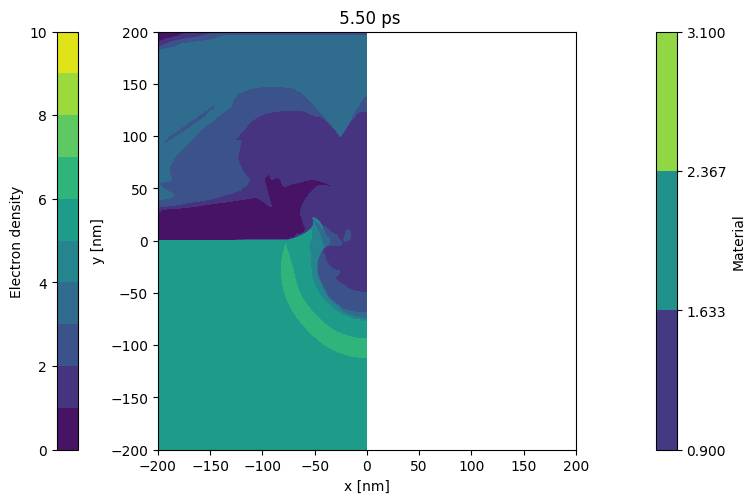

In [64]:
import matplotlib as mpl
#mpl.use('Cairo') #for png, ps, pdf, svg, ...
import matplotlib.pyplot as plt
import numpy as np
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
import glob
from scipy.interpolate import griddata

print("\n\n#######################")
print("#### P4P_MatEnt.py ####")
print("#######################\n")


fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111,aspect='equal')

# path= os.getcwd()
# d_name   = os.path.basename(path)
d_name = "Rat5_1BIN1"
os.makedirs('./Python/P4P_MatEnt/P4P_MatEnt_{}'.format(d_name), exist_ok=True)

#テスト/本番設定
operation = "test_1"
# operation = "test_2"
# operation = "actual"
if operation == "test_1":
  l = 1
  file_path = "./{}/u0000.bin".format(d_name)
if operation == "test_2":
  l = 100
  file_path = "./{}/u0000.bin".format(d_name)
if operation == "actual":
  # l = 100
  l = len(glob.glob(f"{'./{}'.format(d_name)}/*"))
  file_path = "./{}/u0000.bin".format(d_name)

print("file_number :",l)


#パラメータ(cell)
nxr1=100
nxr2=200
nxr3=700
nxr4=1200
nxr5=1250
ny=451
jj2=301

#パラメータ(cm to m)
rthick = 100e-7*1e-2
xleft = 200e-7*1e-2
xright = 150e-7*1e-2
finemesh = 60e-7*1e-2
y_out = 200e-7*1e-2

#grid(m)
grid_x = rthick/(nxr3-nxr2)
grid_y = finemesh/(jj2-1)

#速度と半径、計算領域の抽出
with open(file_path, "rb") as f:
  ttime = np.fromfile(f, dtype=np.float32, count=2)[1]
  nx, ny = np.fromfile(f, dtype=np.int32, count=2)
  # print("nx",nx,"ny",ny)
  x4 = np.fromfile(f, dtype=np.float32, count=nx+1)*1e-2-rthick
  y4 = np.fromfile(f, dtype=np.float32, count=ny+1)[1:]*1e-2
  u4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2

v_impact = -np.min(u4)
print("impact_velocity:",v_impact*1e-3,"[km/s]")
solid_ball_radius = (len(np.where(u4[:,0] < 0)[0])-1)*grid_x/2
print("solid_ball_radius: {:.2e} [m]".format(solid_ball_radius))
ts = 2*solid_ball_radius/(v_impact)
print("ts: {:.2e} [s]".format(ts))

python_xleft = min(x4)*1e9
python_xright = max(x4)*1e9
python_y_out = max(y4)*1e9
# python_xleft = (-rthick -xleft -(nxr2-nxr1)*grid_x)*1e9
# python_xright = ((nxr4-nxr3)*grid_x +xright)*1e9
# python_y_out = (finemesh +y_out)*1e9
print("xleft:",round(python_xleft,1),"[nm],  xright:",round(python_xright,1),"[nm], y_max:",round(python_y_out,1),"[nm]")


## 抽出したい範囲(cell number)
x_min = 0
x_max = nx
y_max = ny
x_nm_min = -200
x_nm_max = 200
y_nm_max = 200
# x_min = round(nxr3-1*solid_ball_radius/grid_x)
# x_max = round(nxr3+2*solid_ball_radius/grid_x)
# y_max = round(2*solid_ball_radius/grid_y)
## 抽出したい範囲(nm)
# x_nm_min = round(((x_min-nxr2)*grid_x-100e-9)*1e9,1)
# x_nm_max = round(((x_max-nxr2)*grid_x-100e-9)*1e9,1)
# y_nm_min = 0
# y_nm_max = round((y_max*grid_y)*1e9,1)

x_range = (x_min, x_max)
y_range = (0, y_max)

print("extract_xleft:",x_nm_min,"[nm], extract_xright:",x_nm_max,"[nm], extract_y_max:",y_nm_max,"[nm]")
print("If the extract region reaches the extended zone, this estimate of the extract resion is not precise.")


def read_binary_with_structure(file_path, x_range, y_range):

    with open(file_path, "rb") as f:
        # === 1. 時間を読み取る ===
        ttime = np.fromfile(f, dtype=np.float32, count=2)[1]

        # === 2. nx, ny を読み取る ===
        nx, ny = np.fromfile(f, dtype=np.int32, count=2)
        print("step_time:",ttime,"[s]")
        # print("nx",nx,"ny",ny)

        # 範囲インデックス
        x_min, x_max = x_range
        y_min, y_max = y_range
        # print("x_min",x_min,"x_max",x_max,"y_min",y_min,"y_max",y_max)
        # print("x_range",range(x_min, x_max))
        # === 3. x4, y4 の読み取り ===
        x4 = np.fromfile(f, dtype=np.float32, count=nx+1)*1e-2-rthick
        y4 = np.fromfile(f, dtype=np.float32, count=ny+1)[1:]*1e-2
        u4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2
        v4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2

        # print("x4_len",len(x4))
        # print("y4_len",len(y4))
        # print("x4",x4[0:3])
        # print("y4",y4[0:3])

        # === 4. 2次元配列 (rh4, p4, te4, ti4, zi4) の読み取り ===
        def read_2d_array():
            return np.fromfile(f, dtype=np.float32, count=(nx) * (ny)).reshape((nx,ny), order='F')[:,1:]
        rh4 = read_2d_array()
        p4 = read_2d_array()*1e-1
        te4 = read_2d_array()
        ti4 = read_2d_array()        
        zi4 = read_2d_array()
        # print("p4_shape",p4.shape)


        # === 5. mtldb (整数型2次元配列) の読み取り ===
        mtldb = np.fromfile(f, dtype=np.int32, count=(nx) * (ny)).reshape((nx,ny), order='F')[:,1:]

        # === 6. その他 (aaomtl, wlaserwrite, flsr) の読み取り ===
        aaomtl = np.fromfile(f, dtype=np.float32, count=3)
        wlaserwrite = np.fromfile(f, dtype=np.float32, count=1)[0]
        flsr = np.fromfile(f, dtype=np.float32, count=1)[0]
        # print("aaomtl",aaomtl)
        # print("wlaserwrite",wlaserwrite)
        # print("flsr",flsr)

        xc = np.zeros((nx, ny-1), dtype=np.float32)
        yc = np.zeros((nx, ny-1), dtype=np.float32)
        uc = np.zeros((nx, ny-1), dtype=np.float32)
        vc = np.zeros((nx, ny-1), dtype=np.float32)
        ent = np.zeros((nx, ny-1), dtype=np.float32)
        for j in range(0, ny-1):
          for i in range(0, nx):
            xc[i,j]=(x4[i]+x4[i+1])*0.5
            yc[i,j]=(y4[j]+y4[j+1])*0.5
            uc[i,j]=(u4[i,j]+u4[i+1,j]+u4[i,j+1]+u4[i+1,j+1])*0.25
            vc[i,j]=(v4[i,j]+v4[i+1,j]+v4[i,j+1]+v4[i+1,j+1])*0.25
            if mtldb[i,j] == 1 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[0]
            if mtldb[i,j] == 2 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[1]
            if mtldb[i,j] == 3 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[2]
        # print("xc_shape",xc.shape)
        # print("yc_shape",yc.shape)
        # print("xc",xc[0:3,0:3])
        # print("yc",yc[0:3,0:3])

        # 指定範囲を抽出
        xc = xc[x_min:x_max+1,y_min:y_max+1]
        yc = yc[x_min:x_max+1,y_min:y_max+1]
        ent = ent[x_min:x_max+1,y_min:y_max+1]
        rh4 = rh4[x_min:x_max+1, y_min:y_max+1]
        p4 = p4[x_min:x_max+1, y_min:y_max+1]
        te4 = te4[x_min:x_max+1, y_min:y_max+1]
        ti4 = ti4[x_min:x_max+1, y_min:y_max+1]
        zi4 = zi4[x_min:x_max+1, y_min:y_max+1]
        mtldb = mtldb[x_min:x_max+1, y_min:y_max+1]

        # print("xc_shape",xc.shape)
        # print("yc_shape",yc.shape)

    # データを辞書形式で返す
    return {
        "time": ttime,
        "x": xc,
        "y": yc,
        "u": u4,
        "v": v4,
        "rho": rh4,
        "en": ent,
        "P": p4,
        "te": te4,
        "ti": ti4,
        "zi": zi4,
        "mtl": mtldb,
        "Target_mol":aaomtl[1],
        "Projectile_mol":aaomtl[2],
        "ambience_mol": aaomtl[0],
        "wlaserwrite": wlaserwrite,
        "flsr": flsr,
    }
#Output units
# x, y : 座標(m)
# u, v : 流速 (m/s)
# rho : 密度 (g/cc)
# en : 電子数密度(個/cc)
# P : 圧力 (Pa)
# te : 電子温度 (eV)
# ti : イオン温度(eV)
# zi : 電離度
# mtl : 物質追跡

print("\n----- start loading -----")
for i in np.arange(0,l,1):

  print('step:',i)
  print("file:",file_path)

  if operation == "test_1":
    file_path = "./{}/u0055.bin".format(d_name)
  if operation == "test_2":
    file_path = "./{}/u{:04d}.bin".format(d_name, i)
  if operation == "actual":
    file_path = "./{}/u{:04d}.bin".format(d_name, i)


  # データを読み取る(m to nm)
  data = read_binary_with_structure(file_path, x_range, y_range)
  # print(data)
  print('-------------------------')
  ##amount of Q
  #Extract para.
  Target_z = all_z[Target]
  Projectile_z = all_z[Projectile]
  Target_rho = all_rho[Target]
  Projectile_rho = all_rho[Projectile]
  Target_y = all_y[Target]
  Projectile_y = all_y[Projectile]

  Ion_Target = np.where((all_z>0) & (mtl==2))
  Ion_Projectile = np.where((all_z>0) & (mtl == 3))

  Ion_rho_Target = all_rho[Ion_Target]
  Ion_rho_Projectile = all_rho[Ion_Projectile]
  Target_T = all_T[Ion_Target]
  Projectile_T = all_T[Ion_Projectile]
  Ion_z_Target = all_z[Ion_Target]
  Ion_z_Projectile = all_z[Ion_Projectile]
  Ion_y_Target = all_y[Ion_Target]
  Ion_y_Projectile = all_y[Ion_Projectile]

  #sum up
  q =  2*np.pi*data["y"]*1e2*(grid_x*1e2)*(grid_y*1e2)*data["rho"]/data["Target_mol"]*data["zi"]*F


  # # 解像度を増やす
  # grid_x = np.linspace(x_nm_min, x_nm_max, 500)  
  # grid_y = np.linspace(-y_nm_min, y_nm_max, 500)
  # grid_x, grid_y = np.meshgrid(grid_x, grid_y)
  # # PressureとDensityを補間 (griddataを使う)
  # grid_P = griddata((data["x"].flatten(), data["y"].flatten()), data["P"].flatten(), 
  #     (grid_x, grid_y), method='cubic')
  # grid_rho = griddata((data["x"].flatten(), data["y"].flatten()), data["rho"].flatten(), 
  #     (grid_x, grid_y), method='cubic')

  # Set up a pylab figure
  # set axis labels
  ax.set_xlabel('x [nm]')
  ax.set_ylabel('y [nm]')
  # set axis limits
  ax.set_ylim([x_nm_min,x_nm_max])
  ax.set_xlim([-y_nm_max,y_nm_max])
  # ax.set_xlim([python_xleft,python_xright])
  # ax.set_ylim([-python_y_out,python_y_out])

  # Plot field
  # p1=ax.pcolormesh(data["y"]*1e9,data["x"]*1e9,data["P"]*1e-9,vmin=10,vmax=100)
  # p2=ax.pcolormesh(-data["y"]*1e9,-data["x"]*1e9,data["rho"],vmin=0,vmax=13)
  p1=ax.tricontourf(data["y"].flatten()*1e9,data["x"].flatten()*1e9,q.flatten(),levels=np.linspace(0.9,3.1,4))
  p2=ax.tricontourf(-data["y"].flatten()*1e9,data["x"].flatten()*1e9,data["zi"].flatten(),levels=np.linspace(0,10,11))

  # add color bar
  if i == 0:
    # create colorbars to either side of the plot
    divider = make_axes_locatable(ax)
    cx1=divider.append_axes("right", size="5%", pad=0.8)
    cx2=divider.append_axes("left", size="5%", pad=0.8)
    cb3=fig.colorbar(p1,cax=cx1)
    cb3.set_label('Material')
    cb4=fig.colorbar(p2,cax=cx2)
    cb4.set_label('Electron density')

    # set labels on left for left side colorbar
    cx2.yaxis.tick_left()
    cx2.yaxis.set_label_position('left')

    # set title
  ax.set_title('{: 5.2f} ps'.format(data["time"]*1e12))

  # save the figure
  if operation == "actual":
    fig.savefig('./Python/P4P_MatEnt/P4P_MatEnt_{}/P4P_MatEnt{:05d}.png'.format(d_name,i))
    # clear axis for next step
    ax.cla()